In [449]:
import numpy as np
import scipy as sc
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy import constants as const
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck15
from astropy.cosmology import WMAP9 as cosmo
from scipy.stats import binned_statistic
import matplotlib.backends.backend_pdf


import pymc3
import  logistic
import run_covering_2
import warnings
warnings.filterwarnings('ignore')

import groups_tools as gt #the important homemade module

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initial setups

In [794]:
mpl.rcParams.update(mpl.rcParamsDefault)

# Data imports

In [451]:
R = pd.read_csv("R_final_manuscript.csv", index_col = False)
G = pd.read_csv("G_final_manuscript.csv", index_col = False)

In [452]:
Abs = pd.read_csv("MgII_all_absorption")
fields_info = pd.read_csv("fields_info_ebv.csv")

### Number of galaxies (for the article)

In [453]:
R["QSO_is_behind"] = (R["zqso_sdss_x"] >= R["Z"] + 3e6/const.c.value)
Rok = R[R["QSO_is_behind"]==True]
len(Rok)

904

# column densities

In [454]:
G["NHI"], G["sigma_NHI"] = gt.Fukugita(G["REW_2796"], G["sig_REW_2796"], G["center_z"])
G["NHI_limit"], _ = gt.Fukugita(G["detection_limit"], 1, G["center_z"])

# Dark matter

In [840]:
b = np.linspace(10, 10000, 500)
h = cosmo.H0/100

DM_surf_dens_d22 = []
DM_surf_dens_d22_inf = []
DM_surf_dens_nfw = []

for i, g in G.iterrows():
    print(i)
    b = g["b_min_kpc"]
    rvir = gt.get_Rvir(g["Mvir_sigma2"], g["mean_z"])
    rho0, rs = gt.get_nfw_param(g["Mvir_sigma2"], g["mean_z"])
    cvir = rvir/rs
    kwargs = dict(M = g["Mvir_sigma2"], c = cvir, z = g["mean_z"], mdef = 'vir')
    try:
        p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = g["mean_z"], mdef = 'vir')
        p_mean = profile_composite.compositeProfile('nfw', outer_names = ['mean'], **kwargs)
        #p_cf = profile_composite.compositeProfile('nfw', outer_names = ['mean', 'cf'], bias = bs, **kwargs) 
        p_inf = profile_composite.compositeProfile('nfw', outer_names = ['mean', 'infalling'], \
                                                   pl_delta_1 = 10.0, pl_s = 1.4, **kwargs)
        d22_mean = profile_composite.compositeProfile('diemer22', outer_names = ['mean'],**kwargs)
        d22_inf = profile_composite.compositeProfile('diemer22', outer_names = ['mean', 'infalling'], \
                                                  pl_delta_1 = 10.0, pl_s = 1.4, **kwargs)
        d22_mean = profile_composite.compositeProfile('diemer22', outer_names = ['mean'],**kwargs)


        surf_dens_nfw = p_nfw.surfaceDensity(b/h) #M⊙h/kpc2
        surf_dens_nfw = surf_dens_nfw*const.M_sun.value/(const.kpc.to(u.cm).value**2)
        surf_dens = p_mean.surfaceDensity(b/h) #M⊙h/kpc2
        surf_dens = surf_dens*const.M_sun.value/(const.kpc.to(u.cm).value**2)
        surf_dens_pinf = p_inf.surfaceDensity(b/h) #M⊙h/kpc2
        surf_dens_pinf = surf_dens_pinf*const.M_sun.value/(const.kpc.to(u.cm).value**2)
        surf_dens_d22 = d22_mean.surfaceDensity(b/h) #M⊙h/kpc2
        surf_dens_d22 = surf_dens_d22*const.M_sun.value/(const.kpc.to(u.cm).value**2)
        surf_dens_d22_inf = d22_inf.surfaceDensity(b/h) #M⊙h/kpc2
        surf_dens_d22_inf = surf_dens_d22_inf*const.M_sun.value/(const.kpc.to(u.cm).value**2)
    except:
        surf_dens_d22 = -1
        surf_dens_d22_inf = -1
        surf_dens_nfw = -1
    
    DM_surf_dens_d22.append(surf_dens_d22)
    DM_surf_dens_d22_inf.append(surf_dens_d22_inf)
    DM_surf_dens_nfw.append(surf_dens_nfw)

G["DM_surf_dens_d22"] = np.array(DM_surf_dens_d22)
G["DM_surf_dens_d22_inf"] = np.array(DM_surf_dens_d22_inf)
G["DM_surf_dens_nfw"] = np.array(DM_surf_dens_nfw)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Halo Mass from M*

In [841]:
G["Mhalo"] = gt.Behroozi(np.log10(G["Mstar"]), G["center_z"])

# Vlos min max & spread

In [842]:
for i, g in G.iterrows():
    grpid = g["group_id"]
    rr = R[R["group_id"] == grpid]
    rr = rr[rr["outlier"] == False]
    vmin = rr["vlos_to_gcenter"].min()
    vmax = rr["vlos_to_gcenter"].max()
    zmin = rr["Z"].min()
    zmax = rr["Z"].max()
    vspread = vmax-vmin
    G.loc[i, "vlos_min"] = vmin
    G.loc[i, "vlos_max"] = vmax
    G.loc[i, "z_min"] = zmin
    G.loc[i, "z_max"] = zmax
    G.loc[i, "vlos_spread"] = vspread

# Virial velocity

In [843]:
K = (1*u.kpc).to(u.m)
K.value

3.085677581491367e+19

In [844]:
G["Vvir_sigma2"] = (const.G.value*G["Mvir_sigma2"]*const.M_sun.value/G["Rvir_sigma2"]/K.value)**0.5
G["Vvir_sigma3"] = (const.G.value*G["Mvir_sigma3"]*const.M_sun.value/G["Rvir_sigma3"]/K.value)**0.5
G["Vvir_sigma2"] = G["Vvir_sigma2"]/1000 #back in km/s
G["Vvir_sigma3"] = G["Vvir_sigma3"]/1000 #back in km/s

# SFR

In [845]:
R["dist_ang"] = Distance(unit=u.m, z = R["Z"]).value/((1+R["Z"])**2)
R["dist_lum"] = Distance(unit=u.m, z = R["Z"]).value

R["OII_flux"] = R["OII3726_FLUX"] + R["OII3729_FLUX"]
R["OII_flux_lim"] = 300
R["OII_lum"] = 4*np.pi*R["OII_flux"]*1e-20*((R["dist_lum"]*1e2)**2) # the 1e2 is to have cm2 like in the flux.
R["OII_lum_lim"] = 4*np.pi*300*1e-20*((R["dist_lum"]*1e2)**2) # the 1e2 is to have cm2 like in the flux.
#R["sed_logMass_lim"] = 6 # set a value according to the sed fitting lim

In [846]:
idx = R.index[R["OII_flux"].isna()].to_list()
R.loc[idx, "OII_flux"] = 0

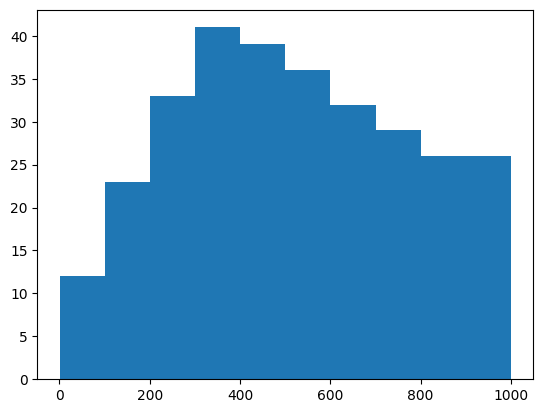

In [847]:
plt.hist(R["OII_flux"], range = (1,1000));

In [848]:
R["SFR_gilbank"] = gt.SFR_Gilbank(R["sed_logMass"], R["OII_lum"])

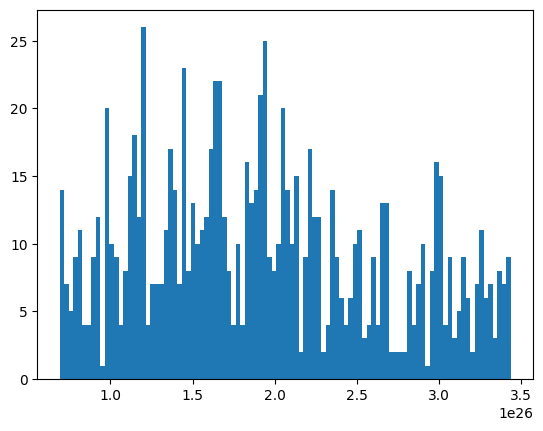

In [849]:
plt.hist(R["dist_lum"], bins = 100);

In [850]:
SFR_noNa = []
Mass_lim = []
for i, r in R.iterrows():
    if np.isnan(r["SFR_gilbank"]):
        #print("OHOHO")
        if np.isnan(r["OII_lum"]):
            if np.isnan(r["sed_logMass"]):
                SFR_noNa.append(gid.SFR_Gilbank(6, r["OII_lum_lim"]))
                Mass_lim.append(6)
            else:
                SFR_noNa.append(gid.SFR_Gilbank(r["mass"], r["OII_lum_lim"]))
                Mass_lim.append(r["sed_logMass"])
        elif np.isnan(r["sed_logMass"]):
            SFR_noNa.append(gid.SFR_Gilbank(6, r["OII_lum"]))
            Mass_lim.append(6)
    else:
        SFR_noNa.append(r["SFR_gilbank"])
        Mass_lim.append(r["sed_logMass"])

R["SFR_gilbank_noNa"] = np.array(SFR_noNa)
R["mass_lim"] = np.array(Mass_lim)
R["sSFR_gilbank"] = R["SFR_gilbank_noNa"]/R["sed_logMass"]

In [851]:
R["passive"] = (R["SFR_gilbank_noNa"] < 0.1*1e-9*10**R["sed_logMass"]).astype(int)

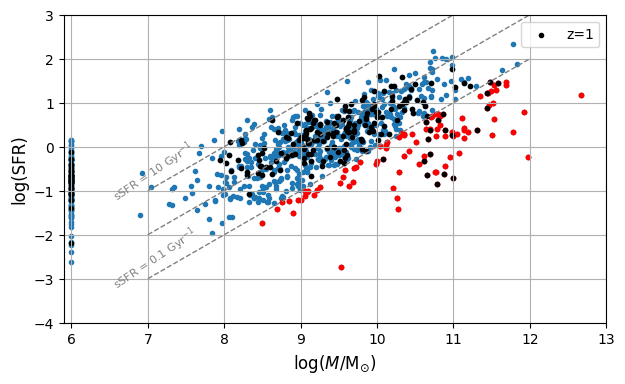

In [852]:
logmm = np.linspace(7,12, 100)
plt.figure(figsize = (7,4))
R_lowz = R[R["Z"]<1.5]
R_lim = R_lowz[R_lowz["SFR_gilbank"].isna()]
R_passive = R_lowz[R_lowz["passive"] == 1]
f_inf = R["Z"]>0.9
f_sup = R["Z"]< 1.1
R_z1 = R[f_inf & f_sup]

plt.scatter(R_lowz["sed_logMass"], np.log10(R_lowz["SFR_gilbank"]), marker = ".")
plt.scatter(R_passive["sed_logMass"], np.log10(R_passive["SFR_gilbank"]), marker = ".", c = "r")
plt.scatter(R_passive["mass_lim"], np.log10(R_passive["SFR_gilbank_noNa"]), marker = ".", c = "r")
plt.scatter(R_z1["mass_lim"], np.log10(R_z1["SFR_gilbank_noNa"]), marker = ".", c = "black", label = "z=1")

plt.scatter(R_lim["mass_lim"], np.log10(R_lim["SFR_gilbank_noNa"]), marker = "$\downarrow$")

#plt.plot(logmm, logsfr_guo, "--", c = "gray", label = "Guo 2013, z = 1")
#plt.plot(logmm, logsfr_elbaz, "--", c = "purple", label = "Elbaz 2013, z = 0.7")
plt.plot(logmm, np.log10(10*1e-9*10**logmm), "--", c = "gray", linewidth = 1)
plt.plot(logmm, np.log10(1*1e-9*10**logmm), "--", c = "gray", linewidth = 1)
plt.plot(logmm, np.log10(0.1*1e-9*10**logmm), "--", c = "gray", linewidth = 1)
plt.text(6.5, -1.2, 'sSFR = 10 Gyr$^{-1}$', fontsize = 8, color = 'gray', rotation = 34)
plt.text(6.5, -3.2, 'sSFR = 0.1 Gyr$^{-1}$', fontsize = 8, color = 'gray', rotation = 34)

plt.xlim((5.9,13))
plt.ylim((-4,3))
plt.xlabel("log($M$/M$_{\odot}$)", size = 12)
plt.ylabel("log(SFR)", size = 12)
plt.legend()
plt.grid()

# Absorption uncertainties 

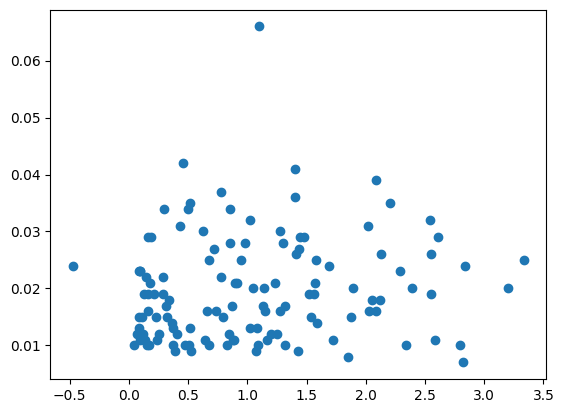

In [853]:
plt.scatter(Abs["REW_2796"], Abs["sig_REW_2796"])

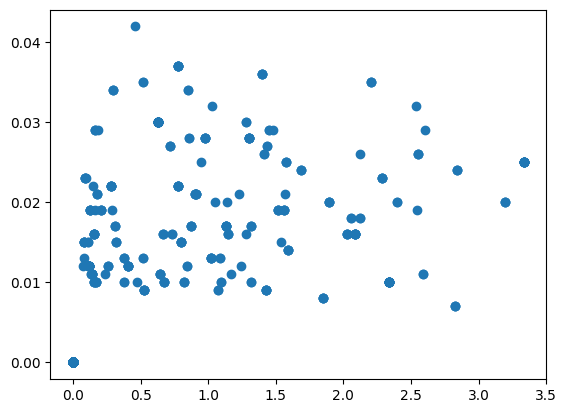

In [854]:
plt.scatter(R["REW_2796"], R["sig_REW_2796"])

### Rvir of the closest galaxy

In [855]:
sed_logMass_closest = []
Mvir_closest = []
Rvir_closest = []
for i, g in G.iterrows():
    rr = R[R["group_id"] == g["group_id"]]
    bmin = np.min(rr["B_KPC"])
    rrmin = rr[rr["B_KPC"] == bmin]
    zz = rrmin["Z"].values[0]
    mass = rrmin["sed_logMass"].values[0]
    #print(mass, zz)
    try:
        Mvir = gt.Behroozi_2019(mass, zz)
    except:
        Mvir = 0
    Rvir = gt.get_Rvir(10**Mvir, zz)
    
    sed_logMass_closest.append(mass)
    Mvir_closest.append(Mvir)
    Rvir_closest.append(Rvir)

sed_logMass_closest = np.array(sed_logMass_closest)
Mvir_closest = np.array(Mvir_closest)
Rvir_closest = np.array(Rvir_closest)

G["sed_logMass_closest"] = sed_logMass_closest
G["Mvir_closest"] = Mvir_closest
G["Rvir_closest"] = Rvir_closest

# Groups selection

In [856]:
G["bool_abs_01"] = (G["REW_2796"] > 0.1)*1
G["bool_abs_03"] = (G["REW_2796"] > 0.3)*1
G["bool_abs_1"] = (G["REW_2796"] > 1)*1

In [857]:
len(G)
len(G[G["N_gal"]>=3])

94

In [858]:
f5 = G["N_gal"] == 1
f6 = G["N_gal"]  > 1
#f7 = G["N100_los"] > 1
f8 = G["bool_absorption"] == 1
f_N_5 = G["N_gal"] >= 5
f_N_4 = G["N_gal"] >= 4
f_N_3 = G["N_gal"] >= 3
f_N9_5 = G["N_gal_9"] >= 5
f_N9_4 = G["N_gal_9"] >= 4
f_N9_3 = G["N_gal_9"] >= 3
f10 = G["bool_absorption"] == 0
f11 = G["N_gal"] >= 2
f12 = G["MgII_2796_lim"] == np.inf
f13 = G["MgII_2796_lim"] != np.inf
f14 = G["QSO_is_behind"] == True
f_M13 = np.log10(G["Mvir_sigma2"])>13
#f24 = G["ID"].isin(good_grp)

f15 = R["B_KPC"] <= 100
#f16 = R["N100_los"] <= 2
#f17 = R["N100_los"] <= 1
f18 = R["N50_neighb"] == 0
f19 = R["Z"] >= 4700/2796 - 1
f20 = R["Z"] <= 9300/2796 - 1
f21 = R["bool_absorption"] == 0
f22 = R["bool_absorption"] == 1
f23 = R["B_KPC"]>= 5 # remove the QSOs
#fweirds = G["Rvir_recomputed"] >= 10

In [859]:
G_abs = G[f8 & f14 & f13]
G_noabs = G[f10 & f14 & f13]
#G2 = G[f7 & f13 & f14]
#G2_abs = G[f8 & f7 & f14 & f13]
#G2_noabs = G[f10 & f7 & f14 & f13]
G5 = G[f_N_5 & f13 & f14]
G5_abs = G5[G5["bool_absorption"] == 1]
G5_noabs = G5[G5["bool_absorption"] == 0]
G4_nocov = G[f_N_4 & ~f13]
G4_nobehind = G[f_N_4 & ~f14]
G4_raw = G[f_N_4]
G4 = G[f_N_4 & f13 & f14]
G4_abs = G4[G4["bool_absorption"] == 1]
G4_noabs = G4[G4["bool_absorption"] == 0]
G3 = G[f_N_3 & f13 & f14]
G3_abs = G4[G4["bool_absorption"] == 1]
G3_noabs = G4[G4["bool_absorption"] == 0]


G5_9 = G[f_N9_5 & f13 & f14]
G5_9_abs = G5_9[G5_9["bool_absorption"] == 1]
G5_9_noabs = G5_9[G5_9["bool_absorption"] == 0]
G4_9 = G[f_N9_4 & f13 & f14]
G4_9_raw = G[f_N9_4]
G4_9_nocov = G[f_N9_4 & ~f13]
G4_9_nobehind = G[f_N9_4 & ~f14]
G4_9_abs = G4_9[G4_9["bool_absorption"] == 1]
G4_9_noabs = G4_9[G4_9["bool_absorption"] == 0]
G3_9 = G[f_N9_3 & f13 & f14]
G3_9_abs = G3_9[G3_9["bool_absorption"] == 1]
G3_9_noabs = G3_9[G3_9["bool_absorption"] == 0]

G4_9_raw_M13 = G[f_N9_4 & f_M13]

#R_ilane_abs = R[f22 & f15 & f17 & f18 & f23]
#R_ilane_noabs = R[f21 & f15 & f17 & f18  & f23]
#R_ilane2_abs = R[f22 & f17 & f18  & f23]
#R_ilane2_noabs = R[f21 & f17 & f18  & f23]

The number of groups of more than 5 galaxies is originally:

In [860]:
print("nb of groups of more than 3 gal: ", len(G3))
print("nb of groups of more than 4 gal: ", len(G4))
print("nb of groups of more than 4 gal raw: ", len(G4_raw))
print("nb of groups of more than 4 gal with no coverage: ", len(G4_nocov))
print("nb of groups of more than 4 gal not behind qso: ", len(G4_nobehind))
print("nb of groups of more than 5 gal: ", len(G5))

print("nb of groups of more than 3 gal with logM*>9: ", len(G3_9))
print("nb of groups of more than 4 gal with logM*>9 raw: ", len(G4_9_raw))
print("nb of groups of more than 4 gal with logM*>9 with no coverage: ", len(G4_9_nocov))
print("nb of groups of more than 4 gal with logM*>9 not behind qso: ", len(G4_9_nobehind))
print("nb of groups of more than 4 gal with logM*>9: ", len(G4_9))
print("nb of groups of more than 5 gal with logM*>9: ", len(G5_9))

print("nb of groups of more than 4 gal with logM*>9 raw and log(Mh)>13: ", len(G4_9_raw_M13))


nb of groups of more than 3 gal:  83
nb of groups of more than 4 gal:  36
nb of groups of more than 4 gal raw:  42
nb of groups of more than 4 gal with no coverage:  3
nb of groups of more than 4 gal not behind qso:  3
nb of groups of more than 5 gal:  21
nb of groups of more than 3 gal with logM*>9:  36
nb of groups of more than 4 gal with logM*>9 raw:  25
nb of groups of more than 4 gal with logM*>9 with no coverage:  1
nb of groups of more than 4 gal with logM*>9 not behind qso:  2
nb of groups of more than 4 gal with logM*>9:  22
nb of groups of more than 5 gal with logM*>9:  9
nb of groups of more than 4 gal with logM*>9 raw and log(Mh)>13:  5


In [475]:
G4_9_nobehind[["mean_z", "zqso_sdss"]]

mean_z  zqso_sdss
1   0.937678      0.938
40  1.360685      0.875

# statistics on absorbers & galaxies

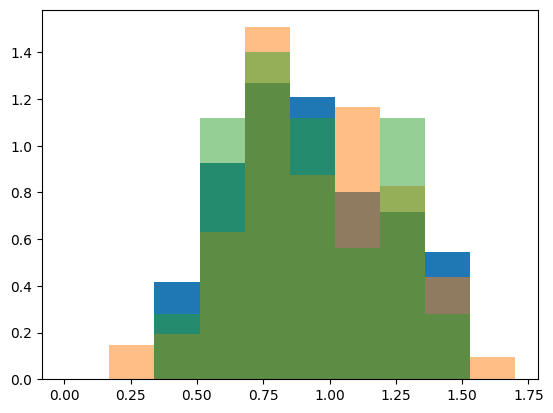

In [476]:
plt.hist(R["Z"], range = (0,1.7), density = True);
plt.hist(Abs["z_abs"], range = (0,1.7), density = True, alpha = 0.5);
plt.hist(G5["center_z"], range = (0,1.7), density = True, alpha = 0.5);

But we have to remove the groups that are behind the QSO:

Finally the number of groups of more than 5 galaxies is:

### exports the groups

In [477]:
#gid.plot_groups(R, G3, Nmin = 1, save = True,  filename = "FoF_G3_groups_caust.pdf")

# Mass of the groups

In [804]:
print(np.min(np.log10(G4_9_raw["Mvir_sigma2"])))
print(np.max(np.log10(G4_9_raw["Mvir_sigma2"])))
print(np.median(np.log10(G4_9_raw["Mvir_sigma2"])))

11.209906481027234
13.751604211988976
12.228570656829527


In [478]:
print(np.min(np.log10(G4_9["Mvir_sigma2"])))
print(np.max(np.log10(G4_9["Mvir_sigma2"])))
print(np.median(np.log10(G4_9["Mvir_sigma2"])))

11.209906481027234
13.751604211988976
12.215633873209153


In [805]:
print(np.min(G4_9_raw["center_z"]))
print(np.max(G4_9_raw["center_z"]))
print(np.median(G4_9_raw["center_z"]))

0.59969
1.4322860176967531
0.97172


In [479]:
print(np.min(G4_9["center_z"]))
print(np.max(G4_9["center_z"]))
print(np.median(G4_9["center_z"]))

0.59969
1.4322860176967531
0.9793076754063237


In [809]:
print(G4_9_raw[["REW_2796", "bool_absorption"]])

    REW_2796  bool_absorption
0      0.627                1
1      0.118                1
2      2.085                1
3      2.336                1
4      3.335                1
5      0.000                0
6      0.779                1
7      1.150                1
8      1.133                1
9      0.000                0
10     0.774                1
11     0.407                1
12     1.303                1
13     0.000                0
14     0.527                1
15     0.869                1
16     1.427                1
17     0.797                1
18     1.020                1
19     1.588                1
20     0.082                1
21     1.517                1
22     0.911                1
23     0.169                1
24     0.000                0


In [811]:
np.sum(G4_9_raw["bool_absorption"])

21

In [810]:
np.sum(G4_9["bool_absorption"])

20

In [806]:
print(np.min(G4_9_abs["REW_2796"]))
print(np.max(G4_9_abs["REW_2796"]))
print(np.median(G4_9_abs["REW_2796"]))

0.08199999999999999
3.335
0.9655


(0.0, 7.0)

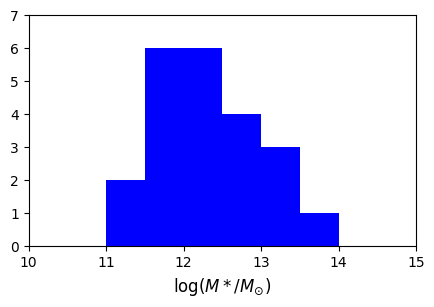

In [480]:
plt.figure(figsize = (5,3), dpi = 100)
plt.hist(np.log10(G4_9["Mvir_sigma2"]), bins = 10, range=(10, 15), color = "blue");
plt.xlabel("$\log(M*/M_{\odot}$)", size = 12)
plt.xlim((10,15))
plt.ylim((0, 7))

(0.0, 7.0)

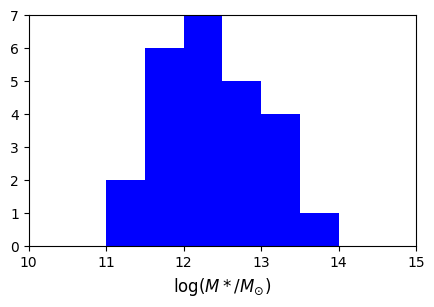

In [796]:
plt.figure(figsize = (5,3), dpi = 100)
plt.hist(np.log10(G4_9_raw["Mvir_sigma2"]), bins = 10, range=(10, 15), color = "blue");
plt.xlabel("$\log(M*/M_{\odot}$)", size = 12)
plt.xlim((10,15))
plt.ylim((0, 7))

# Phase space

In [481]:
r = np.linspace(0, 800,100)[1:]*u.kpc #0 has a singularity
z = 1
Mvir = 1e12
Rvir = gt.get_Rvir(1e12, z)
vesc = gt.NFW_escape_vel_from_Mvir(r, Mvir*u.solMass, z = z)
Vvir = (const.G*Mvir*const.M_sun/(Rvir*u.kpc))**0.5 #in km/s
Vvir = Vvir.to(u.km/u.s)
Vvir = Vvir.value
print(Rvir, Vvir)

156.28710893311342 165.88952578162505


(0.0, 2.5)

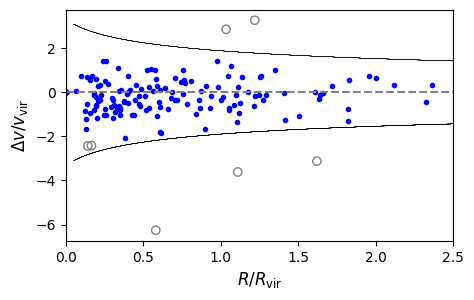

In [482]:
plt.figure(figsize = (5,3), dpi = 100)
plt.axhline(color = "gray", linestyle = '--')
for i, g in G4_9.iterrows():
    grpid = g.group_id
    galaxies = R[R["group_id"] == grpid]
    galaxies_clean = galaxies[galaxies["outlier"] == False]
    galaxies_out = galaxies[galaxies["outlier"] == True]
    #plt.scatter(galaxies["r_to_gcenter"], galaxies["vlos_to_gcenter"], c = "lightgray")
    plt.scatter(galaxies_clean["r_to_gcenter"]/g["Rvir_sigma2"], galaxies_clean["vlos_to_gcenter"]/g["Vvir_sigma2"], \
                c = 'blue', marker = ".")
    plt.scatter(galaxies_out["r_to_gcenter"]/g["Rvir_sigma2"], galaxies_out["vlos_to_gcenter"]/g["Vvir_sigma2"], \
                marker = "o", facecolors = "none", edgecolors = "gray")
    plt.plot(r/Rvir, vesc/Vvir, c = "black", linestyle = "--", linewidth = 0.1)
    plt.plot(r/Rvir, -vesc/Vvir, c = "black", linewidth = 0.1)
plt.xlabel("$R/R_{\mathrm{vir}}$", size = 12)
plt.ylabel("$\Delta v/v_{\mathrm{vir}}$", size = 12)
plt.xlim((0,2.5))
#plt.ylim((-1550,1550))
#plt.yticks(np.arange(-3, 4)*500);

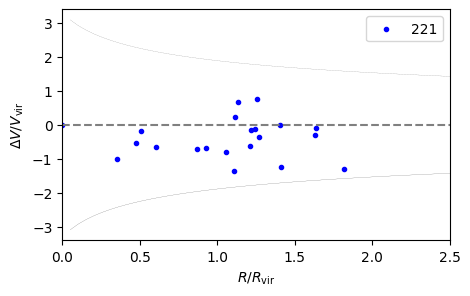

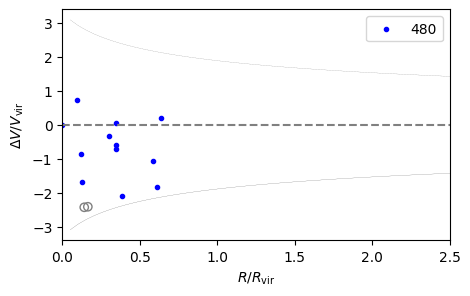

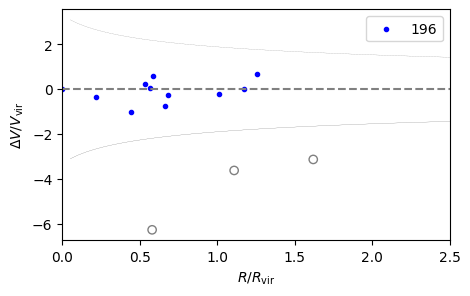

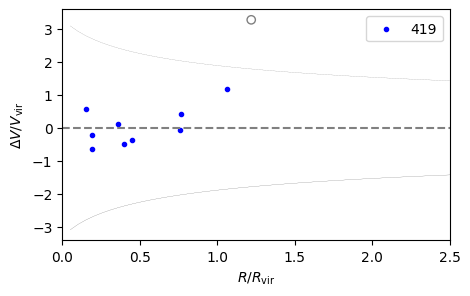

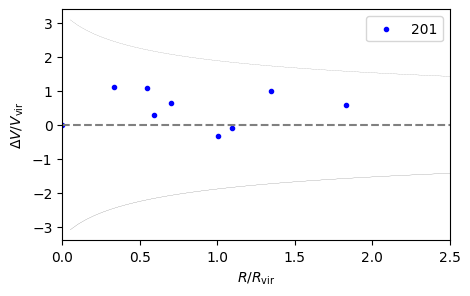

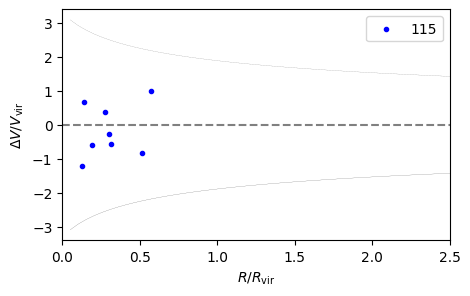

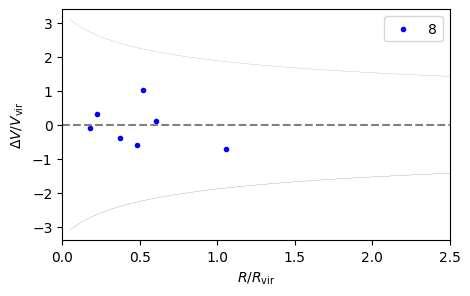

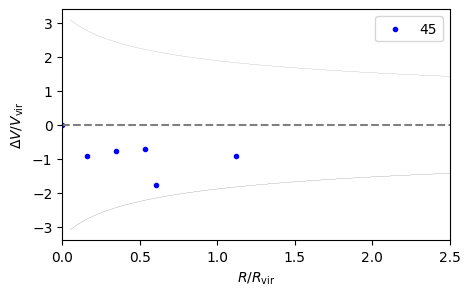

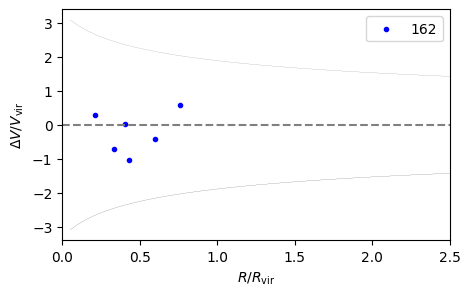

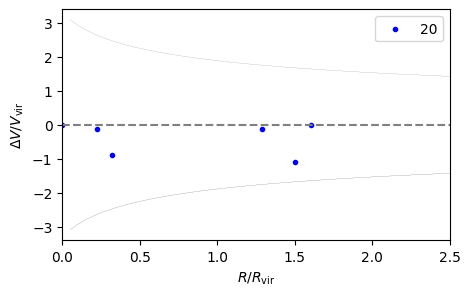

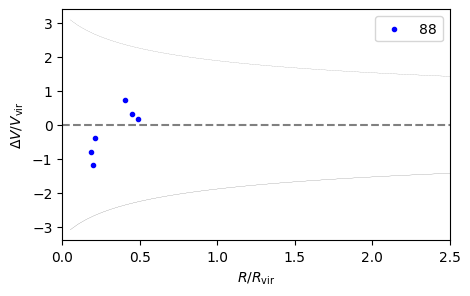

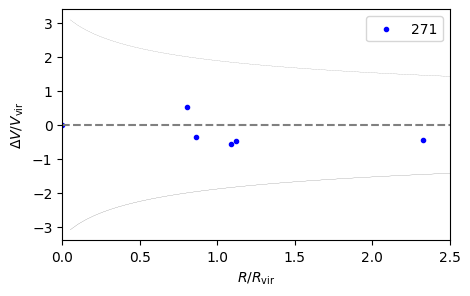

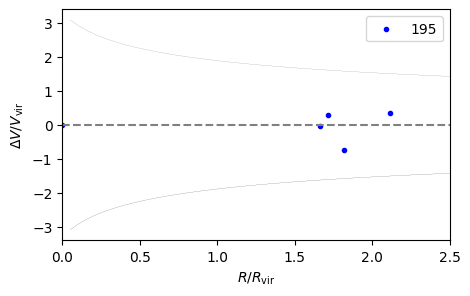

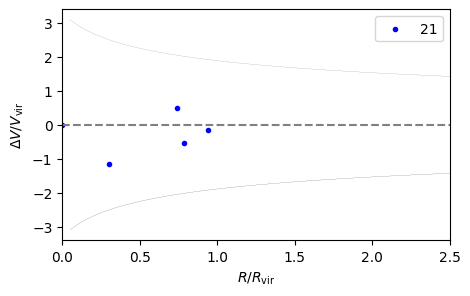

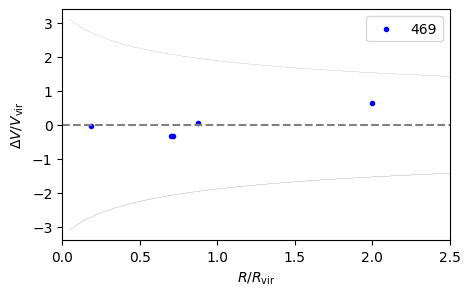

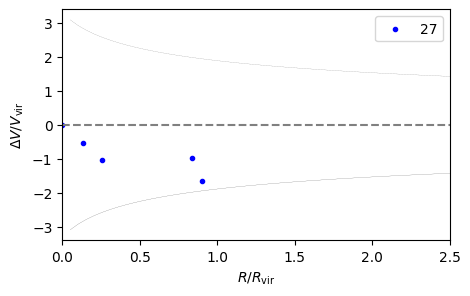

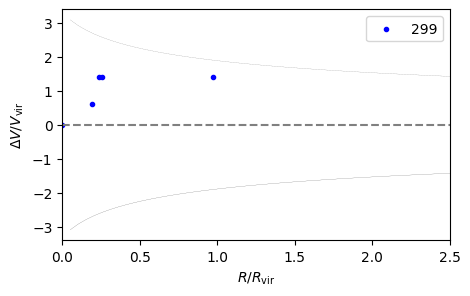

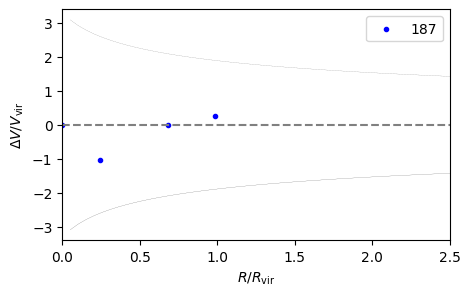

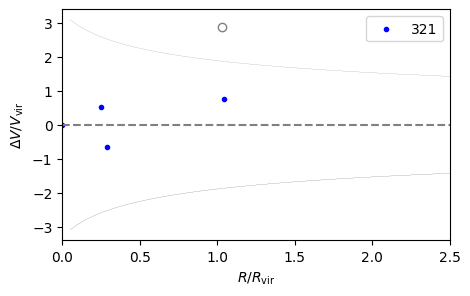

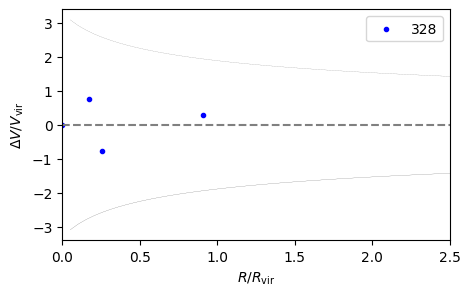

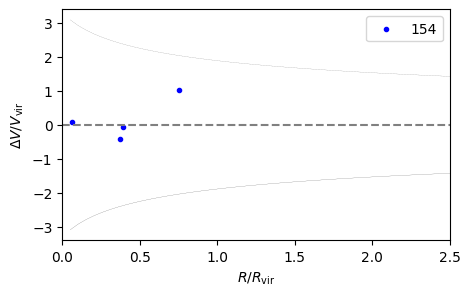

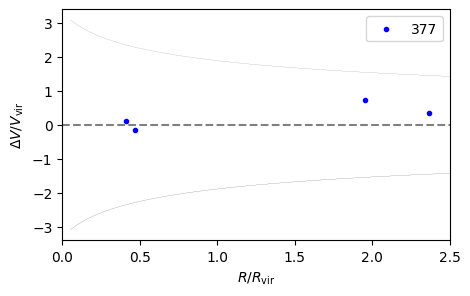

In [483]:
for i, g in G4_9.iterrows():
    plt.figure(figsize = (5,3))
    plt.axhline(color = "gray", linestyle = '--')
    grpid = g.group_id
    galaxies = R[R["group_id"] == grpid]
    galaxies_clean = galaxies[galaxies["outlier"] == False]
    galaxies_out = galaxies[galaxies["outlier"] == True]
    #plt.scatter(galaxies["r_to_gcenter"], galaxies["vlos_to_gcenter"], c = "lightgray")
    plt.scatter(galaxies_clean["r_to_gcenter"]/g["Rvir_sigma2"], galaxies_clean["vlos_to_gcenter"]/g["Vvir_sigma2"], \
                c = 'blue', marker = ".", label = str(grpid))
    plt.scatter(galaxies_out["r_to_gcenter"]/g["Rvir_sigma2"], galaxies_out["vlos_to_gcenter"]/g["Vvir_sigma2"], \
                marker = "o", facecolors = "none", edgecolors = "gray")
    plt.plot(r/Rvir, vesc/Vvir, c = "black", linestyle = "--", linewidth = 0.1)
    plt.plot(r/Rvir, -vesc/Vvir, c = "black", linewidth = 0.1)
    plt.xlabel("$R/R_{\mathrm{vir}}$")
    plt.ylabel("$\Delta V/V_{\mathrm{vir}}$")
    plt.xlim((0,2.5))
    #plt.ylim((-1550,1550))
    #plt.yticks(np.arange(-3, 4)*500);
    plt.legend()

Text(0, 0.5, '$\\Delta v$ $(km/s)$')

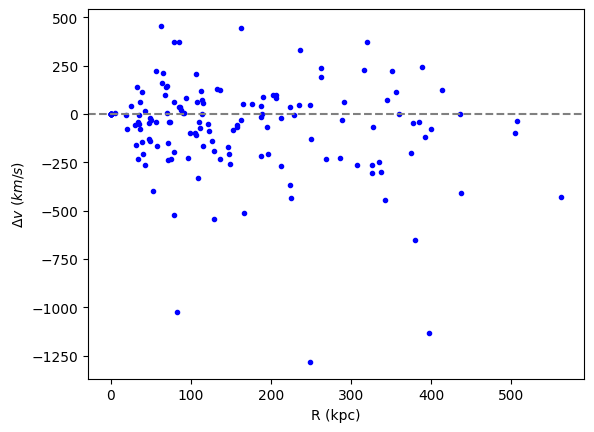

In [484]:
#plt.figure(figsize = (6,5))
plt.axhline(color = "gray", linestyle = '--')
for i, g in G4_9.iterrows():
    grpid = g.group_id
    galaxies = R[R["group_id"] == grpid]
    galaxies_clean = galaxies[galaxies["outlier"] == False]
    #plt.scatter(galaxies["r_to_gcenter"], galaxies["vlos_to_gcenter"], c = "lightgray")
    plt.scatter(galaxies_clean["r_to_gcenter"], galaxies_clean["vlos_to_gcenter"], c = 'blue', marker = ".")
plt.xlabel("R (kpc)")
plt.ylabel("$\Delta v$ $(km/s)$")
#plt.xlim((0, 2))
#plt.ylim((-1500,1500))

# Absorptions

 **Look at the isolated galaxies** located at the foreground of QSO, by applying the same selection as Ilane or completely alone in the FOV...

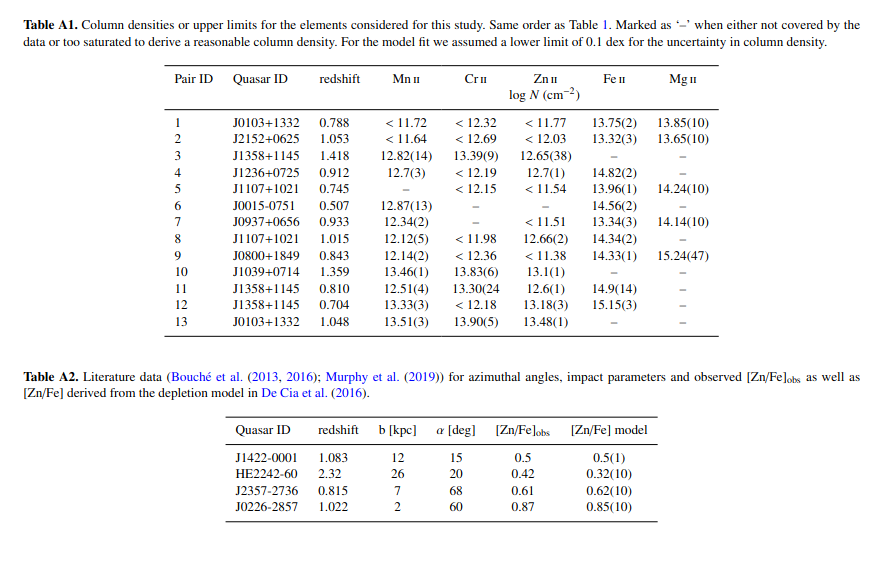

## Kinematics of the groups

In [485]:
#gid.plot_groups_2(R, G5, Nmin = 5, save = False,  filename = "none")

# Correlation with halo masses

Text(0.5, 0, '$\\log(M*/M_{\\odot})$')

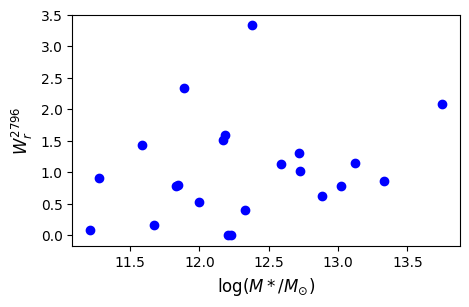

In [486]:
#plt.scatter(G3["Mvir_vel_disp"], G3["REW_2796"], marker = "o", c = "orange")
plt.figure(figsize = (5, 3))
plt.scatter(np.log10(G4_9["Mvir_sigma2"]), G4_9["REW_2796"], marker = "o", c = "blue")
plt.ylabel("$W^{2796}_r$", size = 12)
plt.xlabel("$\log(M*/M_{\odot})$", size = 12)

Text(0, 0.5, '$\\log(M*/M_{\\odot})$')

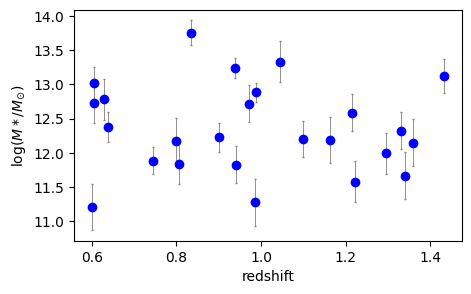

In [798]:
plt.figure(figsize = (5,3), dpi = 100)
plt.errorbar(np.array(G4_9_raw["center_z"]), np.log10(G4_9_raw["Mvir_sigma2"]), \
             yerr = np.array(G4_9_raw["log_Mvir_sigma2_err"]), \
             color = "gray", linestyle = "none", linewidth = 0.6, capsize = 0.6, zorder = 0)
plt.scatter(G4_9_raw["center_z"], np.log10(G4_9_raw["Mvir_sigma2"]), color = "blue", zorder = 2)
plt.xlabel("redshift")
plt.ylabel("$\log(M*/M_{\odot})$")

Text(0, 0.5, '$log(M*/M_{\\odot})$')

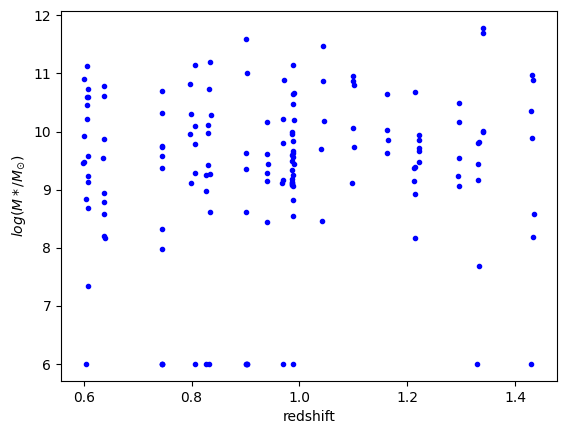

In [488]:
#plt.figure(figsize = (6,5))
#plt.axhline(color = "gray", linestyle = '--')
for i, g in G4_9.iterrows():
    grpid = g.group_id
    galaxies = R[R["group_id"] == grpid]
    galaxies_clean = galaxies[galaxies["outlier"] == False]
    #plt.scatter(galaxies["r_to_gcenter"], galaxies["vlos_to_gcenter"], c = "lightgray")
    plt.scatter(galaxies_clean["Z"], galaxies_clean["sed_logMass"], c = 'blue', marker = ".")
plt.xlabel("redshift")
plt.ylabel("$log(M*/M_{\odot})$")
#plt.xlim((0, 2))
#plt.ylim((-1500,1500))

For an error of $\Delta$ on Mvir, the error on $\log(Mvir)$ is $\Delta log(Mvir) = dlogMvir*\Delta/dMvir$
which is equal to:
\begin{equation}
\Delta log(Mvir) = \frac{\Delta}{Mvir}
\end{equation}

Text(0, 0.5, '$N_{\\mathrm{FOV}}$')

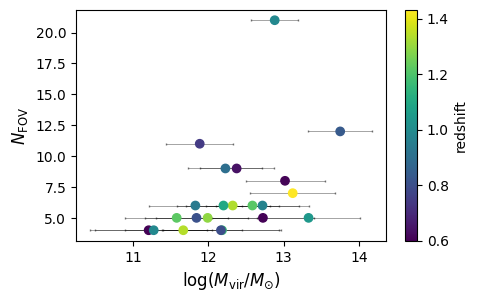

In [801]:
plt.figure(figsize = (5,3), dpi = 100)

plt.errorbar(np.array(np.log10(G4_9_raw["Mvir_sigma2"])), G4_9_raw["N_gal"],\
             xerr = np.array(G4_9_raw["Mvir_sigma2_error"]/G4_9_raw["Mvir_sigma2"]), \
             color = "blue", zorder = 2, linestyle = "", ecolor = "black", alpha = 0.5, linewidth = 0.5, capsize = 1)

#plt.hlines(G5["N_gal"], np.log10(G5["Mvir_sigma2"] - G5["Mvir_sigma2_error"]),\
#           np.log10(G5["Mvir_sigma2"] + G5["Mvir_sigma2_error"]), color = "black", linewidth = 0.5, alpha = 0.5) 
plt.scatter(np.log10(G4_9_raw["Mvir_sigma2"]), G4_9_raw["N_gal"], c = G4_9_raw["center_z"], zorder = 2)


plt.colorbar(label = "redshift")


X = np.array(np.log10(G4_9["Mvir_sigma2"]))
Y = np.array(G4_9["N_gal"],)
txt = np.array(G4_9["ID"])

#for i in range(len(G5)):
    #plt.annotate(str(txt[i]), (X[i], Y[i]))
#plt.yticks([5,10,15,20])
    

plt.xlabel("$\log(M_{\mathrm{vir}}/M_{\odot})$", size = 12)
plt.ylabel("$N_{\mathrm{FOV}}$", size = 12)
#plt.grid()

In [ ]:
plt.figure(figsize = (5,3), dpi = 100)
plt.scatter(G4_9["center_z"], G4_9["N_gal"], c = np.log10(G4_9["Mvir_sigma2"]))
plt.colorbar(label = "$\log(M_{\mathrm{vir}}/M_\odot)$")


X = np.array(np.log10(G4_9["Mvir_sigma2"]))
Y = np.array(G4_9["N_gal"],)
txt = np.array(G4_9["ID"])

#for i in range(len(G5)):
    #plt.annotate(str(txt[i]), (X[i], Y[i]))
    

plt.xlabel("$z$", size = 12)
plt.ylabel("$N_{FOV}$", size = 12)
plt.ylim((3, 25))
plt.grid()

# Bmin or Bcenter ?

In [ ]:
plt.figure(figsize = (7,4))
plt.title("FoF groups ($N >= 5$)")
#plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none')
plt.scatter(G4_9_abs["b_center_kpc_norm2"], G4_9_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = G4_9_abs["b_min_kpc"], vmin = 0, vmax = 100)
plt.scatter(G4_9_noabs["b_center_kpc_norm2"], G4_9_noabs["detection_limit"], marker = "v", label = "groups N >= 5", \
             c = G4_9_noabs["b_min_kpc"], vmin = 0, vmax = 100)
plt.colorbar(label = "bmin kpc")

X = np.array(G4_9_abs["b_center_kpc_norm2"])
Y = np.array(G4_9_abs["REW_2796"])
txt = np.array(G4_9_abs["ID"])

for i in range(len(G4_9_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G4_9_noabs["b_center_kpc_norm2"])
Y = np.array(G4_9_noabs["detection_limit"])
txt = np.array(G4_9_noabs["ID"])

for i in range(len(G4_9_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

# Fit of the MgII decrease

In [ ]:
from scipy.optimize import minimize
from scipy import integrate

The fit is performed using the method described in Hogg 2010 but also taking into accout the upper limit as in Dutta 2020 and Rubin 2018. The idea is to take into account the uncertainties along the 2 axis by taking the distance to the linear relation. 

First, when we look at the uncertainties we can see that there is a nan values:

In [ ]:
G4_9[["b_min_kpc","b_center_kpc_norm2", "REW_2796", "sig_REW_2796"]]

In [ ]:
idx = G4_9.index[G4_9["sig_REW_2796"].isnull()].to_list()
G4_9.loc[idx, "sig_REW_2796" ] = 0.05

we affect a value:

In [490]:
Abs = pd.read_csv("MgII_all_absorption")

The likelihood from Dutta is composed of 2 terms:

\begin{equation}
    L(W) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma_i^2}}\exp\left(-\frac{1}{2}\left[\frac{W_i - W(R_i)}{\sigma_i}\right]^2\right)
\times \prod_{i=1}^m \int_{-\infty}^{W_i} \frac{dW'}{\sqrt{2\pi\sigma_i^2}}\exp\left(-\frac{1}{2}\left[\frac{W' - W(R_i)}{\sigma_i}\right]^2\right)
\end{equation}

The first one is the classic one for points that have MgII detection. The second term is there to take into account the points that have an upper detection limit. To compute this second term we can use the erf function, defined as:

\begin{equation}
    erf(z) = \frac{2}{\pi}\int_0^{z} e^{-t^2}dt
\end{equation}

For that we Pose, for each subterm i: 
\begin{equation}
    x = \frac{W'-W(R_i)}{\sqrt{2}\sigma_i}
\end{equation}

hence we have:
\begin{equation}
    dx = \frac{dW'}{\sqrt{2}\sigma_i}
\end{equation}

And for $W' = Wi$ we have 
\begin{equation}
    x = \frac{W_i-W(R_i)}{\sqrt{2}\sigma_i}\equiv{}X
\end{equation}

In consequence:
\begin{equation}
    I = \frac{\sqrt{2}\sigma_i}{\sqrt{2\pi\sigma_i^2}}\int_{-\infty}^{X} e^{-x^2}dx
\end{equation}

So: 
\begin{equation}
    I = \frac{1}{\sqrt{\pi}}\left[\int_{-\infty}^{0} e^{-x^2}dx + \int_{0}^{X} e^{-x^2}dx\right]
\end{equation}
\begin{equation}
    I = \frac{1}{\sqrt{\pi}}\left[\frac{\sqrt{\pi}}{2}+ \frac{\sqrt{\pi}}{2} erf(X)\right]
\end{equation}
\begin{equation}
    I = \frac{1}{2}\left[1+ erf(X)\right]
\end{equation}


So Finally, the total likelihood is: 
\begin{equation}
    L(W) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma_i^2}}\exp\left(-\frac{1}{2}\left[\frac{W_i - W(R_i)}{\sigma_i}\right]^2\right)
\times \prod_{i=1}^m \frac{1}{2}\left[1+ erf(X_i)\right]
\end{equation}



We also have to take into accout an intrisic scatter $\sigma_c$. For that we use the method described in Chen 2010. We first assume a value and then we iter to refine the intrisic scatter.
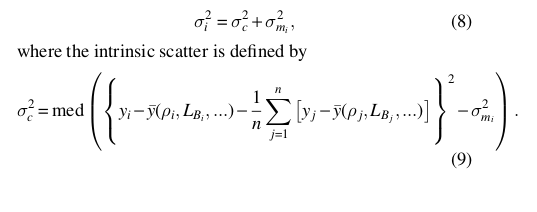

In [491]:
G4_9_abs["sig_REW_2796"]

0     0.030
2     0.016
3     0.010
4     0.025
6     0.037
7       NaN
8     0.028
10    0.012
12    0.017
14    0.022
16    0.009
17    0.017
18    0.009
20    0.015
23    0.013
24    0.014
25    0.015
29    0.019
32    0.021
33    0.010
Name: sig_REW_2796, dtype: float64

In [492]:
G4_9_abs["sig_REW_2796"] = np.maximum(G4_9_abs["sig_REW_2796"], 0.05)
G4_9_abs['sig_REW_2796'] = G4_9_abs['sig_REW_2796'].fillna(0.05)
G4_9['sig_REW_2796'] = G4_9['sig_REW_2796'].fillna(0.05)

### for bcenter/Rvir

We define the input data:

In [694]:
x1 = np.array(G4_9_abs["b_center_kpc_norm2"])
x2 = np.array(G4_9_noabs["b_center_kpc_norm2"])
y1 = np.array(np.log10(G4_9_abs["REW_2796"]))
y2 = np.array(np.log10(G4_9_noabs["detection_limit"]))
sig_x1 = np.array(G4_9_abs["b_center_kpc_norm2_err"])
sig_x2 = np.array(G4_9_noabs["b_center_kpc_norm2_err"])
sig_y1 = np.array(G4_9_abs["sig_REW_2796"]/G4_9_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

the y-uncertainties for the point with no detection are not defined in the catalog but we must affect a value. When we look at the plots above we can see that the uncertainty increase when the REW decrease (which is logical). if we plot the uncertainty as a function of the REW (see below) we can assume that a value of ~ 0.3 is of the good order of magnitude.

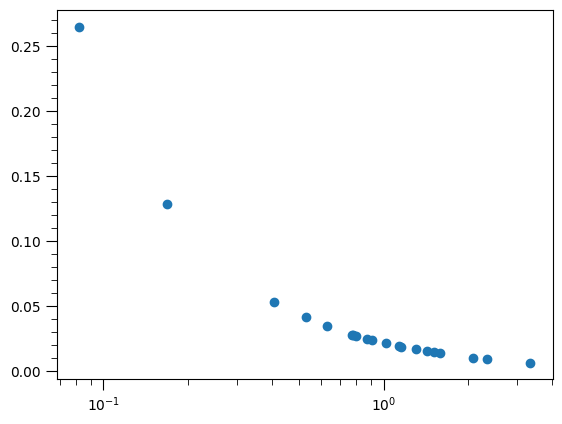

In [695]:
plt.scatter(G4_9_abs["REW_2796"], G4_9_abs["sig_REW_2796"]/G4_9_abs["REW_2796"]/np.log(10))
plt.xscale("log")
#plt.yscale("log")

N =  0
0.29481934207269833
N =  1
0.13810684982617605
N =  2
0.14043307364803315
N =  3
0.14081929120814574
N =  4
0.1408838001346561
N =  5
0.1408945901164236
N =  6
0.14089639316914376
N =  7
0.14089669596070528
N =  8
0.14089674596259708
N =  9
0.14089675570603605


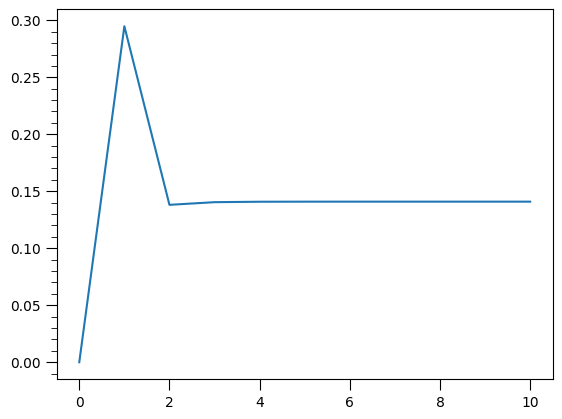

In [702]:
LMG, sig_intr_lst = gt.fit_REW(G4_9, x1, y1, sig_x1, sig_y1, x2, y2, sig_x2, sig_y2,\
                                Niter = 10, init_param = np.array([-0.1,-0.1]))

In [700]:
LMG

      fun: 17.740849716657987
 hess_inv: array([[ 0.0049236 , -0.00695753],
       [-0.00695753,  0.01586741]])
      jac: array([1.66893005e-06, 1.43051147e-06])
  message: 'Optimization terminated successfully.'
     nfev: 44
      nit: 9
     njev: 14
   status: 0
  success: True
        x: array([ 0.51233887, -1.00860617])

In [698]:
LMG_1sig = np.diag(LMG.hess_inv)**0.5
LMG_1sig_inf = LMG['x'] - LMG_1sig
LMG_1sig_sup = LMG['x'] + LMG_1sig
LMG_1sig

array([0.07016838, 0.1259659 ])

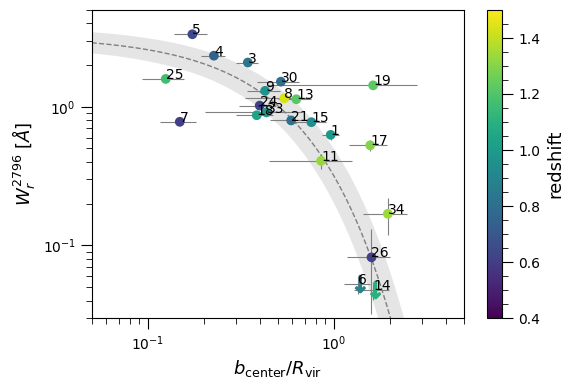

In [699]:
bbb = np.linspace(10, 600, 200)
www = gt.Tinker_2008(bbb)
rvir = gt.get_Rvir(1e12, 0.6)

plt.figure(figsize = (6,4), dpi = 100)
X = np.linspace(0.05, 3, 500)
plt.plot(X, 10**(gt.model(LMG['x'], X)), linewidth = 1.0, c = "gray", label = "best fit", \
         linestyle = "--")
plt.fill_between(X, 10**(gt.model(LMG_1sig_inf, X)), 10**(gt.model(LMG_1sig_sup, X)), \
                 color = "gray", alpha = 0.2, linewidth = 0)
#plt.plot(bbb/rvir, www, label = "isothermal T08", linestyle = "--", c = "r")
#plt.legend()

plt.errorbar(G4_9_abs["b_center_kpc_norm2"], G4_9_abs["REW_2796"], xerr = G4_9_abs["b_center_kpc_norm2_err"],\
             yerr = G4_9_abs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8, zorder = 1)
plt.scatter(G4_9_abs["b_center_kpc_norm2"], G4_9_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = G4_9_abs["mean_z"], vmin = 0.4, vmax = 1.5, zorder = 2)
cbar = plt.colorbar()
cbar.set_label("redshift", fontsize=13)

#cm = plt.cm.get_cmap('RdYlBu')
#im = ax1.scatter(isol_abs["Z"], isol_abs["B_KPC"], c = isol_abs["REW_2796"],\
#            zorder = 2, vmin = 0, vmax = 3, alpha = 1)
#cbar = fig.colorbar(im, ax=ax1)
#cbar.set_label("$W^{2796}_{\mathrm{r}}$ $[\AA]$", fontsize=14)

plt.errorbar(G4_9_noabs["b_center_kpc_norm2"], G4_9_noabs["detection_limit"], xerr = G4_9_noabs["b_center_kpc_norm2_err"], \
             yerr = (np.ones(len(G4_9_noabs["sig_REW_2796"]))*0.15*G4_9_noabs["detection_limit"]),\
             fmt = 'none',c = "gray", linewidth = 0.8, zorder = 1)
plt.scatter(G4_9_noabs["b_center_kpc_norm2"], G4_9_noabs["detection_limit"], marker = "$\downarrow$", s = 150,\
            label = "groups N >= 5", c = G4_9_noabs["mean_z"],vmin = 0.4, vmax = 1.5, zorder = 2)

X = np.array(G4_9_abs["b_center_kpc_norm2"])
Y = np.array(G4_9_abs["REW_2796"])
txt = np.array(G4_9_abs["ID"])

for i in range(len(G4_9_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G4_9_noabs["b_center_kpc_norm2"])
Y = np.array(G4_9_noabs["detection_limit"])
txt = np.array(G4_9_noabs["ID"])

for i in range(len(G4_9_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{\mathrm{center}}/R_{\mathrm{vir}}$", size = 13)
plt.ylabel("$W_r^{2796}$ $[\AA]$", size = 13)
plt.ylim((0.03, 5))
plt.xlim((0.05,5))
#plt.grid()
plt.xscale("log")
plt.yscale("log")


The 0.1 A EW is reached for: 

In [703]:
fit_bcenter_norm = minimize(gt.logL_stats_total, np.array([0.001,-0.01, 0.2]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_bcenter_norm

      fun: 10.16338112741235
 hess_inv: array([[ 0.0156297 , -0.01385558,  0.00033836],
       [-0.01385558,  0.01883446, -0.00108492],
       [ 0.00033836, -0.00108492,  0.00356623]])
      jac: array([ 0.00000000e+00, -1.19209290e-07, -2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 92
      nit: 18
     njev: 23
   status: 0
  success: True
        x: array([ 0.3446439 , -0.65077157,  0.33483971])

In [710]:
fit_bcenter_norm_1sig = np.diag(fit_bcenter_norm.hess_inv)**0.5
fit_bcenter_norm_1sig_inf = fit_bcenter_norm['x'] - fit_bcenter_norm_1sig
fit_bcenter_norm_1sig_sup = fit_bcenter_norm['x'] + fit_bcenter_norm_1sig
print(fit_bcenter_norm_1sig)

[0.12501881 0.13723871 0.05971794]


(0.01, 5)

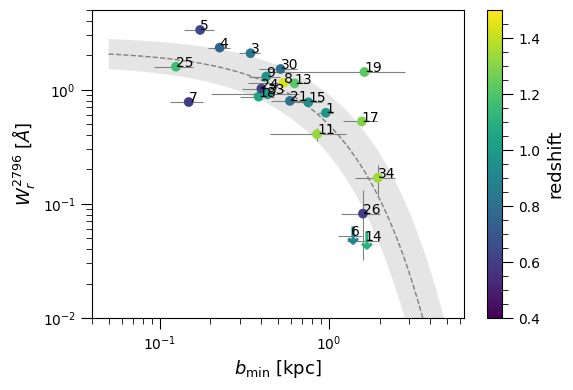

In [709]:
plt.figure(figsize = (6,4), dpi = 100)
X = np.linspace(0.05, 5, 500)
plt.plot(X, 10**(gt.model(fit_bcenter_norm['x'], X)), linewidth = 1.0, c = "gray", label = "best fit", \
         linestyle = "--")
plt.fill_between(X, 10**(gt.model(fit_bcenter_norm_1sig_inf, X)), 10**(gt.model(fit_bcenter_norm_1sig_sup, X)), \
                 color = "gray", alpha = 0.2, linewidth = 0)

plt.errorbar(G4_9_abs["b_center_kpc_norm2"], G4_9_abs["REW_2796"], xerr = G4_9_abs["b_center_kpc_norm2_err"],\
             yerr = G4_9_abs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8, zorder = 1)
plt.scatter(G4_9_abs["b_center_kpc_norm2"], G4_9_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = G4_9_abs["mean_z"], vmin = 0.4, vmax = 1.5, zorder = 2)
cbar = plt.colorbar()
cbar.set_label("redshift", size = 13)


plt.errorbar(G4_9_noabs["b_center_kpc_norm2"], G4_9_noabs["detection_limit"], xerr = G4_9_noabs["b_center_kpc_norm2_err"], \
             yerr = G4_9_noabs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8, zorder = 1)
plt.scatter(G4_9_noabs["b_center_kpc_norm2"], G4_9_noabs["detection_limit"], marker = "$\downarrow$", s = 150,\
            label = "groups N >= 5", c = G4_9_noabs["mean_z"],vmin = 0.4, vmax = 1.5, zorder = 2)

X = np.array(G4_9_abs["b_center_kpc_norm2"])
Y = np.array(G4_9_abs["REW_2796"])
txt = np.array(G4_9_abs["ID"])

for i in range(len(G4_9_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G4_9_noabs["b_center_kpc_norm2"])
Y = np.array(G4_9_noabs["detection_limit"])
txt = np.array(G4_9_noabs["ID"])

for i in range(len(G4_9_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{\mathrm{min}}$ [kpc]", size = 13)
plt.ylabel("$W_r^{2796}$ $[\AA]$", size = 13)
#plt.grid()
plt.xscale("log")
plt.yscale("log")
#plt.xlim((0.1,5))
#plt.xlim((5, 500))
plt.ylim((0.01, 5))

## Now for the plot with bmin

In [499]:
x1 = np.array(G4_9_abs["b_min_kpc"])
x2 = np.array(G4_9_noabs["b_min_kpc"])
y1 = np.array(np.log10(G4_9_abs["REW_2796"]))
y2 = np.array(np.log10(G4_9_noabs["detection_limit"]))
#sig_x1 = np.ones(len(x1))*10
#sig_x2 = np.ones(len(x2))*10
sig_x1 = np.zeros(len(x1))
sig_x2 = np.zeros(len(x2))
sig_y1 = np.array(G4_9_abs["sig_REW_2796"]/G4_9_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

N =  0
0.23501555147171144
N =  1
0.2315289175880917
N =  2
0.22158980631111133
N =  3
0.2275325081498427
N =  4
0.23450830704588005
N =  5
0.23486027740237833
N =  6
0.2321348316035058
N =  7
0.2209163762230102
N =  8
0.22699481551626813
N =  9
0.23175842907296626


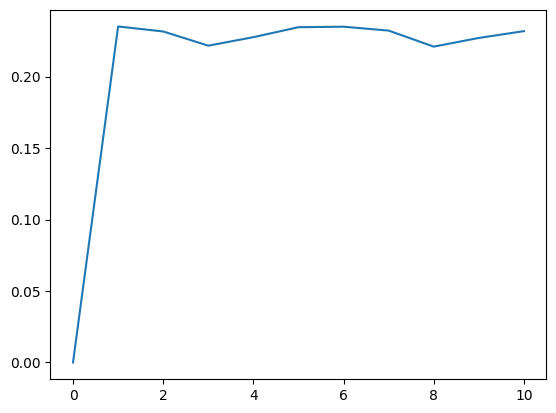

In [500]:
LMG, sig_intr_lst = gt.fit_REW(G4_9, x1, y1, sig_x1, sig_y1, x2, y2, sig_x2, sig_y2,\
                                Niter = 10, init_param = np.array([-0.001,-0.01]))

In [501]:
LMG

      fun: 39.60812163350042
 hess_inv: array([[ 1.16774697e-09, -2.23231518e-10],
       [-2.23231518e-10,  1.79787411e-07]])
      jac: array([21.39121389, 12.07650232])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 213
      nit: 9
     njev: 64
   status: 2
  success: False
        x: array([ 0.26620859, -0.00639652])

In [502]:
LMG_1sig = np.diag(LMG.hess_inv)**0.5
LMG_1sig_inf = LMG['x'] - LMG_1sig
LMG_1sig_sup = LMG['x'] + LMG_1sig

(0.03, 6)

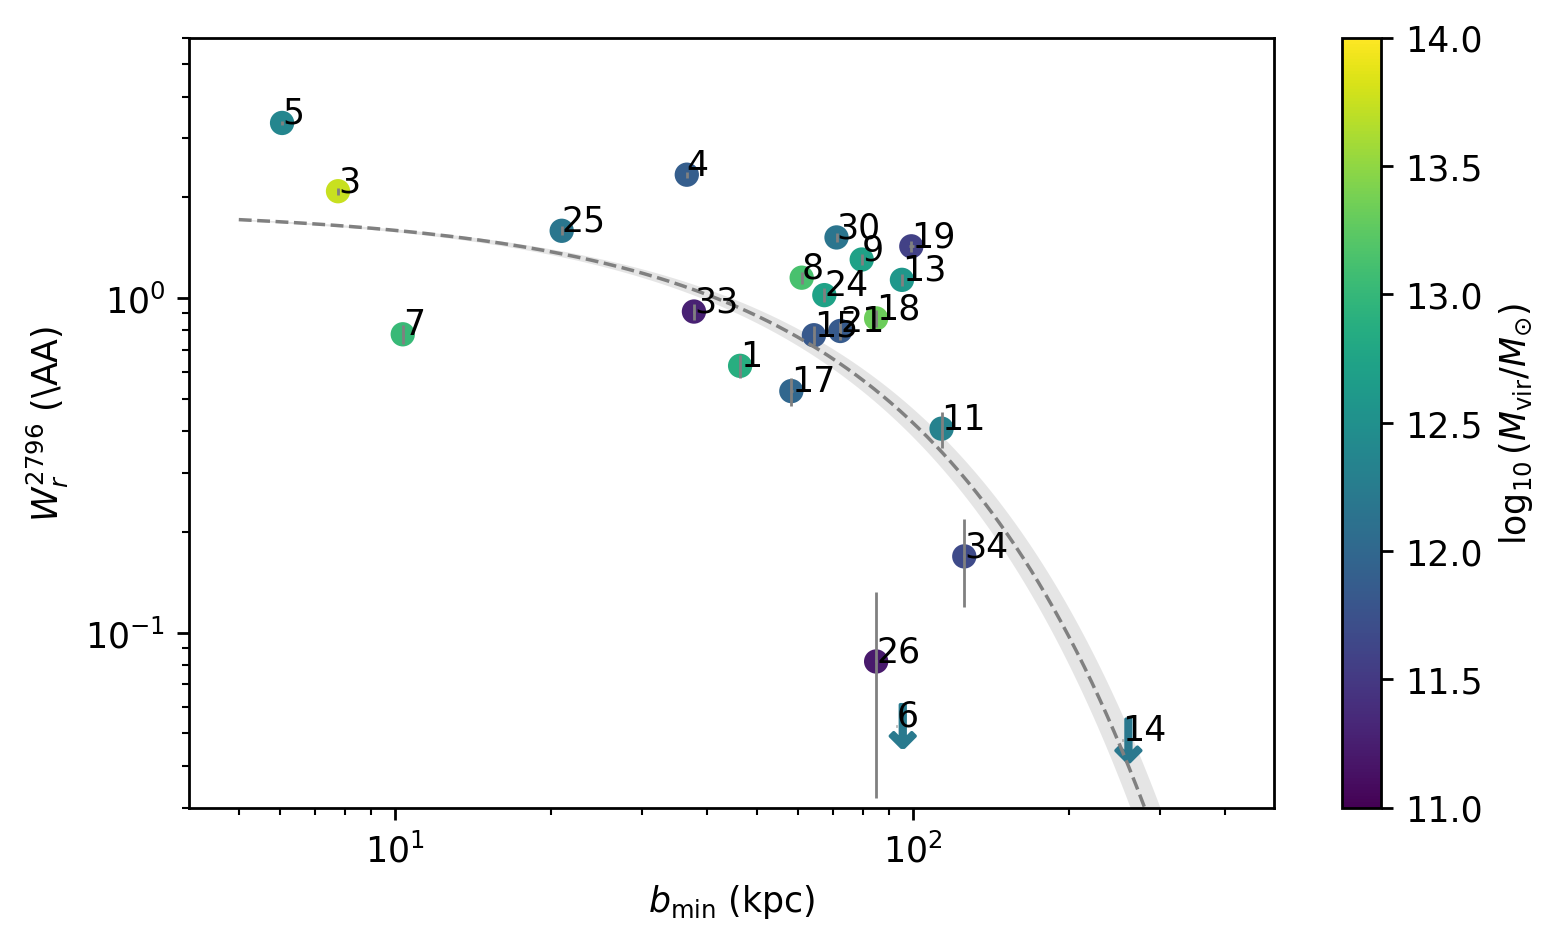

In [503]:
plt.figure(figsize = (7,4), dpi = 250)
X = np.linspace(5, 400, 500)
plt.plot(X, 10**(gt.model(LMG['x'], X)), linewidth = 1.0, c = "gray", label = "best fit", \
         linestyle = "--")
plt.fill_between(X, 10**(gt.model(LMG_1sig_inf, X)), 10**(gt.model(LMG_1sig_sup, X)), \
                 color = "gray", alpha = 0.2, linewidth = 0)

plt.errorbar(G4_9_abs["b_min_kpc"], G4_9_abs["REW_2796"], xerr = G4_9_abs["b_center_kpc_norm2_err"],\
             yerr = G4_9_abs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G4_9_abs["b_min_kpc"], G4_9_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = np.log10(G4_9_abs["Mvir_sigma2"]), vmin = 11, vmax = 14)
plt.colorbar(label = "$\log_{10}(M_{\mathrm{vir}}/M_{\odot})$")

plt.errorbar(G4_9_noabs["b_min_kpc"], G4_9_noabs["detection_limit"], xerr = G4_9_noabs["b_center_kpc_norm2_err"], \
             yerr = G4_9_noabs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G4_9_noabs["b_min_kpc"], G4_9_noabs["detection_limit"], marker = "$\downarrow$", s = 150,\
            label = "groups N >= 5", c = np.log10(G4_9_noabs["Mvir_sigma2"]),vmin = 11, vmax = 14)

X = np.array(G4_9_abs["b_min_kpc"])
Y = np.array(G4_9_abs["REW_2796"])
txt = np.array(G4_9_abs["ID"])

for i in range(len(G4_9_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G4_9_noabs["b_min_kpc"])
Y = np.array(G4_9_noabs["detection_limit"])
txt = np.array(G4_9_noabs["ID"])

for i in range(len(G4_9_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{\mathrm{min}}$ (kpc)")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")
#plt.xlim((0.1,5))
plt.ylim((0.03, 6))

In [504]:
fit_bmin = minimize(gt.logL_stats_total, np.array([0.001,-0.01, 0.2]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_bmin

      fun: 9.652703028569324
 hess_inv: array([[ 1.78416376e-02, -1.94621823e-04,  6.48364241e-04],
       [-1.94621823e-04,  2.98013322e-06, -1.76516792e-05],
       [ 6.48364241e-04, -1.76516792e-05,  3.66075556e-03]])
      jac: array([ 0.00000000e+00,  4.64916229e-06, -2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 92
      nit: 18
     njev: 23
   status: 0
  success: True
        x: array([ 0.40095162, -0.00790875,  0.33041111])

In [689]:
fit_bmin_1sig = np.diag(fit_bmin.hess_inv)**0.5
fit_bmin_1sig_inf = fit_bmin['x'] - fit_bmin_1sig
fit_bmin_1sig_sup = fit_bmin['x'] + fit_bmin_1sig
print(fit_bmin_1sig)

[0.13357259 0.00172631 0.06050418]


(0.01, 5)

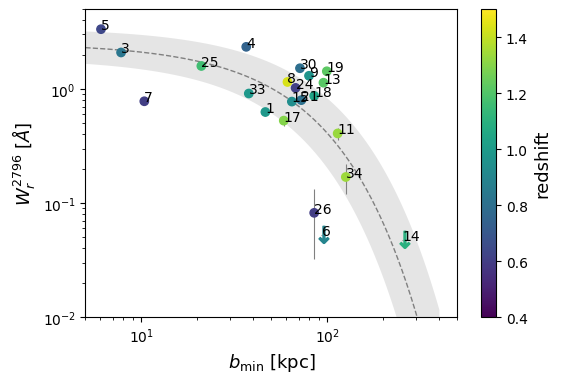

In [506]:
plt.figure(figsize = (6,4), dpi = 100)
X = np.linspace(5, 400, 500)
plt.plot(X, 10**(gt.model(fit_bmin['x'], X)), linewidth = 1.0, c = "gray", label = "best fit", \
         linestyle = "--")
plt.fill_between(X, 10**(gt.model(fit_bmin_1sig_inf, X)), 10**(gt.model(fit_bmin_1sig_sup, X)), \
                 color = "gray", alpha = 0.2, linewidth = 0)

plt.errorbar(G4_9_abs["b_min_kpc"], G4_9_abs["REW_2796"], xerr = G4_9_abs["b_center_kpc_norm2_err"],\
             yerr = G4_9_abs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8, zorder = 1)
plt.scatter(G4_9_abs["b_min_kpc"], G4_9_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = G4_9_abs["mean_z"], vmin = 0.4, vmax = 1.5, zorder = 2)
cbar = plt.colorbar()
cbar.set_label("redshift", size = 13)


plt.errorbar(G4_9_noabs["b_min_kpc"], G4_9_noabs["detection_limit"], xerr = G4_9_noabs["b_center_kpc_norm2_err"], \
             yerr = G4_9_noabs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8, zorder = 1)
plt.scatter(G4_9_noabs["b_min_kpc"], G4_9_noabs["detection_limit"], marker = "$\downarrow$", s = 150,\
            label = "groups N >= 5", c = G4_9_noabs["mean_z"],vmin = 0.4, vmax = 1.5, zorder = 2)

X = np.array(G4_9_abs["b_min_kpc"])
Y = np.array(G4_9_abs["REW_2796"])
txt = np.array(G4_9_abs["ID"])

for i in range(len(G4_9_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G4_9_noabs["b_min_kpc"])
Y = np.array(G4_9_noabs["detection_limit"])
txt = np.array(G4_9_noabs["ID"])

for i in range(len(G4_9_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{\mathrm{min}}$ [kpc]", size = 13)
plt.ylabel("$W_r^{2796}$ $[\AA]$", size = 13)
#plt.grid()
plt.xscale("log")
plt.yscale("log")
#plt.xlim((0.1,5))
plt.xlim((5, 500))
plt.ylim((0.01, 5))

### bcenter

In [507]:
x1 = np.array(G4_9_abs["b_center_kpc"])
x2 = np.array(G4_9_noabs["b_center_kpc"])
y1 = np.array(np.log10(G4_9_abs["REW_2796"]))
y2 = np.array(np.log10(G4_9_noabs["detection_limit"]))
#sig_x1 = np.ones(len(x1))*10
#sig_x2 = np.ones(len(x2))*10
sig_x1 = np.array(G4_9_abs["b_center_err"])
sig_x2 = np.array(G4_9_noabs["b_center_err"])
sig_y1 = np.array(G4_9_abs["sig_REW_2796"]/G4_9_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

In [508]:
sig_x1

array([ 0.        ,  0.        ,  0.        ,  1.65887223,  2.88727576,
       32.95243785,  0.        , 40.01807758,  0.        ,  0.        ,
        0.        ,  0.        , 84.05481902,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 10.78801765,  1.85461434])

In [509]:
#LMG, sig_intr_lst = gt.fit_REW(G4_9, x1, y1, sig_x1, sig_y1, x2, y2, sig_x2, sig_y2,\
#                                Niter = 5, init_param = np.array([0.4,0.09]))
fit_bcenter = minimize(gt.logL_stats_total, np.array([0.001,-0.01, 0.2]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_bcenter

      fun: 12.933406614996706
 hess_inv: array([[ 2.99721830e-02, -1.64519861e-04,  6.87305982e-04],
       [-1.64519861e-04,  1.18726667e-06, -1.02403397e-05],
       [ 6.87305982e-04, -1.02403397e-05,  4.58257446e-03]])
      jac: array([ 0.00000000e+00, -4.76837158e-07,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 116
      nit: 23
     njev: 29
   status: 0
  success: True
        x: array([ 0.4170625 , -0.00400613,  0.38828458])

In [690]:
fit_bcenter_1sig = np.diag(fit_bcenter.hess_inv)**0.5
fit_bcenter_1sig_inf = fit_bcenter['x'] - fit_bcenter_1sig
fit_bcenter_1sig_sup = fit_bcenter['x'] + fit_bcenter_1sig
fit_bcenter_1sig

array([0.17312476, 0.00108962, 0.06769472])

(0.01, 5)

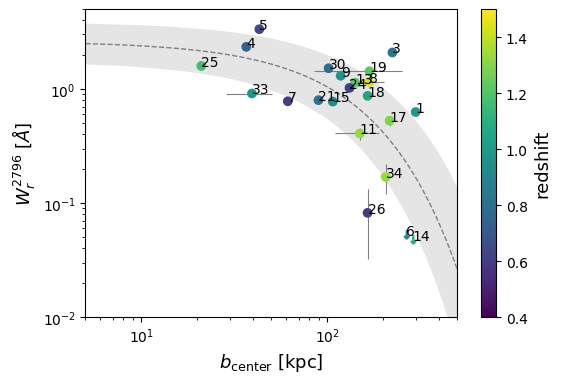

In [511]:
plt.figure(figsize = (6, 4), dpi = 100)
#plt.title("FoF groups ($N >= 5$)")
#plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none')
X = np.linspace(5, 500, 500)
plt.plot(X, 10**(gt.model(fit_bcenter['x'], X)), linewidth = 1.0, c = "gray", label = "best fit", \
         linestyle = "--")
plt.fill_between(X, 10**(gt.model(fit_bcenter_1sig_inf, X)), 10**(gt.model(fit_bcenter_1sig_sup, X)), \
                 color = "gray", alpha = 0.2, linewidth = 0)

plt.errorbar(G4_9_abs["b_center_kpc"], G4_9_abs["REW_2796"], xerr = G4_9_abs["b_center_err"],\
             yerr = G4_9_abs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8, zorder = 1)
plt.scatter(G4_9_abs["b_center_kpc"], G4_9_abs["REW_2796"], marker = "o", \
            c = G4_9_abs["mean_z"], vmin = 0.4, vmax = 1.5, zorder = 2)
cbar = plt.colorbar()
cbar.set_label("redshift", size = 13)
plt.scatter(G4_9_noabs["b_center_kpc"], G4_9_noabs["detection_limit"], marker = "$\downarrow$",\
            c = G4_9_noabs["mean_z"], vmin = 0.4, vmax = 1.5, zorder = 2)
#cbar = plt.colorbar()
#cbar.set_label("$R_{\mathrm{vir}}$ closest [kpc]")

X = np.array(G4_9_abs["b_center_kpc"])
Y = np.array(G4_9_abs["REW_2796"])
txt = np.array(G4_9_abs["ID"])

for i in range(len(G4_9_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G4_9_noabs["b_center_kpc"])
Y = np.array(G4_9_noabs["detection_limit"])
txt = np.array(G4_9_noabs["ID"])

for i in range(len(G4_9_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{\mathrm{center}}$ [kpc]", size = 13)
plt.ylabel("$W_r^{2796}$ $[\AA]$", size = 13)
#plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.xlim((5, 500))
plt.ylim((0.01, 5))

# Normalized by the Rvir of the closest galaxy

In [675]:
x1 = np.array(G4_9_abs["b_min_kpc"]/G4_9_abs["Rvir_closest"])
x2 = np.array(G4_9_noabs["b_min_kpc"]/G4_9_noabs["Rvir_closest"])
y1 = np.array(np.log10(G4_9_abs["REW_2796"]))
y2 = np.array(np.log10(G4_9_noabs["detection_limit"]))
#sig_x1 = np.ones(len(x1))*10
#sig_x2 = np.ones(len(x2))*10
sig_x1 = np.array(G4_9_abs["b_center_err"])
sig_x2 = np.array(G4_9_noabs["b_center_err"])
sig_y1 = np.array(G4_9_abs["sig_REW_2796"]/G4_9_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

In [676]:
#LMG, sig_intr_lst = gt.fit_REW(G4_9, x1, y1, sig_x1, sig_y1, x2, y2, sig_x2, sig_y2,\
#                                Niter = 5, init_param = np.array([0.4,0.09]))
fit_bmin_norm = minimize(gt.logL_stats_total, np.array([0.001,-0.01, 0.2]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_bmin_norm

      fun: 8.047519801159936
 hess_inv: array([[ 0.00985467, -0.00760151,  0.00046453],
       [-0.00760151,  0.01125159, -0.00139039],
       [ 0.00046453, -0.00139039,  0.00271145]])
      jac: array([2.38418579e-07, 9.53674316e-07, 4.76837158e-06])
  message: 'Optimization terminated successfully.'
     nfev: 88
      nit: 18
     njev: 22
   status: 0
  success: True
        x: array([ 0.26727802, -0.55345724,  0.30643939])

In [691]:
fit_bmin_norm_1sig = np.diag(fit_bmin_norm.hess_inv)**0.5
fit_bmin_norm_1sig_inf = fit_bmin_norm['x'] - fit_bmin_norm_1sig
fit_bmin_norm_1sig_sup = fit_bmin_norm['x'] + fit_bmin_norm_1sig
fit_bmin_norm_1sig

array([0.09927069, 0.10607352, 0.0520716 ])

(0.05, 5)

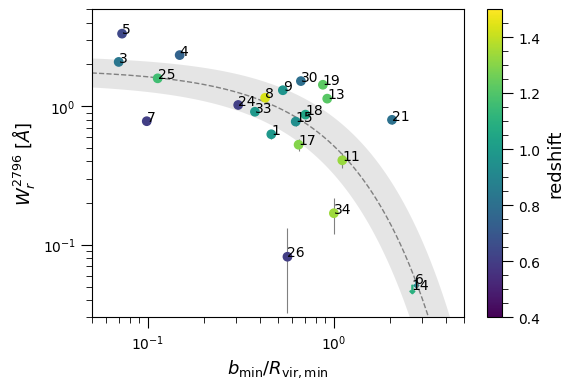

In [678]:
plt.figure(figsize = (6, 4), dpi = 100)
#plt.title("FoF groups ($N >= 5$)")
#plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none')

X = np.linspace(0.05, 5, 500)
plt.plot(X, 10**(gt.model(fit_bmin_norm['x'], X)), linewidth = 1.0, c = "gray", label = "best fit", \
         linestyle = "--")
plt.fill_between(X, 10**(gt.model(fit_bmin_norm_1sig_inf, X)), 10**(gt.model(fit_bmin_norm_1sig_sup, X)), \
                 color = "gray", alpha = 0.2, linewidth = 0)


plt.errorbar(G4_9_abs["b_min_kpc"]/G4_9_abs["Rvir_closest"], G4_9_abs["REW_2796"],\
             yerr = G4_9_abs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8, zorder = 1)
plt.scatter(G4_9_abs["b_min_kpc"]/G4_9_abs["Rvir_closest"], G4_9_abs["REW_2796"], marker = "o", \
            c = G4_9_abs["mean_z"], vmin = 0.4, vmax = 1.5, zorder = 2)
cbar = plt.colorbar()
cbar.set_label("redshift", size = 13)
plt.errorbar(G4_9_noabs["b_min_kpc"]/G4_9_noabs["Rvir_closest"], G4_9_noabs["REW_2796"],\
             yerr = G4_9_noabs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8, zorder = 1)
plt.scatter(G4_9_noabs["b_min_kpc"]/G4_9_noabs["Rvir_closest"], G4_9_noabs["detection_limit"], marker = "$\downarrow$",\
            c = G4_9_noabs["mean_z"], vmin = 0.4, vmax = 1.5)
#cbar = plt.colorbar()
#cbar.set_label("$R_{\mathrm{vir}}$ closest [kpc]")

X = np.array(G4_9_abs["b_min_kpc"]/G4_9_abs["Rvir_closest"])
Y = np.array(G4_9_abs["REW_2796"])
txt = np.array(G4_9_abs["ID"])

for i in range(len(G4_9_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G4_9_noabs["b_min_kpc"]/G4_9_noabs["Rvir_closest"])
Y = np.array(G4_9_noabs["detection_limit"])
txt = np.array(G4_9_noabs["ID"])

for i in range(len(G4_9_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{\mathrm{min}}/R_{\mathrm{vir, min}}$", size = 13)
plt.ylabel("$W_r^{2796}$ $[\AA]$", size = 13)
#plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.ylim((0.03, 5))
plt.xlim((0.05,5))

In [516]:
len(G4_9[G4_9["REW_2796"]>1])

10

# 2D plots

Text(0, 0.5, 'bmin [kpc]')

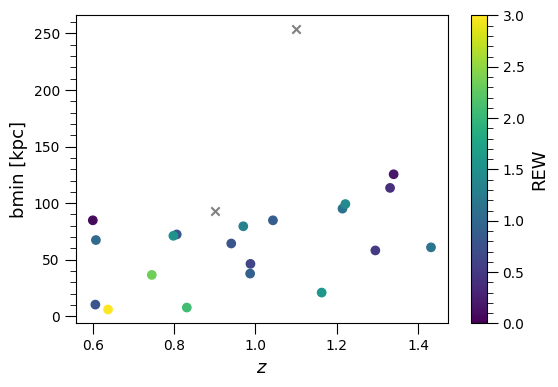

In [687]:
plt.figure(figsize = (6, 4), dpi = 100)
plt.scatter(G4_9_abs["mean_z"], G4_9_abs["b_min_kpc"], marker = "o", \
            c = G4_9_abs["REW_2796"], vmin = 0., vmax = 3, zorder = 2)
cbar = plt.colorbar()
cbar.set_label("REW", size = 13)
plt.scatter(G4_9_noabs["mean_z"], G4_9_noabs["b_min_kpc"], marker = "x", \
            c = "gray")

plt.xlabel("$z$", size = 13)
plt.ylabel("bmin [kpc]", size = 13)
#plt.xscale("log")
#plt.yscale("log")
#plt.ylim((0.03, 5))
#plt.xlim((0.05,5))

Text(0, 0.5, 'bcenter/Rvir')

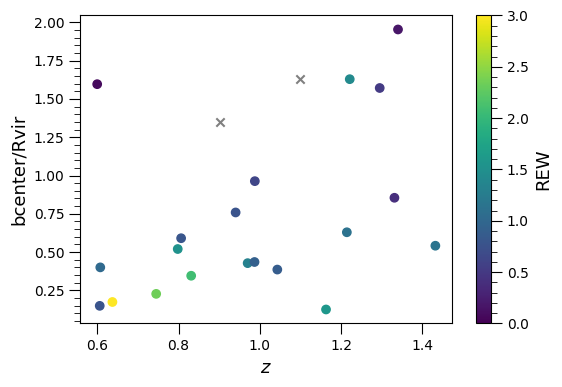

In [688]:
plt.figure(figsize = (6, 4), dpi = 100)
plt.scatter(G4_9_abs["mean_z"], G4_9_abs["b_center_kpc_norm2"], marker = "o", \
            c = G4_9_abs["REW_2796"], vmin = 0., vmax = 3, zorder = 2)
cbar = plt.colorbar()
cbar.set_label("REW", size = 13)
plt.scatter(G4_9_noabs["mean_z"], G4_9_noabs["b_center_kpc_norm2"], marker = "x", \
            c = "gray")

plt.xlabel("$z$", size = 13)
plt.ylabel("bcenter/Rvir", size = 13)
#plt.xscale("log")
#plt.yscale("log")
#plt.ylim((0.03, 5))
#plt.xlim((0.05,5))

Text(0, 0.5, '$W_r^{2796}$ $[\\AA]$')

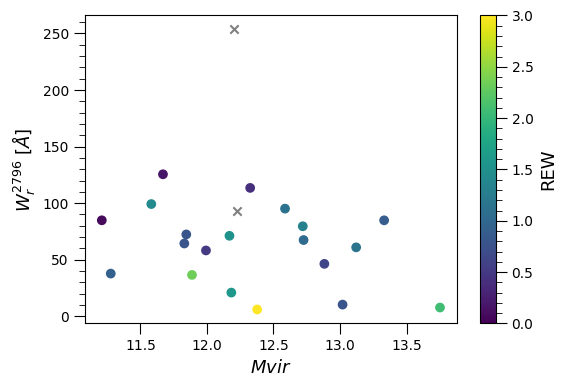

In [686]:
plt.figure(figsize = (6, 4), dpi = 100)
plt.scatter(np.log10(G4_9_abs["Mvir_sigma2"]), G4_9_abs["b_min_kpc"], marker = "o", \
            c = G4_9_abs["REW_2796"], vmin = 0., vmax = 3, zorder = 2)
cbar = plt.colorbar()
cbar.set_label("REW", size = 13)
plt.scatter(np.log10(G4_9_noabs["Mvir_sigma2"]), G4_9_noabs["b_min_kpc"], marker = "x", \
            c = "gray")

plt.xlabel("$Mvir$", size = 13)
plt.ylabel("$bmin [kpc]", size = 13)
#plt.xscale("log")
#plt.yscale("log")
#plt.ylim((0.03, 5))
#plt.xlim((0.05,5))

# Column density

In [812]:
G4_9_abs["NHI"], G4_9_abs["sigma_NHI"] = gt.Fukugita(G4_9_abs["REW_2796"], G4_9_abs["sig_REW_2796"], G4_9_abs["center_z"])
G4_9_abs["NHI_limit"], _ = gt.Fukugita(G4_9_abs["detection_limit"], 1, G4_9_abs["center_z"])
G4_9_noabs["NHI"], G4_9_noabs["sigma_NHI"] = gt.Fukugita(G4_9_noabs["REW_2796"], G4_9_noabs["sig_REW_2796"], G4_9_noabs["center_z"])
G4_9_noabs["NHI_limit"], G4_9_noabs["sigma_NHI"] = gt.Fukugita(G4_9_noabs["detection_limit"], \
                        0.2*G4_9_noabs["detection_limit"], G4_9_noabs["center_z"])

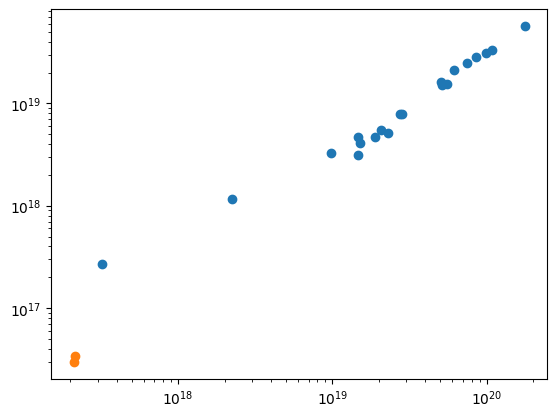

In [813]:
plt.scatter(G4_9_abs["NHI"], G4_9_abs["sigma_NHI"])
plt.scatter(G4_9_noabs["NHI_limit"], G4_9_noabs["sigma_NHI"])
plt.xscale("log")
plt.yscale("log")

In [814]:
G4_9_noabs["sigma_NHI"]

5     2.975192e+16
13    3.373966e+16
Name: sigma_NHI, dtype: float64

We cannot make a single plot with just 2 different y axis (1 for W2796 and 1 for NHI) because the NHI conversion depends on the redshift...

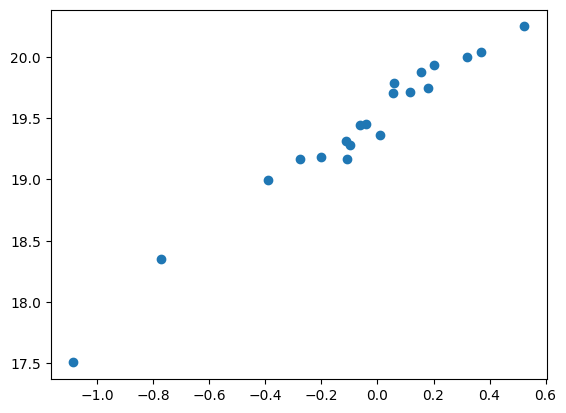

In [815]:
plt.scatter(np.log10(G4_9_abs["REW_2796"]), np.log10(G4_9_abs["NHI"]))

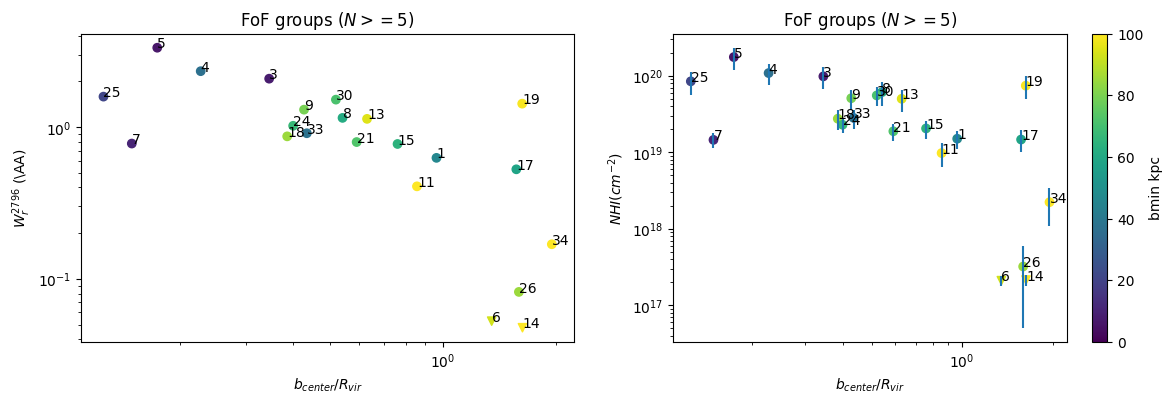

In [816]:
plt.figure(figsize = (14,4))
plt.subplot(121)
plt.title("FoF groups ($N >= 5$)")
##plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none')
plt.scatter(G4_9_abs["b_center_kpc_norm2"], G4_9_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = G4_9_abs["b_min_kpc"], vmin = 0, vmax = 100)
plt.scatter(G4_9_noabs["b_center_kpc_norm2"], G4_9_noabs["detection_limit"], marker = "v", label = "groups N >= 5", \
             c = G4_9_noabs["b_min_kpc"], vmin = 0, vmax = 100)
#plt.colorbar(label = "bmin kpc")

X = np.array(G4_9_abs["b_center_kpc_norm2"])
Y = np.array(G4_9_abs["REW_2796"])
txt = np.array(G4_9_abs["ID"])

for i in range(len(G4_9_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G4_9_noabs["b_center_kpc_norm2"])
Y = np.array(G4_9_noabs["detection_limit"])
txt = np.array(G4_9_noabs["ID"])

for i in range(len(G4_9_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

plt.subplot(122)
plt.title("FoF groups ($N >= 5$)")
plt.errorbar(G4_9_abs["b_center_kpc_norm2"], G4_9_abs["NHI"], yerr = G4_9_abs["sigma_NHI"], fmt = 'none')
plt.scatter(G4_9_abs["b_center_kpc_norm2"], G4_9_abs["NHI"], marker = "o", label = "groups N >= 5", \
            c = G4_9_abs["b_min_kpc"], vmin = 0, vmax = 100)
plt.errorbar(G4_9_noabs["b_center_kpc_norm2"], G4_9_noabs["NHI_limit"], yerr = G4_9_noabs["sigma_NHI"], fmt = 'none')
plt.scatter(G4_9_noabs["b_center_kpc_norm2"], G4_9_noabs["NHI_limit"],\
            marker = "v", label = "groups N >= 5", \
             c = G4_9_noabs["b_min_kpc"], vmin = 0, vmax = 100)
plt.colorbar(label = "bmin kpc")

X = np.array(G4_9_abs["b_center_kpc_norm2"])
Y = np.array(G4_9_abs["NHI"])
txt = np.array(G4_9_abs["ID"])

for i in range(len(G4_9_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G4_9_noabs["b_center_kpc_norm2"])
Y = np.array(G4_9_noabs["NHI_limit"])
txt = np.array(G4_9_noabs["ID"])

for i in range(len(G4_9_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$NHI (cm^{-2})$")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

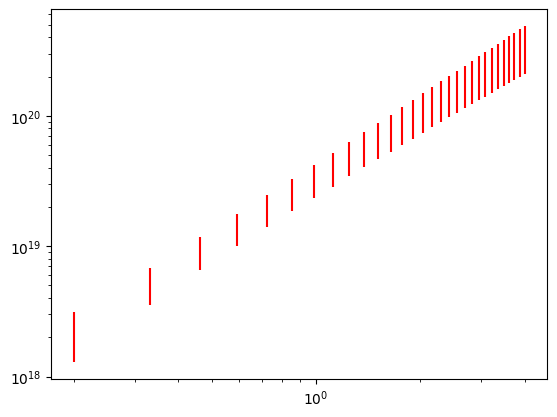

In [817]:
W = np.linspace(0.2, 4, 30)
N, sig = gt.Fukugita(W, 0.05, 1)
#plt.errorbar(G5_abs["REW_2796"], G5_abs["NHI"], yerr = G5_abs["sigma_NHI"], fmt = 'none')
#plt.scatter(G5_abs["REW_2796"], G5_abs["NHI"], c = G5_abs["center_z"])
plt.errorbar(W, N, yerr = sig, fmt = 'none', c = "r")
#plt.scatter(W, N)
#plt.colorbar()
plt.yscale("log")
plt.xscale("log")

# With DM profile

On the NHI vs b plot, we can add the standard NFW DM profile. But we must care about the fact that the NHI is a column density, ie a density integrated along the LOS. In order to compare things consistently, it is necessary to convert NFW density into a column density (a cut is necessary or it will diverge) or alternatively to convert the column density into a density (with a strong assumption of a spherical distribution of NHI?)...

In [523]:
from scipy import integrate

Text(0, 0.5, 'log10(rho)')

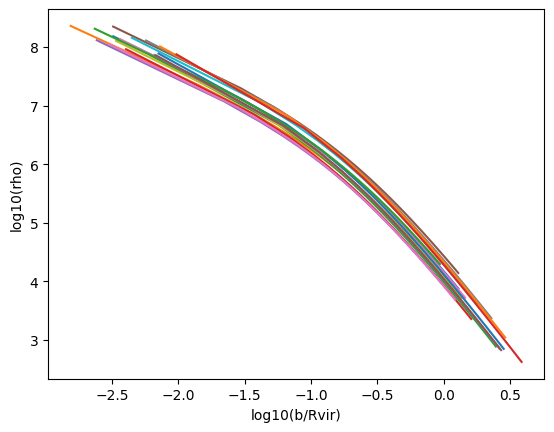

In [524]:
b = np.linspace(1, 400)
rho = gt.nfw_rho(b, 2e6, 30)
rvir = G5_abs["Mvir_sigma2"]
mvir = G5_abs["Mvir_sigma2"]

for i, g in G5_abs.iterrows():
    r = g["Rvir_sigma2"]
    m = g["Mvir_sigma2"]
    z = g["center_z"]
    rho0, rs = gt.get_nfw_param(m, z)
    rho = gt.nfw_rho(b, rho0, rs)
    plt.plot(np.log10(b/r), np.log10(rho))
plt.xlabel("log10(b/Rvir)")
plt.ylabel("log10(rho)")

In [525]:
def nfw_rho_2(theta, b, rhoO, rs):
    K = b/np.cos(theta)/rs
    D = K*(1+K)**2
    rho = rho0*b/D/((np.cos(theta))**2)
    return rho

## Now with the equation from Bartelmann 1996:

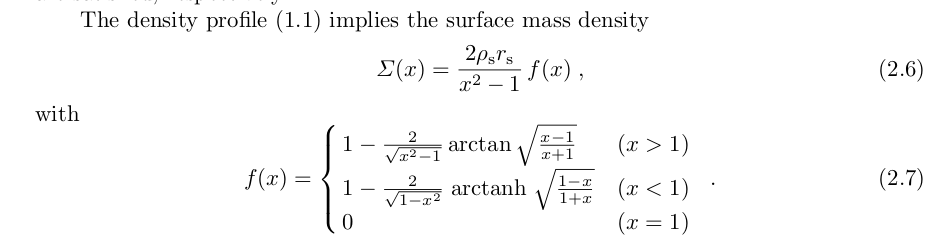

In [526]:
def calc_sigma_DM(r, rhos, rs):
    x = r/rs
    Sigma = 2* rhos*rs*ff(x)/(x**2-1)
    return Sigma

def ff(x):
    if x> 1: return (1-2*np.arctan(((x-1)/(x+1))**0.5)/((x**2-1)**0.5))
    elif x<1: return (1-2*np.arctanh(((1-x)/(x+1))**0.5)/((1-x**2)**0.5))
    elif x == 1: return 0
        

In [527]:
b = np.linspace(10, 600, 100)
mvir = 1e12
z = 1
rvir = gt.get_Rvir(mvir, z)
rho0, rs = gt.get_nfw_param(mvir, z)
rvir

156.28710893311342

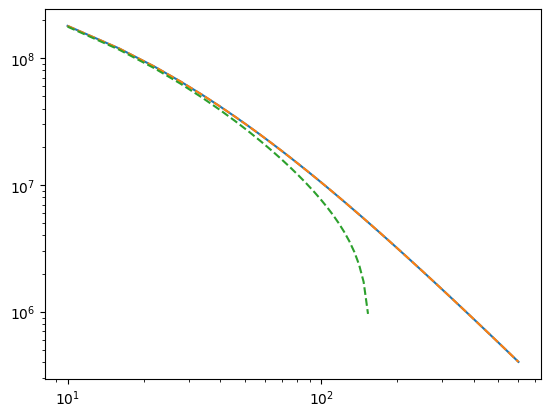

In [528]:
sig_dm = []
rho_column = []
rho_trunc = []
for bb in b:
    sig_dm.append(calc_sigma_DM(bb, rho0, rs))
    I = integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (bb, rho0, rs))
    rho_column.append(float(I[0]))
    theta_lim = np.arccos(bb/rvir)
    I2 = integrate.quad(nfw_rho_2, -theta_lim, theta_lim, args = (bb, rho0, rs))
    rho_trunc.append(float(I2[0]))
sig_dm = np.array(sig_dm)
rho_column = np.array(rho_column)
rho_trunc = np.array(rho_trunc)

plt.loglog(b, sig_dm) # Bartelmann
plt.loglog(b, rho_column, linestyle = "--") # numerically integrated
plt.loglog(b, rho_trunc, linestyle = "--")

#### for a truncated NFW profile:

In [529]:
K= (1.66054e-27*u.kg/(u.cm**2)).to(u.kg/(u.kpc**2))
print(K)
K = K/const.M_sun
K

1.5810675746598502e+16 kg / kpc2


<Quantity 7.95141685e-15 1 / kpc2>

In [530]:
convert1 = ((const.M_sun/((1*u.kpc)**2)).to(u.kg/((u.cm)**2))).value
convert1

2.0883573729600368e-13

156.28710893311342 3346226.7715142868 28.545636311349668


(1e-10, 1e-06)

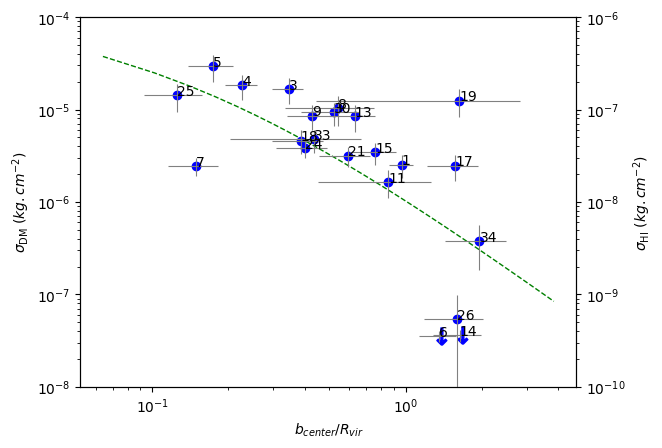

In [531]:

fig, ax1 = plt.subplots()
#plt.title("FoF groups ($N >= 5$)")
b = np.linspace(10, 600, 100)
mvir = 1e12
z = 1
rvir = gt.get_Rvir(mvir, z)
rho0, rs = gt.get_nfw_param(mvir, z)
print(rvir, rho0, rs)
rho = gt.nfw_rho(b, rho0, rs)
rho_column = []
for bb in b:
    I = integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (bb, rho0, rs))
    rho_column.append(float(I[0]))
#plt.plot(np.log10(b/r), np.log10(rho))
#plt.plot(np.log10(b/r), np.log10(rho_column))
#plt.plot(b/rvir, rho, linestyle = "--", color = "gray", linewidth = 1, label = "rho column")
rho_column = np.array(rho_column)

convert1 = ((const.M_sun/((1*u.kpc)**2)).to(u.kg/((u.cm)**2))).value

plt.plot(b/rvir, rho_column*convert1, linestyle = "--", color = "green", linewidth = 1)
#plt.plot(b/rvir, sig_dm*convert1, linestyle = "-", color = "red", linewidth = 1)
plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$\sigma_{\mathrm{DM}}$ $(kg.cm^{-2})$")
#plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-8, 1e-4))

    
# -----------------------------------------------------------------------

u_to_kg = 1.67355755e-27

ax2 = ax1.twinx()
NHI_abs = G4_9_abs["NHI"]*u_to_kg
NHI_abs_sigma = G4_9_abs["sigma_NHI"]*u_to_kg
NHI_noabs = G4_9_noabs["NHI_limit"]*u_to_kg
NHI_noabs_sigma = G4_9_noabs["sigma_NHI"]*u_to_kg

ax2.errorbar(G4_9_abs["b_center_kpc_norm2"], NHI_abs, xerr = G4_9_abs["b_center_kpc_norm2_err"], yerr =NHI_abs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8)
ax2.scatter(G4_9_abs["b_center_kpc_norm2"], NHI_abs, marker = "o", label = "groups N >= 5", \
            c = "blue")
#plt.colorbar(label = "log($M/M_{\odot}$)")

ax2.errorbar(G4_9_noabs["b_center_kpc_norm2"], NHI_noabs, xerr = G4_9_noabs["b_center_kpc_norm2_err"], yerr = NHI_noabs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8)
ax2.scatter(G4_9_noabs["b_center_kpc_norm2"], NHI_noabs,\
            marker = "$\downarrow$", s = 150, label = "groups N >= 5", \
             c = "blue")
#plt.colorbar(label = "bmin kpc")

X = np.array(G4_9_abs["b_center_kpc_norm2"])
Y = np.array(G4_9_abs["NHI"]*u_to_kg)
txt = np.array(G4_9_abs["ID"])

for i in range(len(G4_9_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G4_9_noabs["b_center_kpc_norm2"])
Y = np.array(G4_9_noabs["NHI_limit"])*u_to_kg
txt = np.array(G4_9_noabs["ID"])

for i in range(len(G4_9_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.ylabel("$\sigma_{\mathrm{HI}}$ $(kg.cm^{-2})$")

plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-10, 1e-6))

In [532]:
x1 = np.array(G4_9_abs["b_center_kpc_norm2"])
x2 = np.array(G4_9_noabs["b_center_kpc_norm2"])
y1 = np.array(np.log10(NHI_abs))
y2 = np.array(np.log10(NHI_noabs))
sig_x1 = np.array(G4_9_abs["b_center_kpc_norm2_err"])
sig_x2 = np.array(G4_9_noabs["b_center_kpc_norm2_err"])
sig_y1 = np.array(NHI_abs_sigma/NHI_abs/np.log(10))
sig_y2 = np.array(NHI_noabs_sigma/NHI_noabs/np.log(10))

N =  0
1.1792782640148631
N =  1
0.3210380989486224
N =  2
0.24831970903276104
N =  3
0.2631492744641052
N =  4
0.25842506947712535
N =  5
0.2598995661733165
N =  6
0.2594361039874201
N =  7
0.259581483164493
N =  8
0.2595358619973192
N =  9
0.2595501711214048


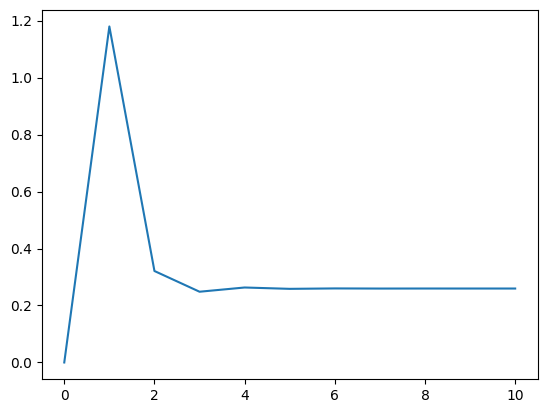

In [533]:
LMG, sig_intr_lst = gt.fit_REW(G4_9, x1, y1, sig_x1, sig_y1, x2, y2, sig_x2, sig_y2,\
                                Niter = 10, init_param = np.array([-7,-2]))

In [534]:
LMG

      fun: 19.44116716121896
 hess_inv: array([[ 0.0140379 , -0.0176847 ],
       [-0.0176847 ,  0.03860572]])
      jac: array([-1.66893005e-06, -1.19209290e-06])
  message: 'Optimization terminated successfully.'
     nfev: 39
      nit: 10
     njev: 13
   status: 0
  success: True
        x: array([-6.40968188, -1.78001253])

In [535]:
LMG_1sig = np.diag(LMG.hess_inv)**0.5
LMG_1sig_inf = LMG['x'] - LMG_1sig
LMG_1sig_sup = LMG['x'] + LMG_1sig

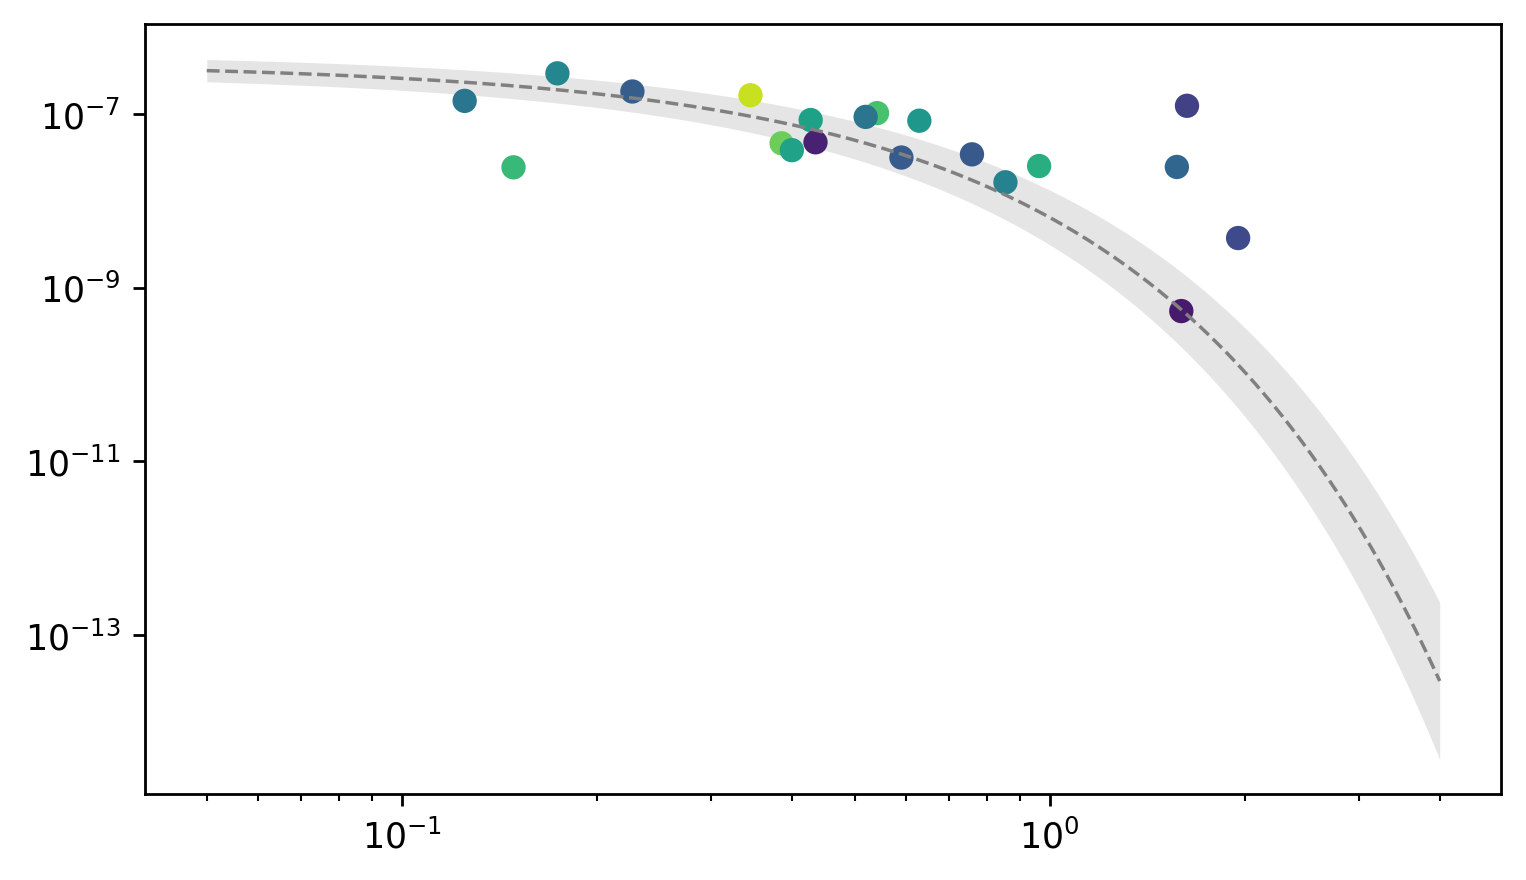

In [536]:
plt.figure(figsize = (7,4), dpi = 250)
X = np.linspace(0.05, 4, 500)
plt.plot(X, 10**(gt.model(LMG['x'], X)), linewidth = 1.0, c = "gray", label = "best fit", \
         linestyle = "--")
plt.fill_between(X, 10**(gt.model(LMG_1sig_inf, X)), 10**(gt.model(LMG_1sig_sup, X)), \
                 color = "gray", alpha = 0.2, linewidth = 0)

plt.scatter(G4_9_abs["b_center_kpc_norm2"], NHI_abs, marker = "o", label = "groups N >= 5", \
            c = np.log10(G4_9_abs["Mvir_sigma2"]), vmin = 11, vmax = 14)
plt.xscale("log")
plt.yscale("log")

N = 5
sigma_intrinsic_start = 0
sigma_intrinsic = sigma_intrinsic_start
sigma_intrisic_list = [sigma_intrinsic]

for i in range(N):
    print("N = ", i)
    sig_y1_mi = np.array(NHI_abs_sigma/NHI_abs)
    sig_y1 = (sig_y1_mi**2 + sigma_intrinsic**2)**0.5
    LL_model_Hogg_total = minimize(logL_Hogg_total, np.array([-15,-4]), method='BFGS')
    print(LL_model_Hogg_total['x'])
    sigma_intrinsic = calc_sigma_intrisic(y1, model(LL_model_Hogg_total['x'], x1), sig_y1_mi)
    print(sigma_intrinsic)
    sigma_intrisic_list.append(sigma_intrinsic)

In [818]:
from colossus.cosmology import cosmology
from colossus.halo import profile_nfw
from colossus.halo import profile_einasto
from colossus.halo import profile_diemer22
from colossus.halo import profile_outer
from colossus.halo import profile_composite
from colossus.lss import bias
cosmo = cosmology.setCosmology('planck18')

In [819]:
np.log10(np.median(G4_9["Mvir_sigma2"]))

12.215826525467802

In [539]:
b = np.linspace(10, 10000, 500)
Mvir = 10**(12.35)
z = 1
bs = bias.haloBias(Mvir, z, 'vir')
rho_m = cosmo.rho_m(z)  #in M⊙h2/kpc3
h = cosmo.H0/100
#rho_nfw = p_nfw.density(r)
rvir = gt.get_Rvir(mvir, z)
rho0, rs = gt.get_nfw_param(mvir, z)
cvir = c = rvir/rs
kwargs = dict(M = Mvir, c = cvir, z = z, mdef = 'vir')
p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')
p_mean = profile_composite.compositeProfile('nfw', outer_names = ['mean'], **kwargs)
p_cf = profile_composite.compositeProfile('nfw', outer_names = ['mean', 'cf'], bias = bs, **kwargs) 
p_inf = profile_composite.compositeProfile('nfw', outer_names = ['mean', 'infalling'], \
                                           pl_delta_1 = 10.0, pl_s = 1.4, **kwargs)
d22_mean = profile_composite.compositeProfile('diemer22', outer_names = ['mean'],**kwargs)
d22_inf = profile_composite.compositeProfile('diemer22', outer_names = ['mean', 'infalling'], \
                                              pl_delta_1 = 10.0, pl_s = 1.4, **kwargs)
#d22_inf = profile_composite.compositeProfile('diemer22', outer_names = ['mean', 'infalling'], **kwargs)



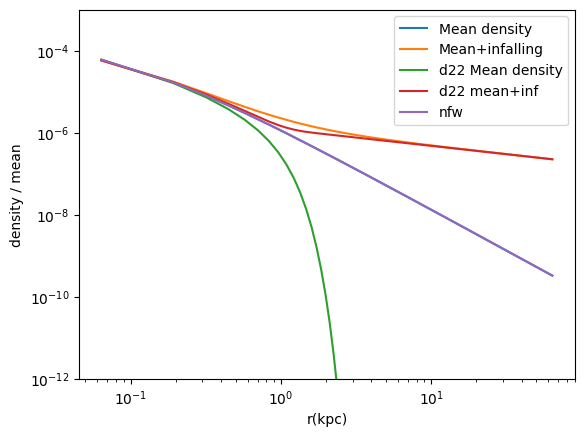

In [540]:
#r = 10**np.arange(0,5,0.02)
#r = r*h
surf_dens_nfw = p_nfw.surfaceDensity(b/h) #M⊙h/kpc2
surf_dens_nfw = surf_dens_nfw*const.M_sun.value/(const.kpc.to(u.cm).value**2)
surf_dens = p_mean.surfaceDensity(b/h) #M⊙h/kpc2
surf_dens = surf_dens*const.M_sun.value/(const.kpc.to(u.cm).value**2)
#surf_dens_cf = p_cf.surfaceDensity(b/h) #M⊙h/kpc2
#surf_dens_cf = surf_dens_cf*const.M_sun.value/(const.kpc.to(u.cm).value**2)
surf_dens_pinf = p_inf.surfaceDensity(b/h) #M⊙h/kpc2
surf_dens_pinf = surf_dens_pinf*const.M_sun.value/(const.kpc.to(u.cm).value**2)
surf_dens_d22 = d22_mean.surfaceDensity(b/h) #M⊙h/kpc2
surf_dens_d22 = surf_dens_d22*const.M_sun.value/(const.kpc.to(u.cm).value**2)
surf_dens_d22_inf = d22_inf.surfaceDensity(b/h) #M⊙h/kpc2
surf_dens_d22_inf = surf_dens_d22_inf*const.M_sun.value/(const.kpc.to(u.cm).value**2)


plt.figure()
plt.loglog()
plt.xlabel('r(kpc)')
plt.ylabel('density / mean')
plt.plot(b/rvir, surf_dens, '-', label = 'Mean density');
#plt.plot(b/rvir, surf_dens_cf, '-', label = 'Mean+corrfunc');
plt.plot(b/rvir, surf_dens_pinf, '-', label = 'Mean+infalling');
plt.plot(b/rvir, surf_dens_d22, '-', label = 'd22 Mean density');
plt.plot(b/rvir, surf_dens_d22_inf, '-', label = 'd22 mean+inf');
plt.plot(b/rvir, surf_dens_nfw, '-', label = 'nfw');
plt.ylim(1e-12, 1e-3)
plt.legend();

156.28710893311342 3346226.7715142868 28.545636311349668


(0.07, 3)

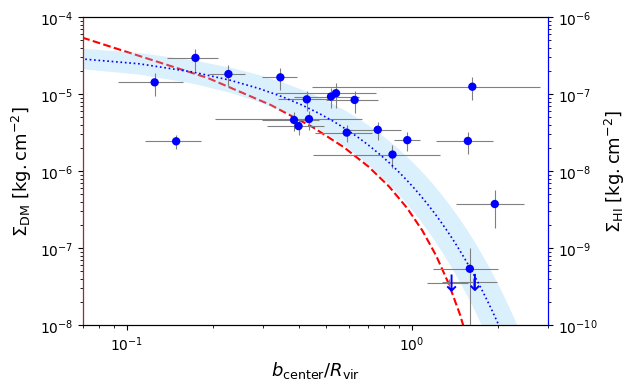

In [541]:
#plt.figure(dpi = 250)

fig, ax1 = plt.subplots(figsize = (6,4))
fig.dpi = 100
#plt.title("FoF groups ($N >= 5$)")
rvir = gt.get_Rvir(mvir, z)
rho0, rs = gt.get_nfw_param(mvir, z)
print(rvir, rho0, rs)
rho = gt.nfw_rho(b, rho0, rs)
rho_column = []
rho_trunc = []
for bb in b:
    I = integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (bb, rho0, rs))
    rho_column.append(float(I[0]))
    theta_lim = np.arccos(bb/rvir)
    I2 = integrate.quad(nfw_rho_2, -theta_lim, theta_lim, args = (bb, rho0, rs))
    rho_trunc.append(float(I2[0]))
#plt.plot(np.log10(b/r), np.log10(rho))
#plt.plot(np.log10(b/r), np.log10(rho_column))
#plt.plot(b/rvir, rho, linestyle = "--", color = "gray", linewidth = 1, label = "rho column")
rho_column = np.array(rho_column)
rho_trunc = np.array(rho_trunc)

convert1 = ((const.M_sun/((1*u.kpc)**2)).to(u.kg/((u.cm)**2))).value

#plt.plot(b/rvir, rho_column*convert1, linestyle = "-", color = "red", linewidth = 1, label = "$\sigma_{NFW}$")
#plt.plot(b/rvir, rho_trunc*convert1, linestyle = "-", color = "orange", linewidth = 1, label = "$\sigma_{NFW} trunc$")
plt.plot(b/rvir, surf_dens_d22, '--', color = "red", label = "Diemer+22", zorder = 1);

#plt.plot(b/rvir, sig_dm*convert1, linestyle = "-", color = "red", linewidth = 1)
plt.xlabel("$b_{\mathrm{center}}/R_{\mathrm{vir}}$", size = 13)
plt.ylabel("$\Sigma_{\mathrm{DM}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)
#plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-8, 1e-4))

    
# -----------------------------------------------------------------------

u_to_kg = 1.67355755e-27

ax2 = ax1.twinx()
NHI_abs = G4_9_abs["NHI"]*u_to_kg
NHI_abs_sigma = G4_9_abs["sigma_NHI"]*u_to_kg
NHI_noabs = G4_9_noabs["NHI_limit"]*u_to_kg
NHI_noabs_sigma = G4_9_noabs["sigma_NHI"]*u_to_kg


X = np.linspace(0.05, 3, 50)
ax2.plot(X, 10**(gt.model(LMG['x'], X)), linewidth = 1.2, c = "blue", \
         linestyle = "dotted")
ax2.fill_between(X, 10**(gt.model(LMG_1sig_inf, X)), 10**(gt.model(LMG_1sig_sup, X)), \
                 color = "lightskyblue", alpha = 0.3, linewidth = 0)
ax2.plot([0], [0], '--', color = "red", label = "Diemer+22");


ax2.errorbar(G4_9_abs["b_center_kpc_norm2"], NHI_abs, xerr = G4_9_abs["b_center_kpc_norm2_err"], yerr = NHI_abs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8, zorder = 1)
ax2.scatter(G4_9_abs["b_center_kpc_norm2"], NHI_abs, marker = "o", \
            c = "blue", alpha = 1, edgecolors = "none", zorder = 2)
#plt.colorbar(label = "log($M/M_{\odot}$)")

ax2.errorbar(G4_9_noabs["b_center_kpc_norm2"], NHI_noabs, xerr = G4_9_noabs["b_center_kpc_norm2_err"],\
             yerr = NHI_noabs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8, zorder = 1)
ax2.scatter(G4_9_noabs["b_center_kpc_norm2"], NHI_noabs,\
            marker = "$\downarrow$", s = 150, \
             c = "blue", alpha = 1, edgecolors = "none", zorder = 2)


#plt.plot(b/rvir, surf_dens_d22_inf, '--', color = "pink", label = "Diemer+22");

#plt.legend(fontsize = 12)
#plt.colorbar(label = "bmin kpc")

X = np.array(G4_9_abs["b_center_kpc_norm2"])
Y = np.array(G4_9_abs["NHI"]*u_to_kg)
txt = np.array(G4_9_abs["ID"])

#for i in range(len(G5_abs)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G4_9_noabs["b_center_kpc_norm2"])
Y = np.array(G4_9_noabs["NHI_limit"])*u_to_kg
txt = np.array(G4_9_noabs["ID"])

#for i in range(len(G5_noabs)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.ylabel("$\Sigma_{\mathrm{HI}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)


ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('blue')

plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-10, 1e-6))
plt.xlim((0.07, 3))

# DM profile comparison 1 by 1

In [824]:
b = np.linspace(10, 10000, 500)
h = cosmo.H0/100

DM_surf_dens_d22 = []
DM_surf_dens_d22_inf = []
DM_surf_dens_nfw = []

for i, g in G4_9.iterrows():
    b = g["b_min_kpc"]
    rvir = gt.get_Rvir(g["Mvir_sigma2"], g["mean_z"])
    rho0, rs = gt.get_nfw_param(g["Mvir_sigma2"], g["mean_z"])
    cvir = rvir/rs
    kwargs = dict(M = g["Mvir_sigma2"], c = cvir, z = g["mean_z"], mdef = 'vir')
    p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = g["mean_z"], mdef = 'vir')
    p_mean = profile_composite.compositeProfile('nfw', outer_names = ['mean'], **kwargs)
    #p_cf = profile_composite.compositeProfile('nfw', outer_names = ['mean', 'cf'], bias = bs, **kwargs) 
    p_inf = profile_composite.compositeProfile('nfw', outer_names = ['mean', 'infalling'], \
                                               pl_delta_1 = 10.0, pl_s = 1.4, **kwargs)
    d22_mean = profile_composite.compositeProfile('diemer22', outer_names = ['mean'],**kwargs)
    d22_inf = profile_composite.compositeProfile('diemer22', outer_names = ['mean', 'infalling'], \
                                              pl_delta_1 = 10.0, pl_s = 1.4, **kwargs)
    d22_mean = profile_composite.compositeProfile('diemer22', outer_names = ['mean'],**kwargs)

    
    surf_dens_nfw = p_nfw.surfaceDensity(b/h) #M⊙h/kpc2
    surf_dens_nfw = surf_dens_nfw*const.M_sun.value/(const.kpc.to(u.cm).value**2)
    surf_dens = p_mean.surfaceDensity(b/h) #M⊙h/kpc2
    surf_dens = surf_dens*const.M_sun.value/(const.kpc.to(u.cm).value**2)
    surf_dens_pinf = p_inf.surfaceDensity(b/h) #M⊙h/kpc2
    surf_dens_pinf = surf_dens_pinf*const.M_sun.value/(const.kpc.to(u.cm).value**2)
    surf_dens_d22 = d22_mean.surfaceDensity(b/h) #M⊙h/kpc2
    surf_dens_d22 = surf_dens_d22*const.M_sun.value/(const.kpc.to(u.cm).value**2)
    surf_dens_d22_inf = d22_inf.surfaceDensity(b/h) #M⊙h/kpc2
    surf_dens_d22_inf = surf_dens_d22_inf*const.M_sun.value/(const.kpc.to(u.cm).value**2)
    
    DM_surf_dens_d22.append(surf_dens_d22)
    DM_surf_dens_d22_inf.append(surf_dens_d22_inf)
    DM_surf_dens_nfw.append(surf_dens_nfw)

G4_9["DM_surf_dens_d22"] = np.array(DM_surf_dens_d22)
G4_9["DM_surf_dens_d22_inf"] = np.array(DM_surf_dens_d22_inf)
G4_9["DM_surf_dens_nfw"] = np.array(DM_surf_dens_nfw)

(0.07, 3)

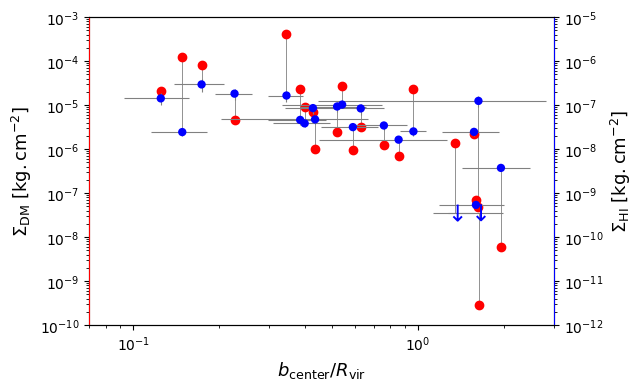

In [872]:
#plt.figure(dpi = 250)

fig, ax1 = plt.subplots(figsize = (6,4))
fig.dpi = 100

convert1 = ((const.M_sun/((1*u.kpc)**2)).to(u.kg/((u.cm)**2))).value

#plt.plot(b/rvir, rho_column*convert1, linestyle = "-", color = "red", linewidth = 1, label = "$\sigma_{NFW}$")
#plt.plot(b/rvir, rho_trunc*convert1, linestyle = "-", color = "orange", linewidth = 1, label = "$\sigma_{NFW} trunc$")
#plt.plot(b/rvir, surf_dens_d22, '--', color = "red", label = "Diemer+22", zorder = 1);
plt.scatter(G4_9["b_center_kpc_norm2"], G4_9["DM_surf_dens_d22"],\
         color = "red", label = "Diemer+22", zorder = 1);
plt.vlines(G4_9_abs["b_center_kpc_norm2"],G4_9_abs["NHI"]*u_to_kg*100, G4_9_abs["DM_surf_dens_d22"], zorder = 0, \
          color = "gray", linewidth = 0.6)
plt.vlines(G4_9_noabs["b_center_kpc_norm2"],G4_9_noabs["NHI_limit"]*u_to_kg*100, G4_9_noabs["DM_surf_dens_d22"], \
           zorder = 0, color = "gray", linewidth = 0.6)

#plt.plot(b/rvir, sig_dm*convert1, linestyle = "-", color = "red", linewidth = 1)
plt.xlabel("$b_{\mathrm{center}}/R_{\mathrm{vir}}$", size = 13)
plt.ylabel("$\Sigma_{\mathrm{DM}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)
#plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-10, 1e-3))

    
# -----------------------------------------------------------------------

u_to_kg = 1.67355755e-27

ax2 = ax1.twinx()
NHI_abs = G4_9_abs["NHI"]*u_to_kg
NHI_abs_sigma = G4_9_abs["sigma_NHI"]*u_to_kg
NHI_noabs = G4_9_noabs["NHI_limit"]*u_to_kg
NHI_noabs_sigma = G4_9_noabs["sigma_NHI"]*u_to_kg


X = np.linspace(0.05, 3, 50)
ax2.plot(X, 10**(gt.model(LMG['x'], X)), linewidth = 1.2, c = "blue", \
         linestyle = "dotted")
ax2.fill_between(X, 10**(gt.model(LMG_1sig_inf, X)), 10**(gt.model(LMG_1sig_sup, X)), \
                 color = "lightskyblue", alpha = 0.3, linewidth = 0)
ax2.plot([0], [0], '--', color = "red", label = "Diemer+22");


ax2.errorbar(G4_9_abs["b_center_kpc_norm2"], NHI_abs, xerr = G4_9_abs["b_center_kpc_norm2_err"], yerr = NHI_abs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8, zorder = 1)
ax2.scatter(G4_9_abs["b_center_kpc_norm2"], NHI_abs, marker = "o", \
            c = "blue", alpha = 1, edgecolors = "none", zorder = 2)
#plt.colorbar(label = "log($M/M_{\odot}$)")

ax2.errorbar(G4_9_noabs["b_center_kpc_norm2"], NHI_noabs, xerr = G4_9_noabs["b_center_kpc_norm2_err"],\
             yerr = NHI_noabs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8, zorder = 1)
ax2.scatter(G4_9_noabs["b_center_kpc_norm2"], NHI_noabs,\
            marker = "$\downarrow$", s = 150, \
             c = "blue", alpha = 1, edgecolors = "none", zorder = 2)


plt.ylabel("$\Sigma_{\mathrm{HI}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)


ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('blue')

plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-12, 1e-5))
plt.xlim((0.07, 3))

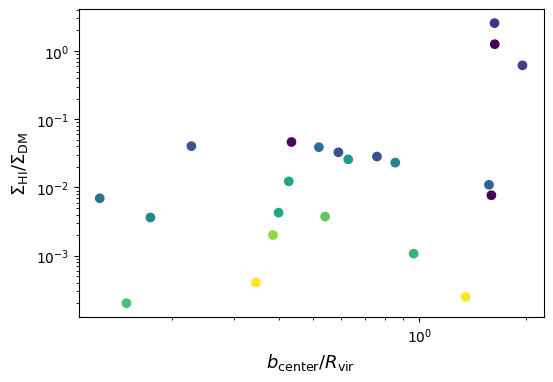

In [882]:
#plt.figure(dpi = 250)

fig, ax1 = plt.subplots(figsize = (6,4))
fig.dpi = 100

convert1 = ((const.M_sun/((1*u.kpc)**2)).to(u.kg/((u.cm)**2))).value

#plt.plot(b/rvir, rho_column*convert1, linestyle = "-", color = "red", linewidth = 1, label = "$\sigma_{NFW}$")
#plt.plot(b/rvir, rho_trunc*convert1, linestyle = "-", color = "orange", linewidth = 1, label = "$\sigma_{NFW} trunc$")
#plt.plot(b/rvir, surf_dens_d22, '--', color = "red", label = "Diemer+22", zorder = 1);
plt.scatter(G4_9_abs["b_center_kpc_norm2"], G4_9_abs["NHI"]*u_to_kg/G4_9_abs["DM_surf_dens_d22"],\
         c = np.log10(G4_9_abs["Mvir_sigma2"]), label = "Diemer+22", zorder = 1);
plt.scatter(G4_9_noabs["b_center_kpc_norm2"], G4_9_noabs["NHI_limit"]*u_to_kg/G4_9_noabs["DM_surf_dens_d22"],\
         c = np.log10(G4_9_noabs["Mvir_sigma2"]), label = "Diemer+22", zorder = 1);

#plt.plot(b/rvir, sig_dm*convert1, linestyle = "-", color = "red", linewidth = 1)
plt.xlabel("$b_{\mathrm{center}}/R_{\mathrm{vir}}$", size = 13)
plt.ylabel("$\Sigma_{\mathrm{HI}} / \Sigma_{\mathrm{DM}}$", size = 13)
#plt.legend()
plt.xscale("log")
plt.yscale("log")
#plt.ylim((1e-10, 1e-3))


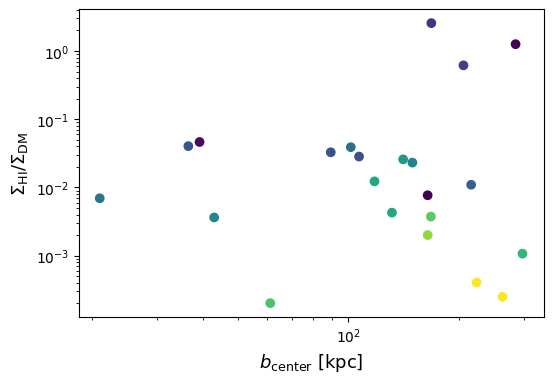

In [883]:
#plt.figure(dpi = 250)

fig, ax1 = plt.subplots(figsize = (6,4))
fig.dpi = 100

convert1 = ((const.M_sun/((1*u.kpc)**2)).to(u.kg/((u.cm)**2))).value

#plt.plot(b/rvir, rho_column*convert1, linestyle = "-", color = "red", linewidth = 1, label = "$\sigma_{NFW}$")
#plt.plot(b/rvir, rho_trunc*convert1, linestyle = "-", color = "orange", linewidth = 1, label = "$\sigma_{NFW} trunc$")
#plt.plot(b/rvir, surf_dens_d22, '--', color = "red", label = "Diemer+22", zorder = 1);
plt.scatter(G4_9_abs["b_center_kpc"], G4_9_abs["NHI"]*u_to_kg/G4_9_abs["DM_surf_dens_d22"],\
         c = np.log10(G4_9_abs["Mvir_sigma2"]), label = "Diemer+22", zorder = 1);
plt.scatter(G4_9_noabs["b_center_kpc"], G4_9_noabs["NHI_limit"]*u_to_kg/G4_9_noabs["DM_surf_dens_d22"],\
         c = np.log10(G4_9_noabs["Mvir_sigma2"]), label = "Diemer+22", zorder = 1);

#plt.plot(b/rvir, sig_dm*convert1, linestyle = "-", color = "red", linewidth = 1)
plt.xlabel("$b_{\mathrm{center}}$ [kpc]", size = 13)
plt.ylabel("$\Sigma_{\mathrm{HI}} / \Sigma_{\mathrm{DM}}$", size = 13)
#plt.legend()
plt.xscale("log")
plt.yscale("log")
#plt.ylim((1e-10, 1e-3))


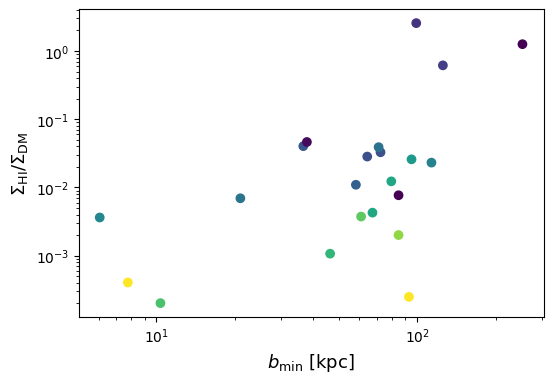

In [884]:
#plt.figure(dpi = 250)

fig, ax1 = plt.subplots(figsize = (6,4))
fig.dpi = 100

convert1 = ((const.M_sun/((1*u.kpc)**2)).to(u.kg/((u.cm)**2))).value

#plt.plot(b/rvir, rho_column*convert1, linestyle = "-", color = "red", linewidth = 1, label = "$\sigma_{NFW}$")
#plt.plot(b/rvir, rho_trunc*convert1, linestyle = "-", color = "orange", linewidth = 1, label = "$\sigma_{NFW} trunc$")
#plt.plot(b/rvir, surf_dens_d22, '--', color = "red", label = "Diemer+22", zorder = 1);
plt.scatter(G4_9_abs["b_min_kpc"], G4_9_abs["NHI"]*u_to_kg/G4_9_abs["DM_surf_dens_d22"],\
         c = np.log10(G4_9_abs["Mvir_sigma2"]), label = "Diemer+22", zorder = 1);
plt.scatter(G4_9_noabs["b_min_kpc"], G4_9_noabs["NHI_limit"]*u_to_kg/G4_9_noabs["DM_surf_dens_d22"],\
         c = np.log10(G4_9_noabs["Mvir_sigma2"]), label = "Diemer+22", zorder = 1);

#plt.plot(b/rvir, sig_dm*convert1, linestyle = "-", color = "red", linewidth = 1)
plt.xlabel("$b_{\mathrm{min}}$ [kpc]", size = 13)
plt.ylabel("$\Sigma_{\mathrm{HI}} / \Sigma_{\mathrm{DM}}$", size = 13)
#plt.legend()
plt.xscale("log")
plt.yscale("log")
#plt.ylim((1e-10, 1e-3))


(1e-12, 1e-05)

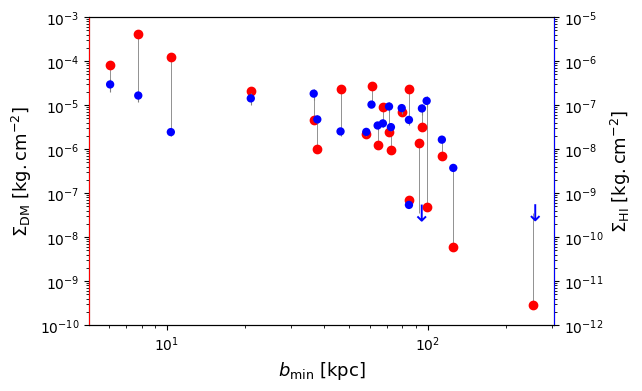

In [873]:
#plt.figure(dpi = 250)

fig, ax1 = plt.subplots(figsize = (6,4))
fig.dpi = 100

convert1 = ((const.M_sun/((1*u.kpc)**2)).to(u.kg/((u.cm)**2))).value

#plt.plot(b/rvir, rho_column*convert1, linestyle = "-", color = "red", linewidth = 1, label = "$\sigma_{NFW}$")
#plt.plot(b/rvir, rho_trunc*convert1, linestyle = "-", color = "orange", linewidth = 1, label = "$\sigma_{NFW} trunc$")
#plt.plot(b/rvir, surf_dens_d22, '--', color = "red", label = "Diemer+22", zorder = 1);
plt.scatter(G4_9["b_min_kpc"], G4_9["DM_surf_dens_d22"],\
         color = "red", label = "Diemer+22", zorder = 1);
plt.vlines(G4_9_abs["b_min_kpc"],G4_9_abs["NHI"]*u_to_kg*100, G4_9_abs["DM_surf_dens_d22"], zorder = 0, \
          color = "gray", linewidth = 0.6)
plt.vlines(G4_9_noabs["b_min_kpc"],G4_9_noabs["NHI_limit"]*u_to_kg*100, G4_9_noabs["DM_surf_dens_d22"], \
           zorder = 0, color = "gray", linewidth = 0.6)

#plt.plot(b/rvir, sig_dm*convert1, linestyle = "-", color = "red", linewidth = 1)
plt.xlabel("$b_{\mathrm{min}}$ [kpc]", size = 13)
plt.ylabel("$\Sigma_{\mathrm{DM}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)
#plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-10, 1e-3))

    
# -----------------------------------------------------------------------

u_to_kg = 1.67355755e-27

ax2 = ax1.twinx()
NHI_abs = G4_9_abs["NHI"]*u_to_kg
NHI_abs_sigma = G4_9_abs["sigma_NHI"]*u_to_kg
NHI_noabs = G4_9_noabs["NHI_limit"]*u_to_kg
NHI_noabs_sigma = G4_9_noabs["sigma_NHI"]*u_to_kg


X = np.linspace(0.05, 3, 50)
ax2.plot(X, 10**(gt.model(LMG['x'], X)), linewidth = 1.2, c = "blue", \
         linestyle = "dotted")
ax2.fill_between(X, 10**(gt.model(LMG_1sig_inf, X)), 10**(gt.model(LMG_1sig_sup, X)), \
                 color = "lightskyblue", alpha = 0.3, linewidth = 0)
ax2.plot([0], [0], '--', color = "red", label = "Diemer+22");


ax2.errorbar(G4_9_abs["b_min_kpc"], NHI_abs, yerr = NHI_abs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8, zorder = 1)
ax2.scatter(G4_9_abs["b_min_kpc"], NHI_abs, marker = "o", \
            c = "blue", alpha = 1, edgecolors = "none", zorder = 2)
#plt.colorbar(label = "log($M/M_{\odot}$)")

ax2.errorbar(G4_9_noabs["b_min_kpc"], NHI_noabs,\
             yerr = NHI_noabs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8, zorder = 1)
ax2.scatter(G4_9_noabs["b_min_kpc"], NHI_noabs,\
            marker = "$\downarrow$", s = 150, \
             c = "blue", alpha = 1, edgecolors = "none", zorder = 2)


plt.ylabel("$\Sigma_{\mathrm{HI}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)


ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('blue')

plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-12, 1e-5))
#plt.xlim((0.07, 3))

(1e-12, 1e-05)

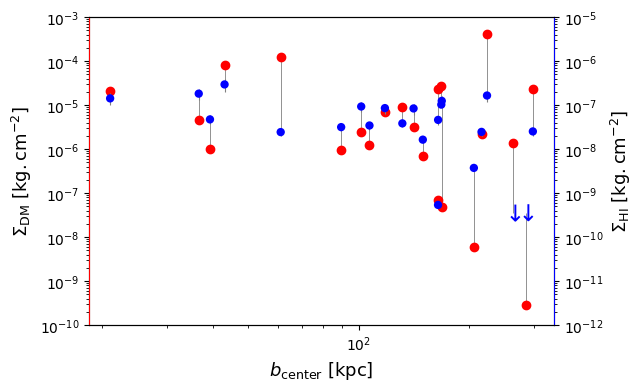

In [875]:
#plt.figure(dpi = 250)

fig, ax1 = plt.subplots(figsize = (6,4))
fig.dpi = 100

convert1 = ((const.M_sun/((1*u.kpc)**2)).to(u.kg/((u.cm)**2))).value

#plt.plot(b/rvir, rho_column*convert1, linestyle = "-", color = "red", linewidth = 1, label = "$\sigma_{NFW}$")
#plt.plot(b/rvir, rho_trunc*convert1, linestyle = "-", color = "orange", linewidth = 1, label = "$\sigma_{NFW} trunc$")
#plt.plot(b/rvir, surf_dens_d22, '--', color = "red", label = "Diemer+22", zorder = 1);
plt.scatter(G4_9["b_center_kpc"], G4_9["DM_surf_dens_d22"],\
         color = "red", label = "Diemer+22", zorder = 1);
plt.vlines(G4_9_abs["b_center_kpc"],G4_9_abs["NHI"]*u_to_kg*100, G4_9_abs["DM_surf_dens_d22"], zorder = 0, \
          color = "gray", linewidth = 0.6)
plt.vlines(G4_9_noabs["b_center_kpc"],G4_9_noabs["NHI_limit"]*u_to_kg*100, G4_9_noabs["DM_surf_dens_d22"], \
           zorder = 0, color = "gray", linewidth = 0.6)

#plt.plot(b/rvir, sig_dm*convert1, linestyle = "-", color = "red", linewidth = 1)
plt.xlabel("$b_{\mathrm{center}}$ [kpc]", size = 13)
plt.ylabel("$\Sigma_{\mathrm{DM}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)
#plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-10, 1e-3))

    
# -----------------------------------------------------------------------

u_to_kg = 1.67355755e-27

ax2 = ax1.twinx()
NHI_abs = G4_9_abs["NHI"]*u_to_kg
NHI_abs_sigma = G4_9_abs["sigma_NHI"]*u_to_kg
NHI_noabs = G4_9_noabs["NHI_limit"]*u_to_kg
NHI_noabs_sigma = G4_9_noabs["sigma_NHI"]*u_to_kg


X = np.linspace(0.05, 3, 50)
ax2.plot(X, 10**(gt.model(LMG['x'], X)), linewidth = 1.2, c = "blue", \
         linestyle = "dotted")
ax2.fill_between(X, 10**(gt.model(LMG_1sig_inf, X)), 10**(gt.model(LMG_1sig_sup, X)), \
                 color = "lightskyblue", alpha = 0.3, linewidth = 0)
ax2.plot([0], [0], '--', color = "red", label = "Diemer+22");


ax2.errorbar(G4_9_abs["b_center_kpc"], NHI_abs, yerr = NHI_abs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8, zorder = 1)
ax2.scatter(G4_9_abs["b_center_kpc"], NHI_abs, marker = "o", \
            c = "blue", alpha = 1, edgecolors = "none", zorder = 2)
#plt.colorbar(label = "log($M/M_{\odot}$)")

ax2.errorbar(G4_9_noabs["b_center_kpc"], NHI_noabs,\
             yerr = NHI_noabs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8, zorder = 1)
ax2.scatter(G4_9_noabs["b_center_kpc"], NHI_noabs,\
            marker = "$\downarrow$", s = 150, \
             c = "blue", alpha = 1, edgecolors = "none", zorder = 2)


plt.ylabel("$\Sigma_{\mathrm{HI}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)


ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('blue')

plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-12, 1e-5))
#plt.xlim((0.07, 3))

In [544]:
G4_9_raw = gt.create_id(G4_9_raw, "N_gal")

In [545]:
#gt.plot_groups_2(R,G4_9_raw, Nmin = 1, save = False)

# Passive galaxies

TO compute the SFR we can use the relations from Gilbank 2010, 2011: 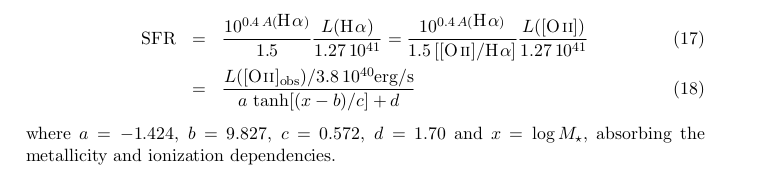

In [546]:
def get_SFR(logMstar, LOII):
    a = -1.424
    b = 9.827
    c = 0.572
    d = 1.7
    lnorm = 3.8e40
    SFR = LOII/lnorm/(a*np.tanh((logMstar-b)/c)+d)
    return SFR

In [547]:
R["OII_FLUX"] = (R["OII3729_FLUX"] + R["OII3726_FLUX"])*1e38

In [548]:
R["SFR_from_OII"] = get_SFR(R["sed_logMass"], R["OII_FLUX"])

(-2.0, 3.0)

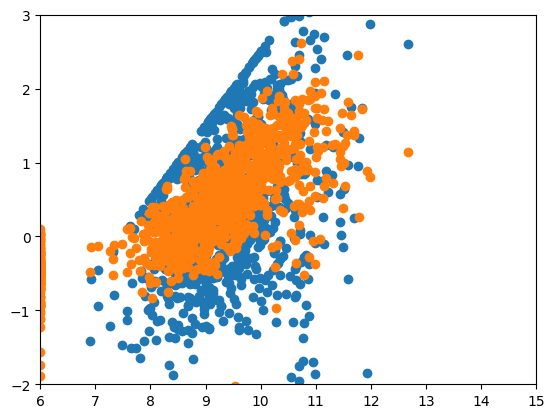

In [549]:
plt.scatter(R["sed_logMass"], np.log10(R["sed_curr_sfr"]))
plt.scatter(R["sed_logMass"], np.log10(R["SFR_from_OII"]))
#plt.xscale("log")
#plt.yscale("log")
plt.xlim((6, 15))
plt.ylim((-2, 3))

(-3.0, 3.0)

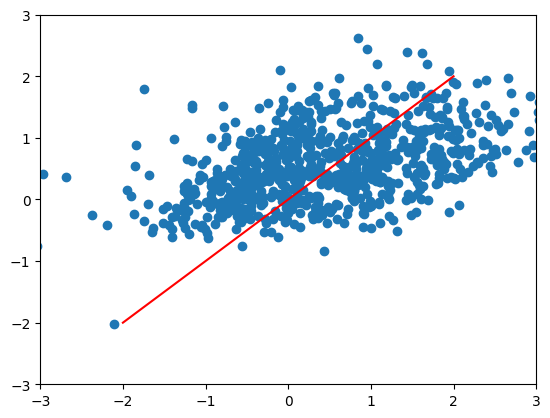

In [550]:
plt.scatter(np.log10(R["sed_curr_sfr"]), np.log10(R["SFR_from_OII"]))
plt.plot([-2, 2], [-2, 2], c = "r")
plt.ylim((-3, 3))
plt.xlim((-3, 3))

In [551]:
R

_id     ID    field_id    DATASET       FROM        Z  ZCONF  is_QSO  \
0      0  11040  J0014m0028  b'psfsub'  b'FELINE'  1.17027      2       0   
1      0  32081  J2152p0625  b'psfsub'  b'FELINE'  0.87357      3       0   
2      0  32076  J2152p0625  b'psfsub'  b'FELINE'  1.01279      2       0   
3      0  32080  J2152p0625  b'psfsub'  b'FELINE'  1.01400      3       0   
4      0  32051  J2152p0625  b'psfsub'  b'FELINE'  1.01310      3       0   
..   ...    ...         ...        ...        ...      ...    ...     ...   
955    0  23119  J1107p1021  b'psfsub'  b'FELINE'  1.48813      2       0   
956    0  17064  J0134p0051  b'psfsub'  b'FELINE'  1.04790      3       0   
957    0  17102  J0134p0051  b'psfsub'  b'FELINE'  1.04924      3       0   
958    0  17094  J0134p0051  b'psfsub'  b'FELINE'  1.04614      2       0   
959    0  17065  J0134p0051  b'psfsub'  b'FELINE'  1.05023      3       0   

     is_star DR1_id  ... HST_qso_y  rmag_qso_y  detection_limit  \
0          0    NaN  ...      None         NaN         0.046077   
1          0    NaN  ...      None         NaN         0.053374   
2          0    NaN  ...      None         NaN         0.049682   
3          0    NaN  ...      None         NaN         0.049652   
4          0    NaN  ...      None         NaN         0.049675   
..       ...    ...  ...       ...         ...              ...   
955        0    NaN  ...      WFC3        17.6         0.040191   
956        0    NaN  ...      STIS         NaN         0.048831   
957        0    NaN  ...      STIS         NaN         0.048799   
958        0    NaN  ...      STIS         NaN         0.048873   
959        0    NaN  ...      STIS         NaN         0.048775   

     QSO_is_behind  SFR_gilbank_noNa  mass_lim sSFR_gilbank passive  \
0             True          0.163723  6.000000     0.027287       0   
1             True          3.252879  9.834779     0.330753       0   
2             True          0.148317  6.000000     0.024720       0   
3             True         18.891177  9.956775     1.897319       0   
4             True          2.488637  9.600106     0.259230       0   
..             ...               ...       ...          ...     ...   
955           True          9.460641  9.215440     1.026608       0   
956           True          2.198805  8.707787     0.252510       0   
957           True          8.574657  9.575969     0.895435       0   
958           True          1.767569  9.554740     0.184994       0   
959           True          0.536448  6.000000     0.089408       0   

         OII_FLUX  SFR_from_OII  
0    2.390207e+40      0.201345  
1    5.250172e+41      8.220842  
2    3.092236e+40      0.260483  
3    1.737688e+42     33.080249  
4    3.712510e+41      4.367386  
..            ...           ...  
955  6.905803e+41      6.435844  
956  4.139691e+41      3.550558  
957  1.199884e+42     13.802529  
958  2.538547e+41      2.866064  
959  1.022713e+41      0.861509  

[960 rows x 283 columns]

In [552]:
for c in R.columns:
    print(c)

_id
ID
field_id
DATASET
FROM
Z
ZCONF
is_QSO
is_star
DR1_id
DR1_nbmatch
RA
DEC
B_KPC
B_ARCSEC
REFSPEC
REFCENTER
FELINE_ID
WHITE_ID
WHITE_ID.1
MANUAL_ID
fel_ID
FEL_score
FEL_sigma
WHITE_ID.2
WHITE_ID.3
wh_SDSS_r
wh_SDSS_i
sp_F775W
sp_SDSS_r
sp_SDSS_i
SDSS_r
SDSS_r_ERR
SDSS_i
SDSS_i_ERR
MAG_F775W
MAG_F775W_ERR
OII3726_FLUX
OII3726_FLUX_ERR
OII3726_EQW
OII3726_FLUX_EQW
OII3729_FLUX
OII3729_FLUX_ERR
OII3729_EQW
OII3729_EQW_ERR
MGII2796_EMI_FLUX
MGII2796_EMI_FLUX_ERR
MGII2796_ABS_EQW
MGII2796_ABS_EQW_ERR
MGII2803_EMI_FLUX
MGII2803_EMI_FLUX_ERR
MGII2803_ABS_EQW
MGII2803_ABS_EQW_ERR
sed_logMass
sed_logMass_l95
sed_logMass_u95
sed_rchisq
sed_ebv
sed_ebv_l95
sed_ebv_u95
sed_age
sed_age_l95
sed_age_u95
sed_metallicity
sed_tau
sed_tau_l95
sed_tau_u95
sed_curr_sfr
sed_curr_sfr_l95
sed_curr_sfr_u95
sed_sfr_100
sed_sfr_100_l95
sed_sfr_100_u95
photoz_zbest
photoz_zbest_l95
photoz_zbest_u95
photoz_rchisq
EXPTIME(s)_x
PSF_qso_x
Comments_qso_x
zqso_sdss_x
depth_qso_x
ebv_sfd_qso_x
ebv_sandf_qso_x
ebv_pla

# Group metallicity

We can use Zn/Fe in the UVES spectra to investigate groups metallicity.

We can look in Martin 2021 if some groups correspond to his sample: 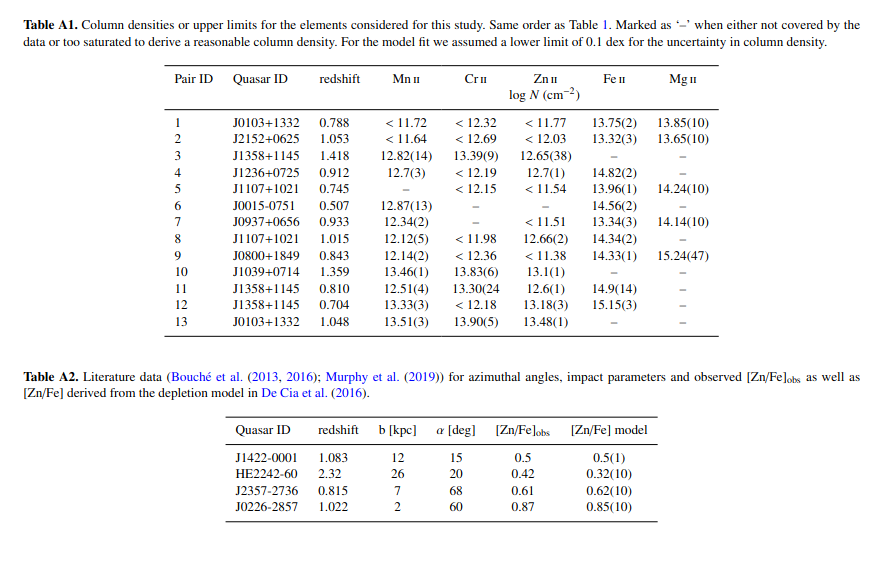

# Absorber kinematics

In [553]:
fff = "J1039p0714"
"j"+fff[1:]

'j1039p0714'

In [554]:
grplist = G5["group_id"]
Abs = pd.read_csv("MgII_all_absorption")

In [555]:
#for i in range(len(G5)):
#    gid.plot_group_absorption2(i, R, G5, Abs)

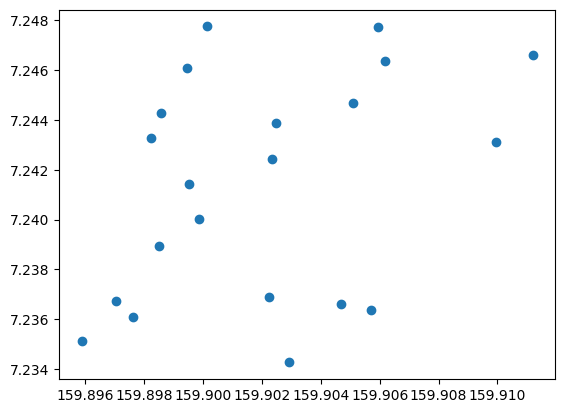

In [556]:
KK = G5.head(1)
KK = KK.squeeze()
RR = R[R["group_id"] == KK["group_id"]]
plt.scatter(RR["RA"]*u.degree, RR["DEC"]*u.degree)


# Comparison with isolated galaxies

In [558]:
plt.rcParams['xtick.labelsize']='medium'
plt.rcParams['ytick.labelleft']=True
plt.rcParams['ytick.labelsize']='medium'
plt.rcParams['xtick.minor.visible']=False
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.size']=4.0
plt.rcParams['xtick.major.size']=8.0
plt.rcParams['ytick.minor.size']=4
plt.rcParams['ytick.major.size']=8
plt.rcParams['ytick.left']= True
plt.rcParams['ytick.major.left']= True

In [208]:
R = gid.get_Nxxx_neighb(R, radius = 2000)

In [209]:
Mhalo_lst = []
Rvir_lst = []
for i, kk in R.iterrows():
    mm = gid.Behroozi(kk["mass"], kk["Z"])
    Mhalo_lst.append(mm)
    #print(kk["mass"], mm, kk["Z"])
R["Mvir"] = Mhalo_lst

for i, kk in R.iterrows():
    try:
        rr = gid.get_Rvir(10**kk["Mvir"], kk["Z"])
        Rvir_lst.append(rr)
    except:
        Rvir_lst.append(3000)
    #print(kk["mass"], rr, kk["Z"])
R["Rvir"] = Rvir_lst

(6.0, 13.0)

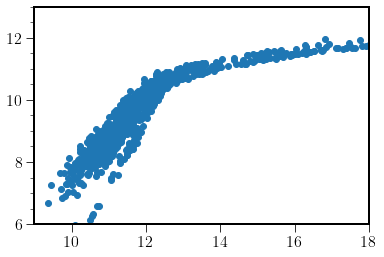

In [210]:
plt.scatter(R["Mvir"], R["mass"])
plt.xlim((9, 18))
plt.ylim((6, 13))

In [211]:
f24 = R["N2000_neighb"] == 0
f25 = R["Z"]< R["zqso_sdss_x"] - 1e6*(1+R["zqso_sdss_x"])/const.c

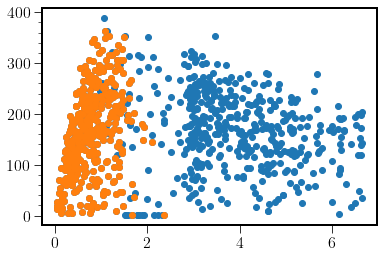

In [212]:
K1 = R[f24]
K2 = R[f24 & f25]
K2_abs = R[f24 & f25 & f22]
K2_noabs = R[f24 & f25 & f21]
 
plt.scatter(K1["Z"], K1["B_KPC"])
plt.scatter(K2["Z"], K2["B_KPC"])

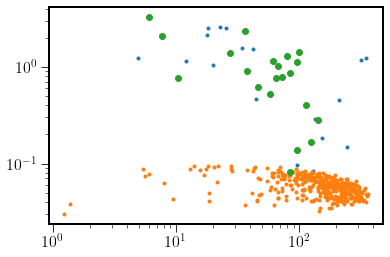

In [213]:
plt.scatter(K2_abs["B_KPC"], K2_abs["REW_2796"], marker = ".")
plt.scatter(K2_noabs["B_KPC"], K2_noabs["detection_limit"], marker = ".")
plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"])
plt.xscale("log")
plt.yscale("log")

(0.01, 5)

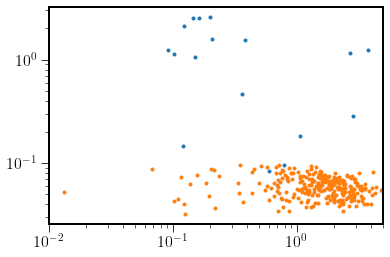

In [214]:
plt.scatter(K2_abs["B_KPC"]/K2_abs["Rvir"], K2_abs["REW_2796"], marker = ".")
plt.scatter(K2_noabs["B_KPC"]/K2_noabs["Rvir"], K2_noabs["detection_limit"], marker = ".")
#plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"])
plt.xscale("log")
plt.yscale("log")
plt.xlim((0.01, 5))

(array([  4.,  56., 184.,  38.,   3.,   4.,   1.,   0.,   0.,   1.]),
 array([0.9367898 , 0.9814659 , 1.026142  , 1.0708181 , 1.11549419,
        1.16017029, 1.20484639, 1.24952249, 1.29419859, 1.33887469,
        1.38355079]),
 <BarContainer object of 10 artists>)

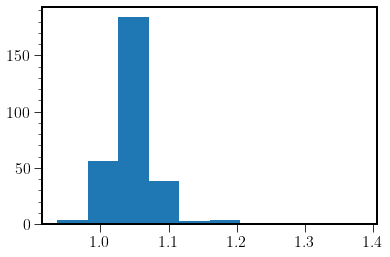

In [215]:
plt.hist(np.log10(K2["Mvir"]))

In [216]:
len(K2[np.isnan(K2["mass"])])

101

In [217]:
len(K2)

402

In [218]:
len(R[np.isnan(R["mass"])])

664

In [219]:
for c in R.columns:
    print(c)

ID
field_id
DATASET
FROM
Z
ZCONF
is_QSO
is_star
DR1_id
DR1_nbmatch
RA
DEC
B_KPC
B_ARCSEC
REFSPEC
REFCENTER
FELINE_ID
WHITE_ID
MANUAL_ID
fel_ID
FEL_score
FEL_sigma
white_ID
wh_SDSS_r
wh_SDSS_i
sp_F775W
sp_SDSS_r
sp_SDSS_i
SDSS_r
SDSS_r_ERR
SDSS_i
SDSS_i_ERR
MAG_F775W
MAG_F775W_ERR
OII3726_FLUX
OII3726_FLUX_ERR
OII3726_EQW
OII3726_FLUX_EQW
OII3729_FLUX
OII3729_FLUX_ERR
OII3729_EQW
OII3729_EQW_ERR
MGII2796_EMI_FLUX
MGII2796_EMI_FLUX_ERR
MGII2796_ABS_EQW
MGII2796_ABS_EQW_ERR
MGII2803_EMI_FLUX
MGII2803_EMI_FLUX_ERR
MGII2803_ABS_EQW
MGII2803_ABS_EQW_ERR
sed_logMass
sed_logMass_l95
sed_logMass_u95
sed_rchisq
sed_ebv
sed_ebv_l95
sed_ebv_u95
sed_age
sed_age_l95
sed_age_u95
sed_metallicity
sed_tau
sed_tau_l95
sed_tau_u95
sed_curr_sfr
sed_curr_sfr_l95
sed_curr_sfr_u95
sed_sfr_100
sed_sfr_100_l95
sed_sfr_100_u95
photoz_zbest
photoz_zbest_l95
photoz_zbest_u95
photoz_rchisq
mass_noNA
mass
dist_ang
dist_lum
N100_neighb
N50_neighb
group_id
DMEAN
D12
V12
is_grouped
Mvir_sigma2
Mvir_sigma3
Rvir_sigma2
R

# Strong absorbers

In [220]:
Abs = pd.read_csv("MgII_all_absorption")

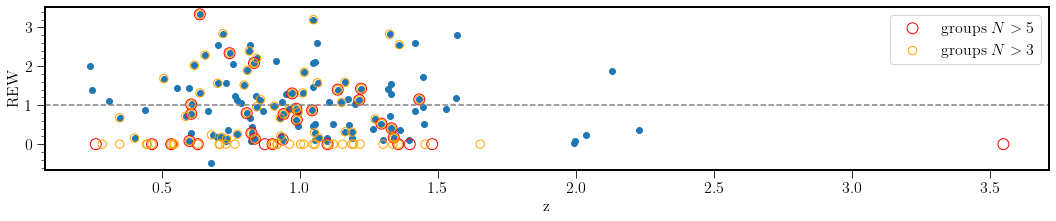

In [221]:
plt.figure(figsize = (18,3))
plt.scatter(Abs["z_abs"], Abs["REW_2796"])
plt.scatter(G5_raw["center_z"], G5_raw["REW_2796"], marker = "o", s = 120, facecolors = "none", edgecolors ="r",\
           label = "groups $N>5$")
plt.scatter(G3["center_z"], G3["REW_2796"], marker = "o", s = 70, facecolors = "none", edgecolors ="orange",
           label = "groups $N>3$")
plt.axhline(1, color = "gray", linestyle = "--")
plt.xlabel("z")
plt.ylabel("REW")
plt.legend()

In [222]:
Abs = gid.get_Nxxx_abs(Abs, R, bmax = 2000, dv = 0.5e6)
Abs2 = gid.get_Nxxx_abs(Abs, R, bmax = 2000, dv = 1e6)

In [223]:
Abs_05A = Abs[Abs["REW_2796"]>=0.5]
Abs_1A = Abs[Abs["REW_2796"]>=1]
Abs_15A = Abs[Abs["REW_2796"]>=1.5]
Abs_2A = Abs[Abs["REW_2796"]>=2]
Abs_3A = Abs[Abs["REW_2796"]>=3]

Abs_b05A = Abs[Abs["REW_2796"]<0.5]
Abs_in1A = Abs[(Abs["REW_2796"]>=0.5) &  (Abs["REW_2796"]< 1.5)]
Abs_in15A = Abs[Abs["REW_2796"]>=1.5]
Abs_in2A = Abs[(Abs["REW_2796"]>=1.5) &  (Abs["REW_2796"]< 2.5)]
Abs_in3A = Abs[(Abs["REW_2796"]>=2.5)]

G5_1A = G5_raw[G5_raw["REW_2796"]>=1]
G5_2A = G5_raw[G5_raw["REW_2796"]>=2]
G5_3A = G5_raw[G5_raw["REW_2796"]>=3]
G3_1A = G3[G3["REW_2796"]>=3]

print("total number of absorbers = ", len(Abs))
print("number of absorbers with REW above 1A = ", len(Abs_1A))
print("number of absorbers with REW above 2A = ", len(Abs_2A))
print("number of absorbers with REW above 3A = ", len(Abs_3A))
           
print("number of groups of 5 with REW above 1A = ", len(G5_1A))
print("number of groups of 5 with REW above 2A = ", len(G5_2A))
print("number of groups of 5 with REW above 3A = ", len(G5_3A))
print("number of groups of 3 with REW above 1A = ", len(G3_1A))

total number of absorbers =  126
number of absorbers with REW above 1A =  59
number of absorbers with REW above 2A =  21
number of absorbers with REW above 3A =  2
number of groups of 5 with REW above 1A =  9
number of groups of 5 with REW above 2A =  3
number of groups of 5 with REW above 3A =  1
number of groups of 3 with REW above 1A =  2


Text(0.5, 0, 'N / abs')

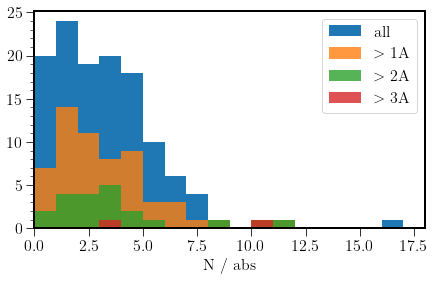

In [224]:
plt.figure(figsize =(7,4))
plt.hist(Abs["N2000_abs"], range = (0,20), bins = 20, label = "all")
#plt.hist(Abs_05A["N2000_abs"], range = (0,20), bins = 20, alpha = 0.5)
plt.hist(Abs_1A["N2000_abs"], range = (0,20), bins = 20, alpha = 0.8, label = "$>$ 1A")
#plt.hist(Abs_15A["N2000_abs"], range = (0,20), bins = 20, alpha = 0.5)
plt.hist(Abs_2A["N2000_abs"], range = (0,20), bins = 20, alpha = 0.8, label = "$>$ 2A")
plt.hist(Abs_3A["N2000_abs"], range = (0,20), bins = 20, alpha = 0.8, label = "$>$ 3A")
plt.xlim((0,18))
plt.legend()
plt.xlabel("N / abs")

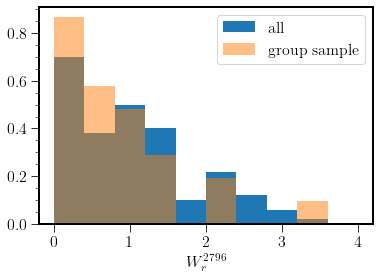

In [225]:
plt.hist(Abs["REW_2796"], density = True, range = (0,4), label = "all")
plt.hist(G5["REW_2796"], density = True, range = (0,4), alpha = 0.5, label = "group sample")
plt.xlabel("$W_r^{2796}$")
plt.legend()

In [518]:
f1 = Abs["z_abs"]>= 0.3
f2 = Abs["z_abs"]<= 1.55555
Abs_2 = Abs[f1 & f2]
len(Abs_2)

117

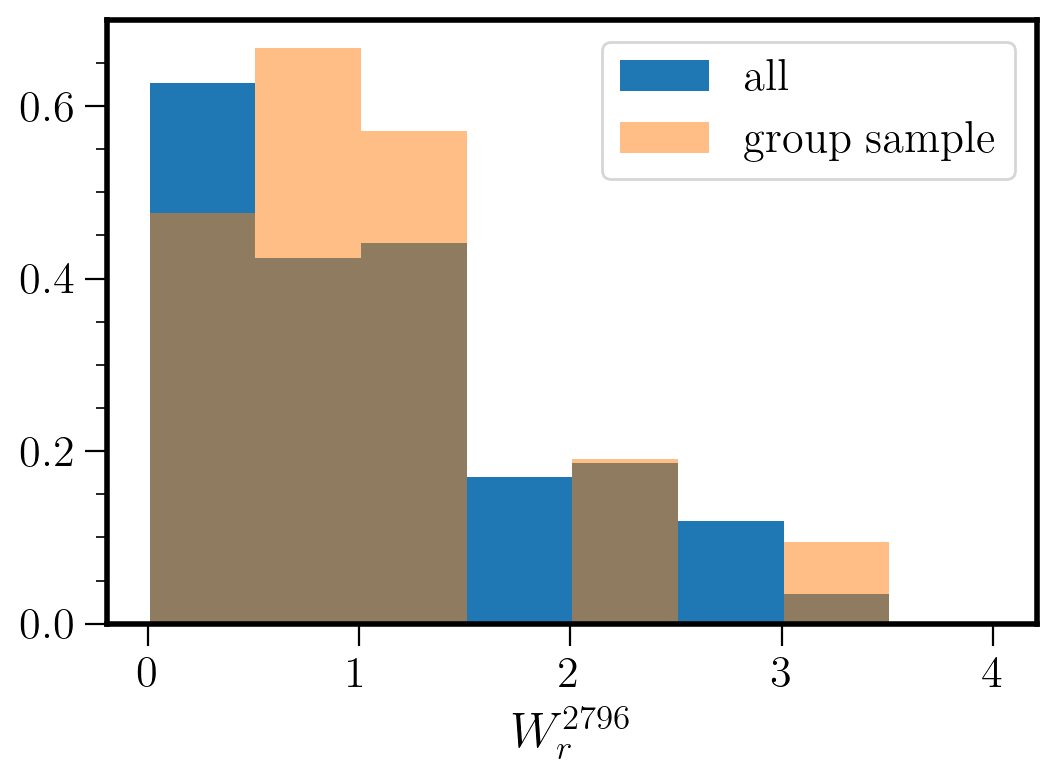

In [513]:
plt.figure(dpi = 200)
plt.hist(Abs_2["REW_2796"], density = True, range = (0.01,4.01), bins = 8, label = "all")
#plt.hist(Abs["REW_2796"], density = True, range = (0,4), label = "all")
plt.hist(G5["REW_2796"], density = True, range = (0.01,4.01), bins = 8, alpha = 0.5, label = "group sample")
plt.xlabel("$W_r^{2796}$", size = 18)
plt.legend()

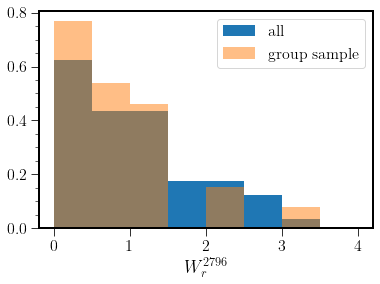

In [501]:
plt.hist(Abs_2["REW_2796"], density = True, range = (0,4), bins = 8, label = "all")
#plt.hist(Abs["REW_2796"], density = True, range = (0,4), label = "all")
plt.hist(G5["REW_2796"], density = True, range = (0,4), bins = 8, alpha = 0.5, label = "group sample")
plt.xlabel("$W_r^{2796}$", size = 18)
plt.legend()

From galaxy point of view to compare to Dutta

In [472]:
R_no_group = R[~R["group_id"].isin(G5["group_id"].tolist())]
len(R_no_group)

1825

In [480]:
def bin_REW_2796(G, R, bin_width, N_bins):
    mean_group = []
    mean_all = []
    bin_centers = []
    for i in range(N_bins):
        #print(i)
        f1_min = G["b_min_kpc"]>= i*bin_width
        f1_max = G["b_min_kpc"]<(i+1)*bin_width
        f2_min = R["B_KPC"]>= i*bin_width
        f2_max = R["B_KPC"]< (i+1)*bin_width
        S1 = G[f1_min & f1_max]
        S2 = R[f2_min & f2_max]
        mean_group.append(np.mean(S1["REW_2796"]))
        mean_all.append(np.mean(S2["REW_2796"]))
        bin_centers.append((2*i+1)*bin_width/2)
    return mean_group, mean_all, bin_centers

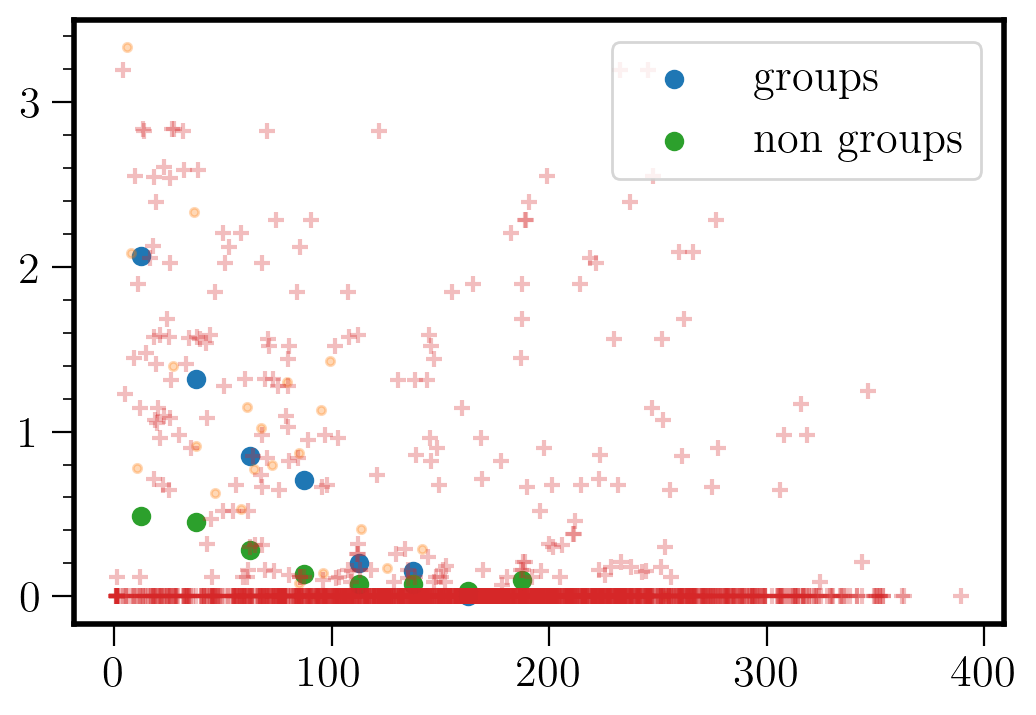

In [494]:
plt.figure(dpi = 200)
mean_group, mean_all, bin_centers = bin_REW_2796(G5, R_no_group,25, 8)
plt.scatter(bin_centers, mean_group, label = "groups")
plt.scatter(G5["b_min_kpc"], G5["REW_2796"], marker = ".", alpha = 0.3)
plt.scatter(bin_centers, mean_all, label="non groups")
plt.scatter(R_no_group["B_KPC"], R_no_group["REW_2796"], marker = "+", alpha = 0.3)
plt.legend()

(array([0.47619048, 0.66666667, 0.57142857, 0.        , 0.19047619,
        0.        , 0.0952381 , 0.        ]),
 array([0.01, 0.51, 1.01, 1.51, 2.01, 2.51, 3.01, 3.51, 4.01]),
 <BarContainer object of 8 artists>)

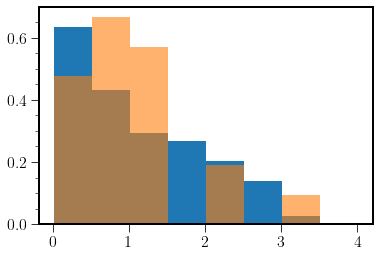

In [499]:
plt.hist( R_no_group["REW_2796"], range  = (0.01, 4.01), bins =8, density = True) 
plt.hist( G5["REW_2796"], range  = (0.01, 4.01), bins =8, alpha = 0.6, density = True) 

In [432]:
len(R)

2020

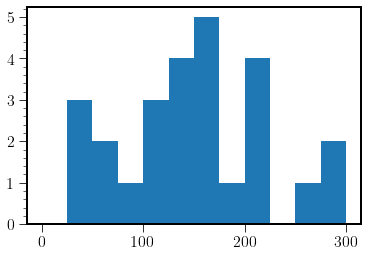

In [228]:
plt.hist(G5["b_center_kpc"], range = (0,300), bins = 12);

(0.0, 21.0)

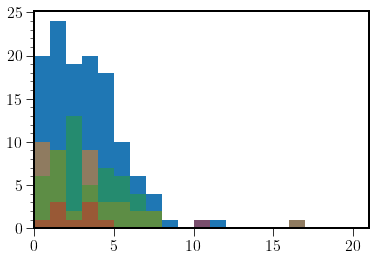

In [229]:
plt.hist(Abs["N2000_abs"], range = (0,20), bins = 20)
plt.hist(Abs_b05A["N2000_abs"], range = (0,20), bins = 20, alpha = 0.5)
plt.hist(Abs_in1A["N2000_abs"], range = (0,20), bins = 20, alpha = 0.5)
#plt.hist(Abs_15A["N2000_abs"], range = (0,20), bins = 20, alpha = 0.5)
#plt.hist(Abs_in2A["N2000_abs"], range = (0,20), bins = 20, alpha = 0.5)
plt.hist(Abs_in3A["N2000_abs"], range = (0,20), bins = 20, alpha = 0.5)
plt.xlim((0,21))

Text(0, 0.5, 'REW')

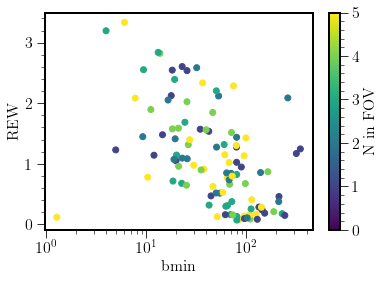

In [230]:
plt.scatter(Abs["bmin2000_abs"], Abs["REW_2796"], c = Abs["N2000_abs"], vmin = 0, vmax = 5)
plt.colorbar(label = "N in FOV")
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("bmin")
plt.ylabel("REW")

In [231]:
G5_massive = G5_raw[G5_raw["Mvir_sigma2"]>1e13]
len(G5_massive)

6

In [232]:
G5_massive[["Mvir_sigma2", "REW_2796"]]

Mvir_sigma2  REW_2796
1   1.542607e+13     0.118
2   5.236328e+13     2.085
6   1.045701e+13     0.779
9   1.316459e+13     0.000
12  1.322800e+13     1.150
18  2.146685e+13     0.869

# Covering fraction

In [559]:
folder = "run_manuscript"

In [560]:
G4_9_bmin_lin = G4_9[["b_min_kpc", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G4_9_bcenter_lin = G4_9[["b_center_kpc", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G4_9_bmin_norm_lin = G4_9[["b_min_kpc_norm2", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G4_9_bcenter_norm_lin = G4_9[["b_center_kpc_norm2", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G4_9_bmin_lin = G4_9_bmin_lin.rename(columns = {"b_min_kpc": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G4_9_bcenter_lin = G4_9_bcenter_lin.rename(columns = {"b_center_kpc": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G4_9_bmin_norm_lin = G4_9_bmin_norm_lin.rename(columns = {"b_min_kpc_norm2": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G4_9_bcenter_norm_lin = G4_9_bcenter_norm_lin.rename(columns = {"b_center_kpc_norm2": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})

G4_9_bmin_log = G4_9_bmin_lin.copy()
G4_9_bcenter_log = G4_9_bcenter_lin.copy()
G4_9_bmin_norm_log = G4_9_bmin_norm_lin.copy()
G4_9_bcenter_norm_log = G4_9_bcenter_norm_lin.copy()
G4_9_bmin_log["log10(b)"] = np.log10(G4_9_bmin_lin["b"])
G4_9_bcenter_log["log10(b)"] = np.log10(G4_9_bcenter_lin["b"])
G4_9_bmin_norm_log["log10(b)"] = np.log10(G4_9_bmin_norm_lin["b"])
G4_9_bcenter_norm_log["log10(b)"] = np.log10(G4_9_bcenter_norm_lin["b"])
G4_9_bmin_norm_lin["log10(b)"] = G4_9_bmin_norm_lin["b"]
G4_9_bcenter_norm_lin["log10(b)"] = G4_9_bcenter_norm_lin["b"]

In [440]:
G4_9_bmin_lin.to_csv(folder + "/G4_9_mgii_bmin_lin.csv", index = False)
G4_9_bcenter_lin.to_csv(folder + "/G4_9_mgii_bcenter_lin.csv", index = False)
G4_9_bmin_log.to_csv(folder + "/G4_9_mgii_bmin_log.csv", index = False)
G4_9_bcenter_log.to_csv(folder + "/G4_9_mgii_bcenter_log.csv", index = False)
G4_9_bmin_norm_lin.to_csv(folder + "/G4_9_mgii_bmin_norm_lin.csv", index = False)
G4_9_bcenter_norm_lin.to_csv(folder + "/G4_9_mgii_bcenter_norm_lin.csv", index = False)
G4_9_bmin_norm_log.to_csv(folder + "/G4_9_mgii_bmin_norm_log.csv", index = False)
G4_9_bcenter_norm_log.to_csv(folder + "/G4_9_mgii_bcenter_norm_log.csv", index = False)

### fc for N>=5

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:03<00:00, 2606.95draws/s]
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


['alpha', 'beta']
           mean        2.5      16.0     50.0      84.0      97.5
alpha -5.016109 -10.763856 -7.593555 -4.64005 -2.477363 -1.402805
beta   2.366015   2.027277  2.128027  2.30209  2.626055  2.989702
alpha -4.6 [-10.76--1.41] (95\%) 
beta 2.3 [2.03-2.99] (95\%) 

WAIC 14.90 +/- 5.33 peff 1.10
WAIC deviance 12.691492844700667
LOO 14.96 +/- 5.36 peff 1.13
WBIC  22.77803550135451
Deviance Lmax 16.3498
DIC Lmax 21.6001 2.63
Deviance best 16.4920
DIC best 21.4579 2.48
|               WAIC |                LOO |              WBIC |               DIC |
| 14.897107086361304 | 14.955008796567839 | 22.77803550135451 | 21.45793897260989 |
['alpha', 'beta']
           mean        2.5      16.0     50.0      84.0      97.5
alpha -5.016109 -10.763856 -7.593555 -4.64005 -2.477363 -1.402805
beta   2.366015   2.027277  2.128027  2.30209  2.626055  2.989702


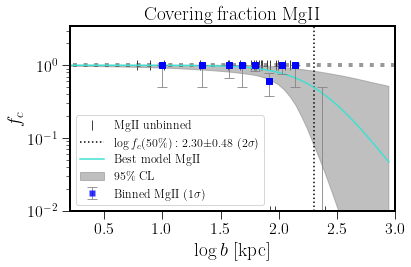

In [442]:
fc_G4_9_bmin_noz = run_covering_2.mgii(run = True, filename = folder + "/G4_9_mgii_bmin_log.csv", redshift = False)

In [352]:
2.2-1.88

0.3200000000000003

In [134]:
2.67 - 2.1

0.5699999999999998

In [135]:
0.47 - 0.2

0.26999999999999996

In [136]:
0.05 - 0.6

-0.5499999999999999

In [1]:
fc_G4_9_bmin_z = run_covering_2.mgii(run = True, filename = folder + "/G4_9_mgii_bmin_log.csv", redshift = True)

NameError: name 'run_covering_2' is not defined

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:03<00:00, 2747.44draws/s]
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5824145921440008, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.540966 -11.032678 -8.174376 -5.136997 -3.078627 -1.838262
beta   2.592841   2.332788  2.428017  2.566985  2.780419  2.953497
alpha -5.1 [-11.03--1.85] (95\%) 
beta 2.6 [2.33-2.95] (95\%) 

WAIC 15.30 +/- 4.99 peff 1.07
WAIC deviance 13.15478655033604
LOO 15.34 +/- 5.02 peff 1.09
WBIC  23.29499877254364
Deviance Lmax 18.0523
DIC Lmax 22.6237 2.29
Deviance best 18.2163
DIC best 22.4597 2.12
|              WAIC |                LOO |              WBIC |                DIC |
| 15.29991958440265 | 15.343092315858602 | 23.29499877254364 | 22.459651551774247 |
['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.540966 -11.032678 -8.174376 -5.136997 -3.078627 -1.838262
beta   2.592841   2.332788  2.428017  2.566985  2.780419  2.953497


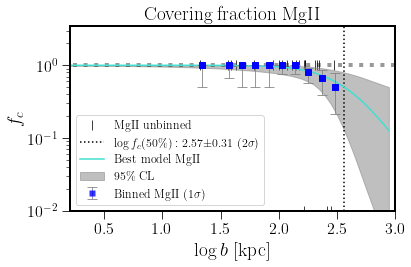

In [446]:
fc_G4_9_bcenter_noz = run_covering_2.mgii(run = True, filename = folder + "/G4_9_mgii_bcenter_log.csv", redshift = False)

MgII_closest_only_redshift
Reading from None
LEN (Outcomes) 22
['alpha', 'beta', 'zalpha']
            mean        2.5      16.0      50.0      84.0       97.5
alpha  -3.785145 -12.394604 -7.018350 -2.969284 -0.993732   0.984741
beta    1.517910   0.258401  0.877898  1.514815  2.190032   2.783158
zalpha  2.942066 -12.043748  0.738051  3.371886  6.349280  10.940601
evaluating for z= 0.293115635266646
ErrorsZP: 1.2623781233254046 3.368536055189211
q =  [0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85
 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55
 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25
 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95]
phigh =  [1.         1.         1.         1.         1.         1.
 1.         1.         0.99999999 0.99999999 0.99999998 0.99999996
 0.99999993 0.99999987 0.99999976 0.99999955 0.99999914 0.99999847
 0.99999719 0.99999484 0.99999029 0.99998172 0.99996594 0.

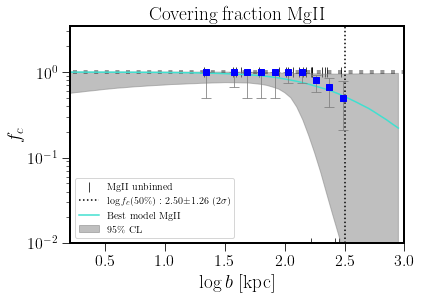

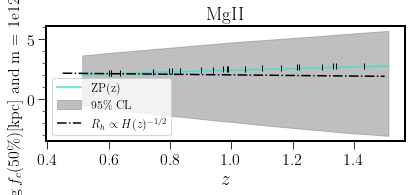

In [447]:
fc_G4_9_bcenter_z = run_covering_2.mgii(run = False, filename = folder + "/G4_9_mgii_bcenter_log.csv", redshift = True)

MgII_closest_only
Reading from None
LEN (Outcomes) 26
['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -2.029271 -4.351967 -2.978072 -1.883571 -1.070876 -0.559363
beta   1.677505  1.072800  1.290685  1.591874  2.081396  2.719582


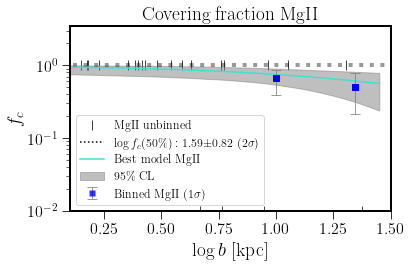

In [242]:
fc_G5_bcenter_norm_raw = run_covering_2.mgii(run = False, filename = folder + "/G5_mgii_bcenter_norm_lin.csv", \
                                         redshift = False, xlim = [0.1, 1.5])

MgII_closest_only
Reading from None
LEN (Outcomes) 22
['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.540966 -11.032678 -8.174376 -5.136997 -3.078627 -1.838262
beta   2.592841   2.332788  2.428017  2.566985  2.780419  2.953497


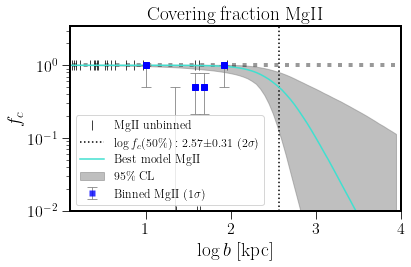

In [459]:
fc_G4_9_bcenter_norm = run_covering_2.mgii(run = False, filename = folder + "/G4_9_mgii_bcenter_norm_lin.csv", \
                                         redshift = False, xlim = [0.1, 4])

In [344]:
-0.63 +2.7

2.0700000000000003

In [345]:
0.2 [0.01-0.48]

6.8

In [347]:
1.7 - 2.79

-1.09

In [145]:
2.79 - 1.5

1.29

In [146]:
0.02 - 0.3

-0.27999999999999997

In [147]:
0.49 - 0.3

0.19

In [148]:
0.06 - 0.6

-0.54

In [149]:
0.98 - 0.6

0.38

In [324]:
10**(1.67)

46.77351412871981

In [325]:
10**(2.17)

147.91083881682073

In [326]:
147/46

3.1956521739130435

## Comparison with other results

In [448]:
logb = np.linspace(0.5, 3, 50)
logb_norm = np.linspace(0.05, 4)

#### Dutta 2020

In [449]:
Dutta_2020 = pd.read_csv("Dutta_2020.csv", index_col = False)
Dutta_2020_fcdiff = pd.read_csv("Dutta_2020_fcdiff.csv", index_col = False)
Dutta_2020_fcdiff01 = pd.read_csv("Dutta_2020_fcdiff01.csv", index_col = False)
Dutta_2020_fcdiff01

R(kpc)      fc01  fc01_inf  fc01_sup
0   30.768106  0.798018  0.551011  0.939595
1   90.384053  0.231708  0.216647  0.361237
2  150.000000  0.192549  0.126278  0.282917
3  210.505737  0.081094  0.044947  0.132303
4  271.011474  0.165438  0.102180  0.258819

#### Schroetter 2021

In [450]:
def logistic(t):
    return 1/(1+np.exp(-t))
    
def logistic_eq6(A, C, logb):
    return logistic(A*(logb - C))

def logistic_eq7(A, B, C, logb, z):
    return logistic(A*(logb - B*np.log10(1+z) - C))

Il_6 = logistic_eq6(-4.7, 1.6, logb)
Il_7 = logistic_eq7(-4.2, 2.0, 1.0, logb, 1.2)
Il = np.array([logb, Il_6, Il_7])

Schroetter_2021 = pd.DataFrame(Il.T, columns = ["logb", "best_fit_b", "best_fit_bz"])

In [451]:
# For the CL intervals:
Schroetter_fc_sup = pd.read_csv("Schroetter_fc_sup.csv", index_col = False)
Schroetter_fc_inf = pd.read_csv("Schroetter_fc_inf.csv", index_col = False)

In [452]:
Sc_logb_sup = np.interp(logb, Schroetter_fc_sup["log_b_sup"], Schroetter_fc_sup["log_fc_sup"])
Sc_logb_inf = np.interp(logb, Schroetter_fc_inf["log_b_inf"], Schroetter_fc_inf["log_fc_inf"])

#### Nielsen 2013

In [453]:
Niels_b = [12.5, 37.5, 75, 150]
Niels_01 = [1, 0.94, 0.61, 0.29]
Niels_01_inf = [0.93, 0.89, 0.53, 0.19]
Niels_01_sup = [1, 0.97, 0.69, 0.41]
Niels_03 = [0.96, 0.79, 0.40, 0.25]
Niels_1 = [0.39, 0.31, 0.13, 0.06]
Niels = np.array([Niels_b, Niels_01, Niels_01_inf, Niels_01_sup, Niels_03, Niels_1])
Nielsen_2013 = pd.DataFrame(Niels.T, columns = ["b", "fc01", "fc01_inf", "fc01_sup", "fc03", "fc1"])

#### Bordoloi 2011

In [454]:
bordoloi_b = [20 ,50, 70, 100, 140, 180]
bordoloi_rew_group = [0.33 , 0.46, 0.39, 0.16, 0.15, 0.046] #upper limit for the last value
bordoloi_rew_nongroup = [0.48 , 0.38, 0.18, 0.04, 0.012, 0] #upper limit for the last value
bordoloi_sig_group = [0.09 , 0.07, 0.05, 0.04, 0.03, 0]
bordoloi_sig_nongroup = [0.05 , 0.05, 0.05, 0.02, 0, 0]
d = np.array([bordoloi_b, bordoloi_rew_group, bordoloi_rew_nongroup, bordoloi_sig_group, bordoloi_sig_nongroup])
bordoloi = pd.DataFrame(d.T, columns = ["bcenter_kpc", "rew_group", "rew_nongroup", "sigma_group", "sigma_nongroup"])
bordoloi

bcenter_kpc  rew_group  rew_nongroup  sigma_group  sigma_nongroup
0         20.0      0.330         0.480         0.09            0.05
1         50.0      0.460         0.380         0.07            0.05
2         70.0      0.390         0.180         0.05            0.05
3        100.0      0.160         0.040         0.04            0.02
4        140.0      0.150         0.012         0.03            0.00
5        180.0      0.046         0.000         0.00            0.00

#### Huang 2021

In [455]:
Huang_b = [20, 70, 200, 500]
Huang_all = [0.87, 0.49, 0.19, 0.06]
Huang_all_sigma = [0.0a5, 0.06, 0.12, 0.06]
Huang_blue = [0.92, 0.56, 0.19, 0.08]
Huang_red = [0.67, 0.41, 0.09, 0.04]
Huang = np.array([Huang_b, Huang_all, Huang_all_sigma, Huang_blue, Huang_red])
Huang_2021 = pd.DataFrame(Huang.T, columns = ["b", "all","all_sigma", "blue", "red"])

In [460]:
pbest, plow, phigh = fc_G4_9_bcenter_norm.predict_2d(logb_norm, 1.0, params=fc_G4_9_bcenter_norm.trace)

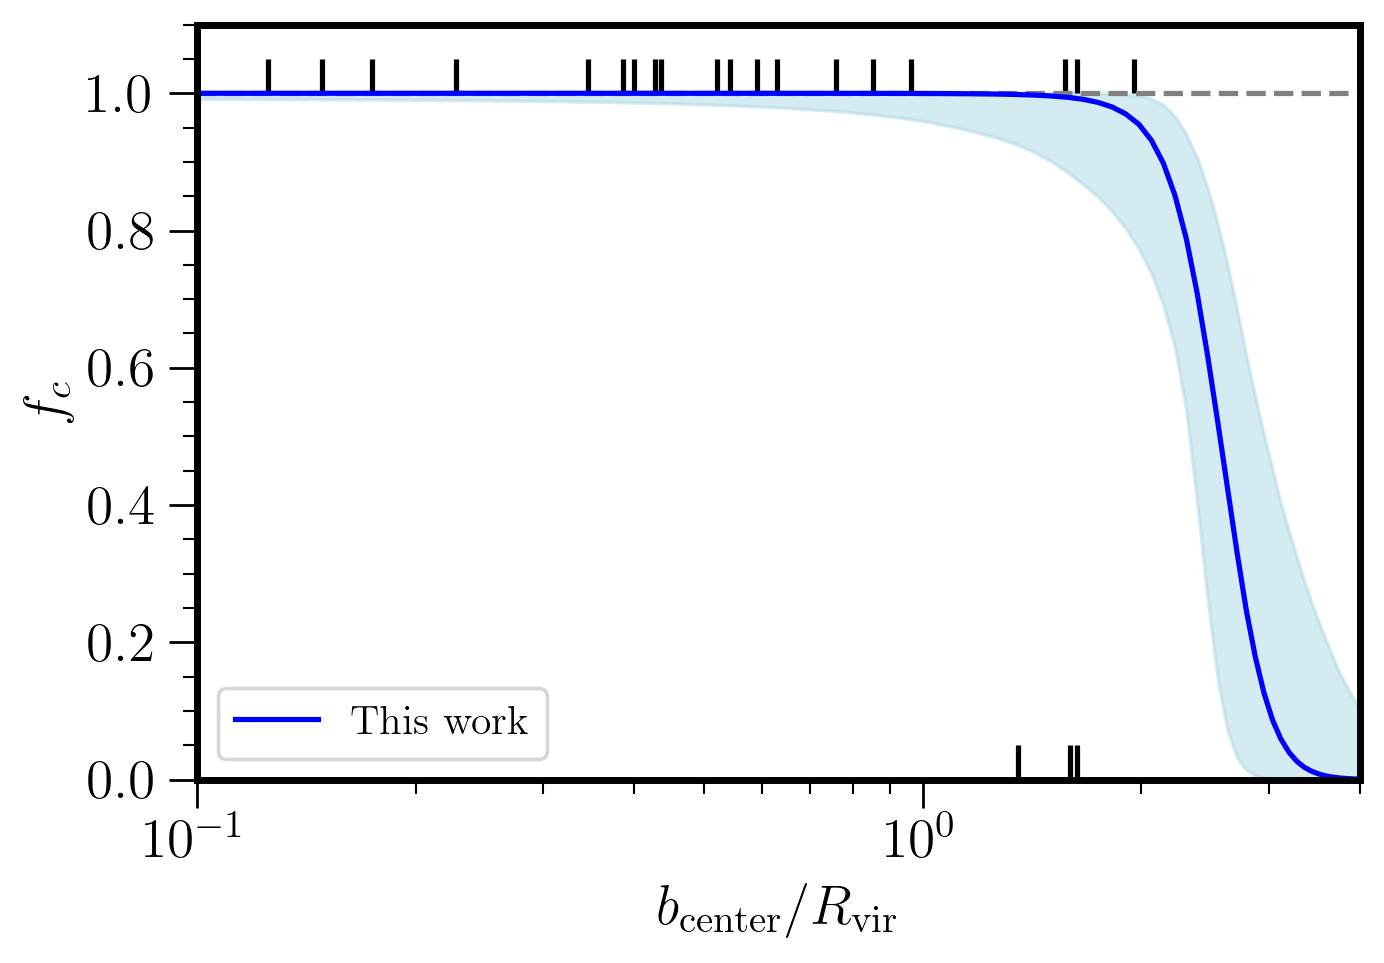

In [464]:
plt.figure(dpi = 250)
plt.rcParams['lines.linewidth']=1.5
plt.axhline(0.0, color = "grey", linestyle = "--")
plt.axhline(1, color = "grey", linestyle = "--")
plt.fill_between(logb_norm, plow, phigh, color = 'lightblue', alpha = 0.5)
plt.plot(logb_norm, pbest, label= "This work", color = "blue")
plt.scatter(fc_G4_9_bcenter_norm.log_flux, fc_G4_9_bcenter_norm.outcomes+0.025, marker = "|", color = "black",\
            s = 100)
#plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")

#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
#plt.legend(bbox_to_anchor=(0.5, 1.25), loc = 'center', ncol = 2)
plt.legend(fontsize = 12)
plt.ylim((0.00,1.1))
plt.xlim((0.1,4))
#plt.yscale("log")
plt.xlabel("$b_{\mathrm{center}}/ R_{\mathrm{vir}}$")
plt.ylabel("$f_c$")
plt.xscale("log")

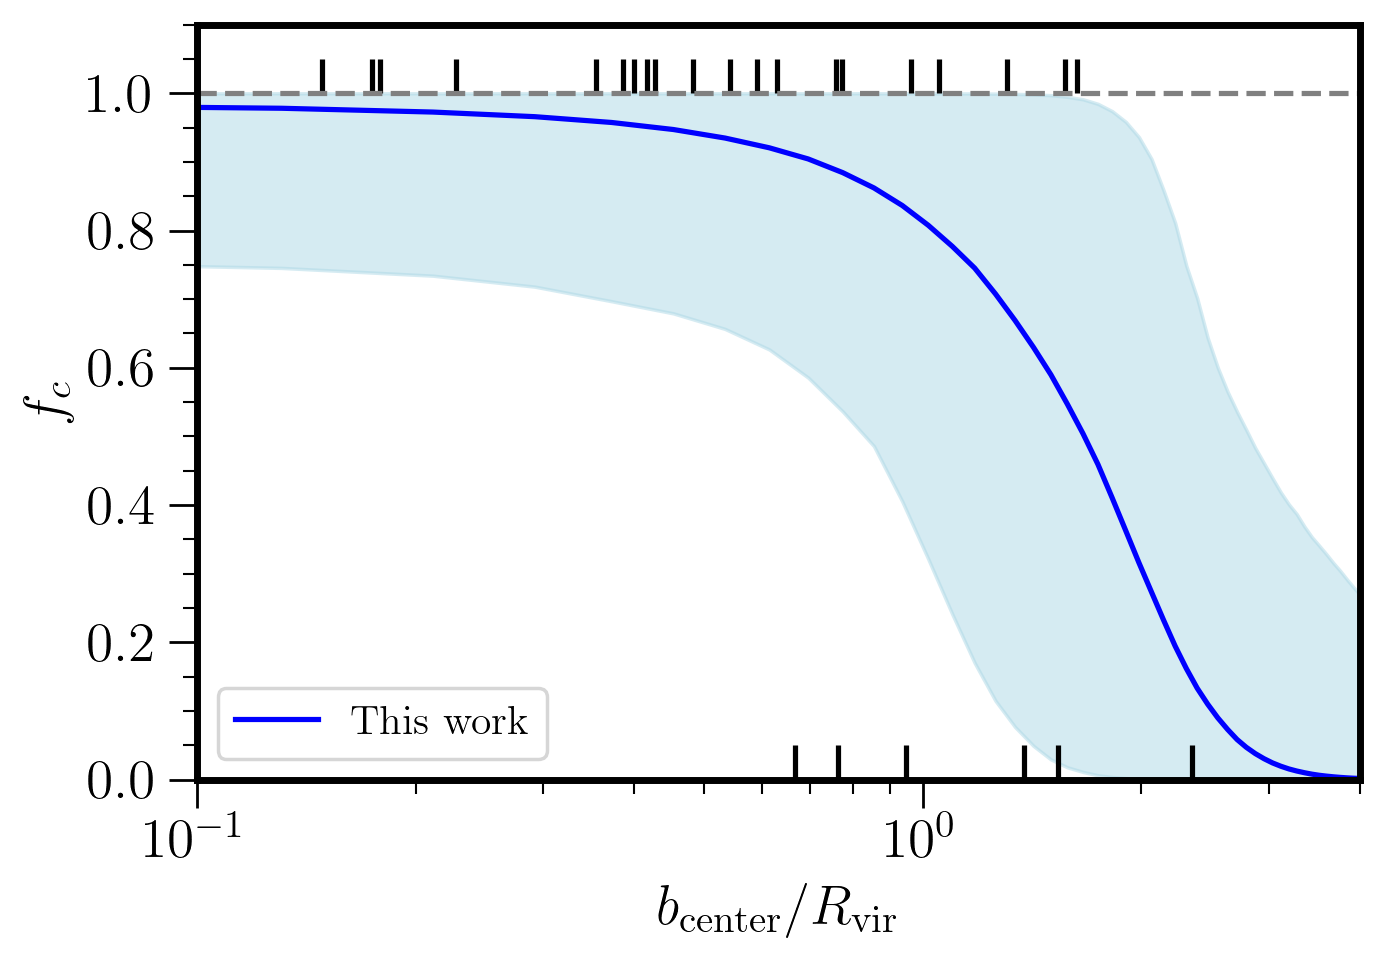

In [253]:
plt.figure(dpi = 250)
plt.rcParams['lines.linewidth']=1.5
plt.axhline(0.0, color = "grey", linestyle = "--")
plt.axhline(1, color = "grey", linestyle = "--")
plt.fill_between(logb_norm, plow, phigh, color = 'lightblue', alpha = 0.5)
plt.plot(logb_norm, pbest, label= "This work", color = "blue")
plt.scatter(fc_G5_bcenter_norm.log_flux, fc_G5_bcenter_norm.outcomes+0.025, marker = "|", color = "black",\
            s = 100)
#plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")

#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
#plt.legend(bbox_to_anchor=(0.5, 1.25), loc = 'center', ncol = 2)
plt.legend(fontsize = 12)
plt.ylim((0.00,1.1))
plt.xlim((0.1,4))
#plt.yscale("log")
plt.xlabel("$b_{\mathrm{center}}/ R_{\mathrm{vir}}$")
plt.ylabel("$f_c$")
plt.xscale("log")

In [254]:
#pbest, plow, phigh = fc_G3_bmin_noz.predict_2d(logb, 1.0, params=fc_G3_bmin_noz.trace)

In [465]:
b = np.linspace(0,350, 100)

In [466]:
pbest, plow, phigh = fc_G4_9_bmin_noz.predict_2d(b, 1.0, params=fc_G4_9_bmin_noz.trace)

INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


In [467]:
fc_cum = []
step = (b[1:] - b[:-1]).mean()
print(step)
for i in b:
    pbest_list = pbest[b<=i]
    fc_cum.append(pbest_list.sum()/(len(pbest_list)))

3.5353535353535355


In [468]:
pbest, plow, phigh = fc_G4_9_bmin_noz.predict_2d(logb, 1.0, params=fc_G4_9_bmin_noz.trace)

In [280]:
rr = Dutta_2020["R(kpc)"].tolist()
fcc = Dutta_2020["fc_groups"].tolist()
rr = np.array([0] + rr)
fcc = np.array([0] + fcc)
fcdiff = (fcc[1:]*rr[1:]**2 - fcc[:-1]*rr[:-1]**2)/(rr[1:]**2-rr[:-1]**2)
fcdiff
rrr = (rr[1:] + rr[:-1])/2

Text(0, 0.5, '$f_c$')

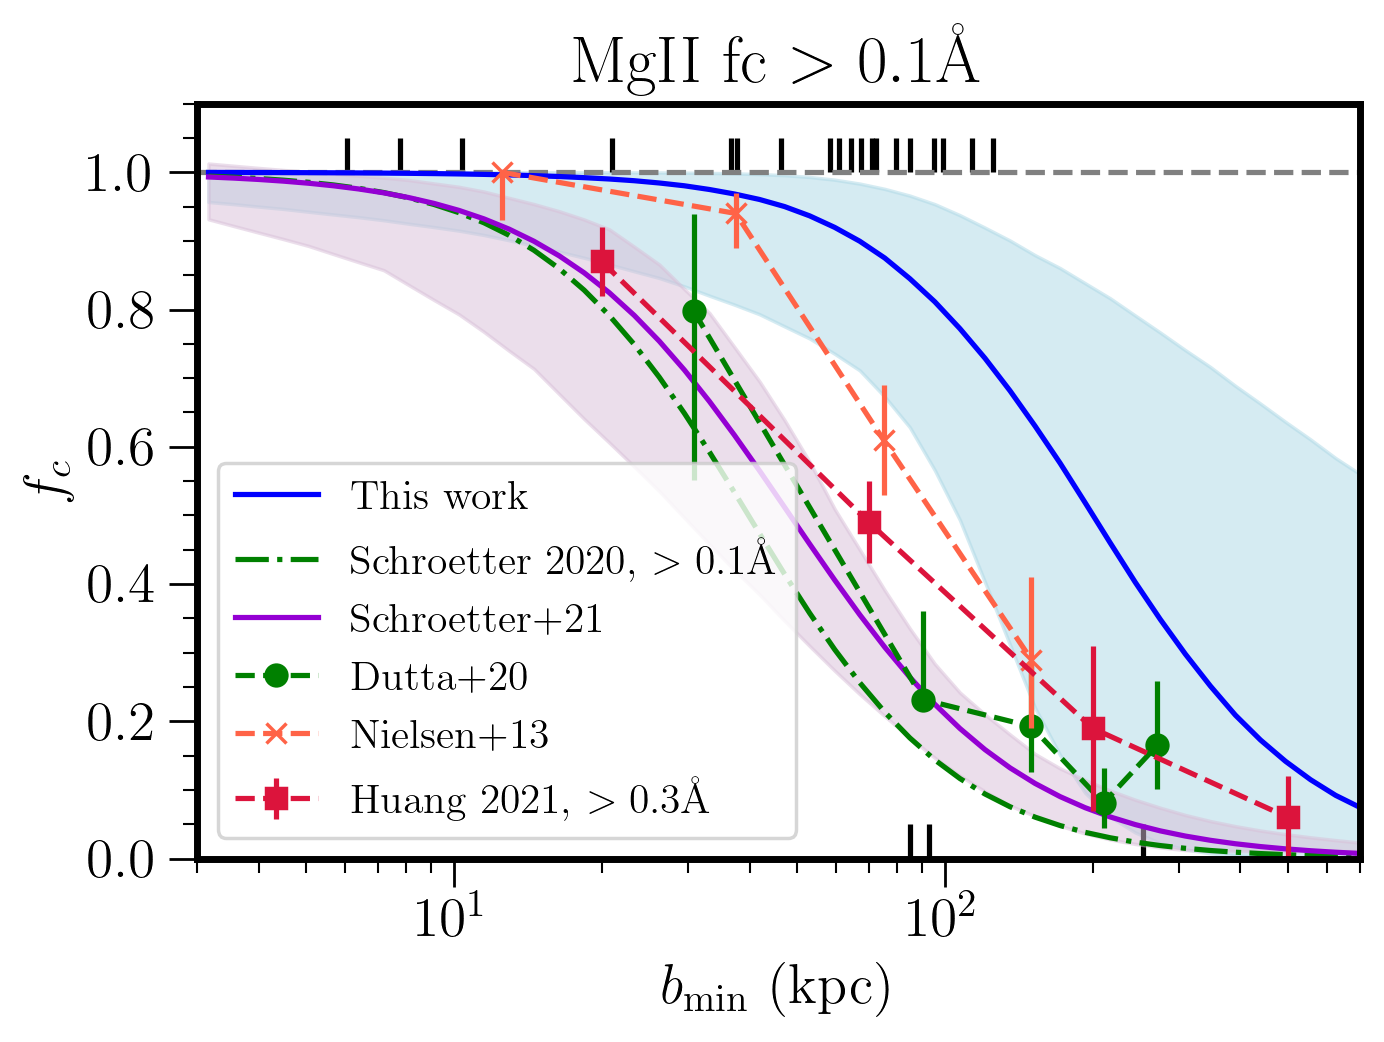

In [469]:
plt.figure(dpi = 250)
plt.rcParams['lines.linewidth']=1.5

plt.title("MgII fc $> 0.1$\AA")

plt.axhline(0.0, color = "grey", linestyle = "--")
plt.axhline(1, color = "grey", linestyle = "--")
plt.fill_between(10**logb, plow, phigh, color = 'lightblue', alpha = 0.5)
plt.plot(10**logb, pbest, label= "This work", color = "blue")
plt.scatter(10**fc_G4_9_bmin_noz.log_flux, fc_G4_9_bmin_noz.outcomes+0.025, marker = "|", color = "black", s = 100)
#plt.scatter(b, fc_cum)

#plt.plot(rrr, fcdiff)

#Schroetter 2020
plt.plot(10**Schroetter_2021["logb"], Schroetter_2021["best_fit_b"], linestyle = "-.",  color = "green", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
plt.plot(10**Schroetter_2021["logb"], Schroetter_2021["best_fit_bz"], linestyle = "-", \
         color = "darkviolet", marker = " ", label = "Schroetter+21")
#plt.plot(10**Schroetter_fc_sup["log_b_sup"], 10**Schroetter_fc_sup["log_fc_sup"])
#plt.plot(10**Schroetter_fc_inf["log_b_inf"], 10**Schroetter_fc_inf["log_fc_inf"])
#plt.plot(10**logb, 10**Sc_logb_sup)
#plt.plot(10**logb, 10**Sc_logb_inf)
plt.fill_between(10**logb, 10**Sc_logb_inf, 10**Sc_logb_sup, color = 'thistle', alpha = 0.5)

#Dutta 2020
#plt.plot(Dutta_2020["R(kpc)"], Dutta_2020["fc_groups"], linestyle = "--", color = "orange", marker = "o", label = "Dutta 2020 groups")
#plt.vlines(Dutta_2020["R(kpc)"], Dutta_2020["fc_groups_inf"], Dutta_2020["fc_groups_sup"], color = "orange", lw=1)
#plt.plot(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol"], linestyle = "--",  color = "red", marker = "o", label = "Dutta 2020 isolated")
#plt.vlines(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol_inf"], Dutta_2020["fc_isol_sup"], color = "red", lw=1)
#plt.plot(Dutta_2020_fcdiff["R(kpc)"], Dutta_2020_fcdiff["fc01"], linestyle = "--", marker = "o", label = "Dutta 01")
#plt.plot(Dutta_2020_fcdiff["R(kpc)"], Dutta_2020_fcdiff["fc03"], linestyle = "--", marker = "o", label = "Dutta 03")
plt.plot(Dutta_2020_fcdiff01["R(kpc)"], Dutta_2020_fcdiff01["fc01"], linestyle = "--", \
            marker = "o", label = "Dutta+20", color = "green")
plt.vlines(Dutta_2020_fcdiff01["R(kpc)"], Dutta_2020_fcdiff01["fc01_inf"], Dutta_2020_fcdiff01["fc01_sup"],\
           color = "green")

#Nielsen 2013
plt.plot(Nielsen_2013["b"], Nielsen_2013["fc01"], color = "tomato", marker = "x", \
         linestyle = '--', label = "Nielsen+13")
plt.vlines(Nielsen_2013["b"], Nielsen_2013["fc01_inf"], Nielsen_2013["fc01_sup"], color = "tomato")
#plt.scatter(Nielsen_2013["b"], Nielsen_2013["fc03"],  color = "orange", marker = "s", label = "Nielsen 2013, $> 0.3$\AA")
#plt.plot(Nielsen_2013["b"], Nielsen_2013["fc1"],  color = "skyblue", marker = "x", label = "Nielsen 2013, 1.0A")

#Huang 2021
plt.errorbar(Huang_2021["b"], Huang_2021["all"], yerr= Huang_2021["all_sigma"],\
             linestyle = '--', color = "crimson", marker = "s", label = "Huang 2021, $> 0.3$\AA")



#plt.legend(bbox_to_anchor=(0.5, 1.12), loc = 'center', ncol = 2)
plt.legend(fontsize = 12)
#plt.ylim((0.05,1.5))
#plt.xlim((2, 700))
plt.ylim((0.0,1.1))
plt.xlim((3, 700))
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$b_{\mathrm{min}}$ (kpc)")
plt.ylabel("$f_c$")

Text(0, 0.5, '$f_c$')

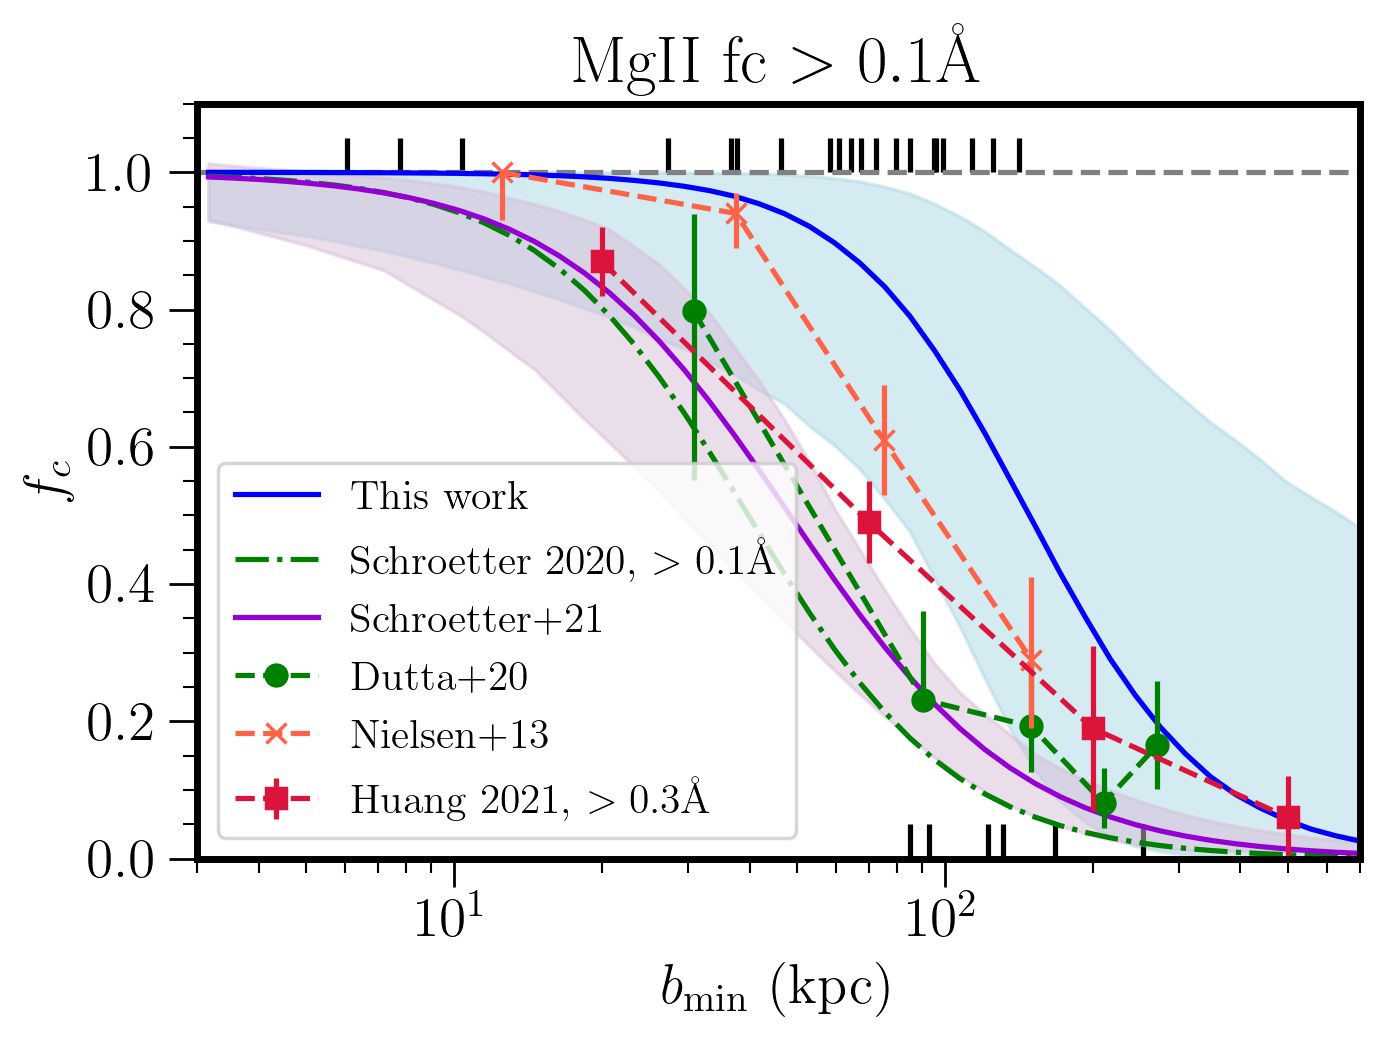

In [483]:
plt.figure(dpi = 250)
plt.rcParams['lines.linewidth']=1.5

plt.title("MgII fc $> 0.1$\AA")

plt.axhline(0.0, color = "grey", linestyle = "--")
plt.axhline(1, color = "grey", linestyle = "--")
plt.fill_between(10**logb, plow, phigh, color = 'lightblue', alpha = 0.5)
plt.plot(10**logb, pbest, label= "This work", color = "blue")
plt.scatter(10**fc_G5_bmin_noz.log_flux, fc_G5_bmin_noz.outcomes+0.025, marker = "|", color = "black", s = 100)
#plt.scatter(b, fc_cum)

#plt.plot(rrr, fcdiff)

#Schroetter 2020
plt.plot(10**Schroetter_2021["logb"], Schroetter_2021["best_fit_b"], linestyle = "-.",  color = "green", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
plt.plot(10**Schroetter_2021["logb"], Schroetter_2021["best_fit_bz"], linestyle = "-", \
         color = "darkviolet", marker = " ", label = "Schroetter+21")
#plt.plot(10**Schroetter_fc_sup["log_b_sup"], 10**Schroetter_fc_sup["log_fc_sup"])
#plt.plot(10**Schroetter_fc_inf["log_b_inf"], 10**Schroetter_fc_inf["log_fc_inf"])
#plt.plot(10**logb, 10**Sc_logb_sup)
#plt.plot(10**logb, 10**Sc_logb_inf)
plt.fill_between(10**logb, 10**Sc_logb_inf, 10**Sc_logb_sup, color = 'thistle', alpha = 0.5)

#Dutta 2020
#plt.plot(Dutta_2020["R(kpc)"], Dutta_2020["fc_groups"], linestyle = "--", color = "orange", marker = "o", label = "Dutta 2020 groups")
#plt.vlines(Dutta_2020["R(kpc)"], Dutta_2020["fc_groups_inf"], Dutta_2020["fc_groups_sup"], color = "orange", lw=1)
#plt.plot(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol"], linestyle = "--",  color = "red", marker = "o", label = "Dutta 2020 isolated")
#plt.vlines(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol_inf"], Dutta_2020["fc_isol_sup"], color = "red", lw=1)
#plt.plot(Dutta_2020_fcdiff["R(kpc)"], Dutta_2020_fcdiff["fc01"], linestyle = "--", marker = "o", label = "Dutta 01")
#plt.plot(Dutta_2020_fcdiff["R(kpc)"], Dutta_2020_fcdiff["fc03"], linestyle = "--", marker = "o", label = "Dutta 03")
plt.plot(Dutta_2020_fcdiff01["R(kpc)"], Dutta_2020_fcdiff01["fc01"], linestyle = "--", \
            marker = "o", label = "Dutta+20", color = "green")
plt.vlines(Dutta_2020_fcdiff01["R(kpc)"], Dutta_2020_fcdiff01["fc01_inf"], Dutta_2020_fcdiff01["fc01_sup"],\
           color = "green")

#Nielsen 2013
plt.plot(Nielsen_2013["b"], Nielsen_2013["fc01"], color = "tomato", marker = "x", \
         linestyle = '--', label = "Nielsen+13")
plt.vlines(Nielsen_2013["b"], Nielsen_2013["fc01_inf"], Nielsen_2013["fc01_sup"], color = "tomato")
#plt.scatter(Nielsen_2013["b"], Nielsen_2013["fc03"],  color = "orange", marker = "s", label = "Nielsen 2013, $> 0.3$\AA")
#plt.plot(Nielsen_2013["b"], Nielsen_2013["fc1"],  color = "skyblue", marker = "x", label = "Nielsen 2013, 1.0A")

#Huang 2021
plt.errorbar(Huang_2021["b"], Huang_2021["all"], yerr= Huang_2021["all_sigma"],\
             linestyle = '--', color = "crimson", marker = "s", label = "Huang 2021, $> 0.3$\AA")



#plt.legend(bbox_to_anchor=(0.5, 1.12), loc = 'center', ncol = 2)
plt.legend(fontsize = 12)
#plt.ylim((0.05,1.5))
#plt.xlim((2, 700))
plt.ylim((0.0,1.1))
plt.xlim((3, 700))
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$b_{\mathrm{min}}$ (kpc)")
plt.ylabel("$f_c$")

In [485]:
len(logb)

50

Text(0, 0.5, '$f_c$')

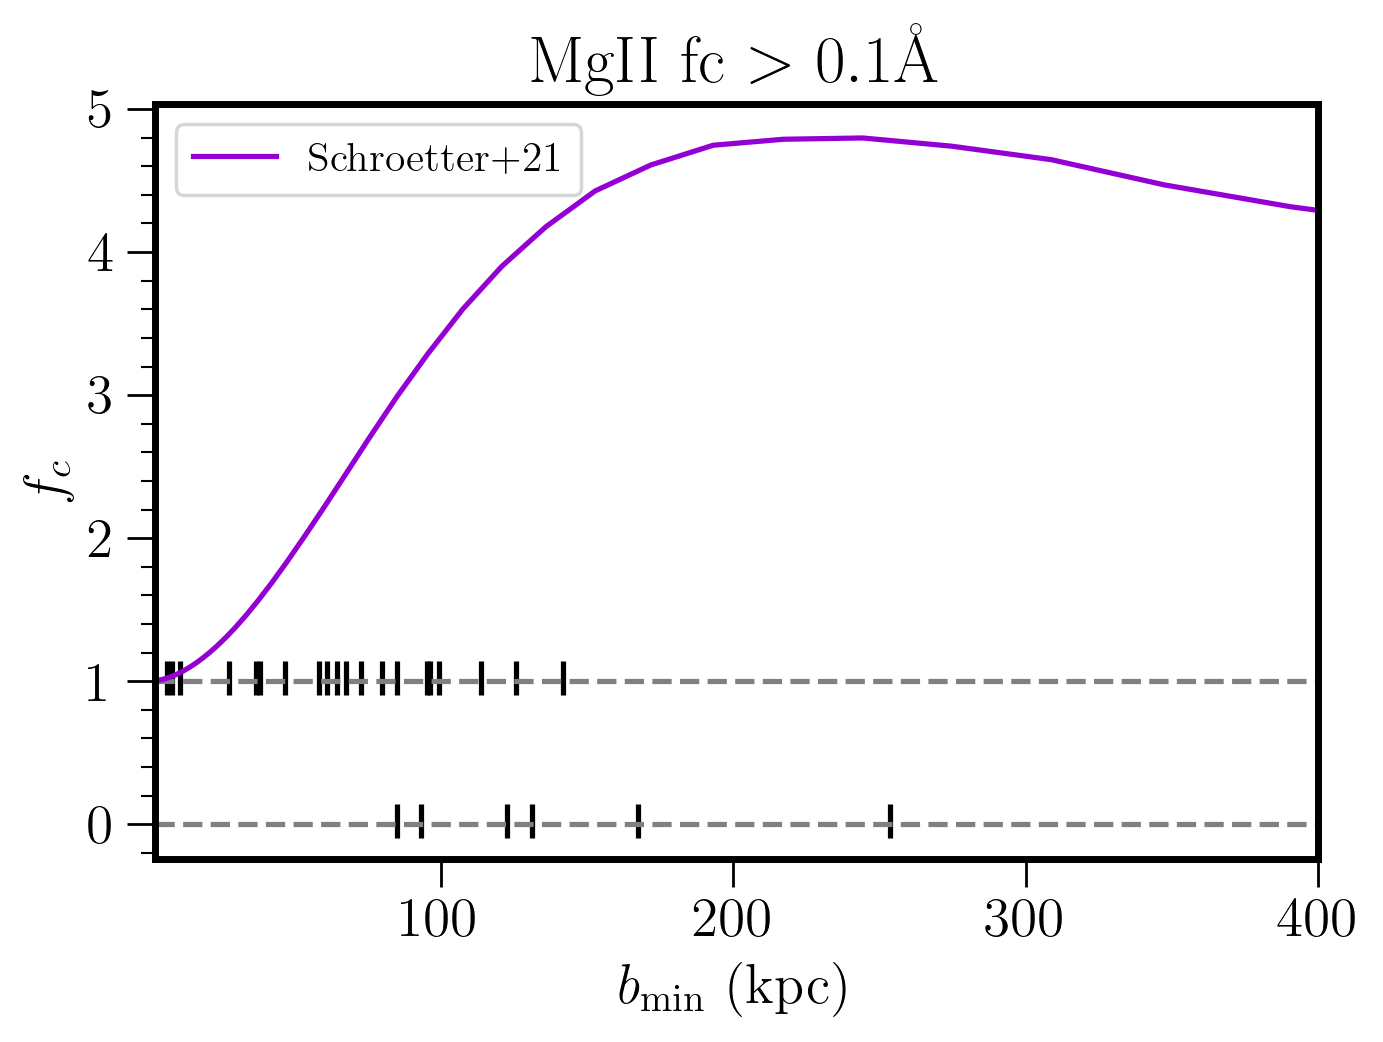

In [489]:
plt.figure(dpi = 250)
plt.rcParams['lines.linewidth']=1.5

plt.title("MgII fc $> 0.1$\AA")

plt.axhline(0.0, color = "grey", linestyle = "--")
plt.axhline(1, color = "grey", linestyle = "--")
#plt.fill_between(10**logb, plow, phigh, color = 'lightblue', alpha = 0.5)
#plt.plot(10**logb, pbest, label= "This work", color = "blue")
plt.scatter(10**fc_G5_bmin_noz.log_flux, fc_G5_bmin_noz.outcomes+0.025, marker = "|", color = "black", s = 100)
#plt.scatter(b, fc_cum)

#plt.plot(rrr, fcdiff)

#Schroetter 2020
#plt.plot(10**Schroetter_2021["logb"], Schroetter_2021["best_fit_b"], linestyle = "-.",  color = "green", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
plt.plot(10**Schroetter_2021["logb"], pbest/Schroetter_2021["best_fit_bz"], linestyle = "-", \
         color = "darkviolet", marker = " ", label = "Schroetter+21")
#plt.plot(10**Schroetter_fc_sup["log_b_sup"], 10**Schroetter_fc_sup["log_fc_sup"])
#plt.plot(10**Schroetter_fc_inf["log_b_inf"], 10**Schroetter_fc_inf["log_fc_inf"])
#plt.plot(10**logb, 10**Sc_logb_sup)
#plt.plot(10**logb, 10**Sc_logb_inf)
#plt.fill_between(10**logb, 10**Sc_logb_inf, 10**Sc_logb_sup, color = 'thistle', alpha = 0.5)


#plt.legend(bbox_to_anchor=(0.5, 1.12), loc = 'center', ncol = 2)
plt.legend(fontsize = 12)
#plt.ylim((0.05,1.5))
plt.xlim((2, 400))
#plt.ylim((0.0,1.1))
#plt.xlim((3, 700))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$b_{\mathrm{min}}$ (kpc)")
plt.ylabel("$f_c$")

In [261]:
Huang_2021

b   all  all_sigma  blue   red
0   20.0  0.87       0.05  0.92  0.67
1   70.0  0.49       0.06  0.56  0.41
2  200.0  0.19       0.12  0.19  0.09
3  500.0  0.06       0.06  0.08  0.04

We would like to compare with Dutta 2020. For that we need to compute the cumulative covering fraction. A method would be to bin by impact parameter, and to count the number of absorbers. But it should be possible to do derive it directly from the differential fc. the differential fc is equivalent to :
\begin{equation}
fc = lim \frac{N_{abs}(b-db; b+db)}{N_{tot}(b-db; b+db)}
 \end{equation}
 
 The cumulative fc is:
 \begin{equation}
fc = lim \frac{N_{abs}(0; b)}{N_{tot}(0; b)}
 \end{equation}
 
 If we use bins. the cumulative fc is the sum of the differential fc with lower b.

### Fc as a function of bmin and REW:

In [564]:
G4_9_bmin_lin = G4_9[["b_min_kpc", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2", "REW_2796"]]
G4_9_bmin_lin = G4_9_bmin_lin.rename(columns = {"b_min_kpc": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})

G4_9_bmin_log = G4_9_bmin_lin.copy()
G4_9_bmin_log["log10(b)"] = np.log10(G4_9_bmin_lin["b"])

In [568]:
G_01 = G4_9_bmin_log.copy()
G_03 = G4_9_bmin_log.copy()
G_05 = G4_9_bmin_log.copy()
G_08 = G4_9_bmin_log.copy()
G_1 = G4_9_bmin_log.copy()
G_15 = G4_9_bmin_log.copy()



G_01["detection"] = G_01["REW_2796"]>= 0.1
G_03["detection"] = G_03["REW_2796"]>= 0.3
G_05["detection"] = G_05["REW_2796"]>= 0.5
G_08["detection"] = G_08["REW_2796"]>= 0.8
G_1["detection"] = G_1["REW_2796"]>= 1
G_15["detection"] = G_15["REW_2796"]>= 1.5

G_01["detection"] = G_01["detection"].astype(int)
G_03["detection"] = G_03["detection"].astype(int)
G_05["detection"] = G_05["detection"].astype(int)
G_08["detection"] = G_08["detection"].astype(int)
G_1["detection"] = G_1["detection"].astype(int)
G_15["detection"] = G_15["detection"].astype(int)

G_01_save = G_01[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_03_save = G_03[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_05_save = G_05[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_08_save = G_08[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_1_save = G_1[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_15_save = G_15[["group_id", "log10(b)","detection", "z_gal", "mass"]]

G_01_save.to_csv("fc_data/G_01.csv", index = False)
G_03_save.to_csv("fc_data/G_03.csv", index = False)
G_05_save.to_csv("fc_data/G_05.csv", index = False)
G_08_save.to_csv("fc_data/G_08.csv", index = False)
G_1_save.to_csv("fc_data/G_1.csv", index = False)
G_15_save.to_csv("fc_data/G_15.csv", index = False)

MgII_closest_only
Reading from None
LEN (Outcomes) 22


INFO (theano.gof.compilelock): Waiting for existing lock by process '4446' (I am process '15170')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:05<00:00, 1530.02draws/s]
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.063247 -11.106603 -7.558039 -4.646632 -2.551345 -1.500223
beta   2.355554   2.025541  2.126555  2.297192  2.623787  2.936827
alpha -4.6 [-11.11--1.50] (95\%) 
beta 2.3 [2.03-2.94] (95\%) 

WAIC 14.86 +/- 5.31 peff 1.10
WAIC deviance 12.668917569332791
LOO 14.93 +/- 5.35 peff 1.13
WBIC  22.70290534974406
Deviance Lmax 16.3502
DIC Lmax 21.2142 2.43
Deviance best 16.4730
DIC best 21.0914 2.31
|              WAIC |                LOO |              WBIC |                DIC |
| 14.86386527917734 | 14.926905260284894 | 22.70290534974406 | 21.091362935254264 |
['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.063247 -11.106603 -7.558039 -4.646632 -2.551345 -1.500223
beta   2.355554   2.025541  2.126555  2.297192  2.623787  2.936827


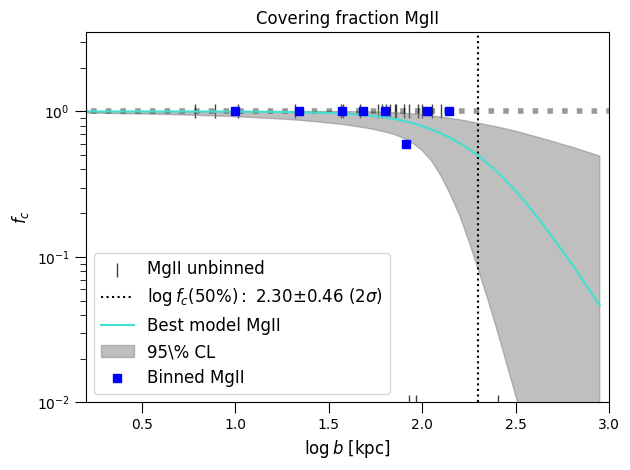

In [569]:
fc_G_01 = run_covering_2.mgii(run = True, filename = "fc_data/G_01.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:05<00:00, 1783.97draws/s]
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5494987265491181, but should be close to 0.8. Try to increase the number of tuning steps.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


['alpha', 'beta']
          mean        2.5      16.0      50.0      84.0      97.5
alpha -5.84853 -12.822795 -8.829958 -5.370242 -2.881303 -1.491171
beta   2.22679   1.962973  2.045243  2.170853  2.424812  2.758229
alpha -5.4 [-12.82--1.49] (95\%) 
beta 2.2 [1.96-2.76] (95\%) 

WAIC 15.64 +/- 4.44 peff 1.04
WAIC deviance 13.550463004310668
LOO 15.68 +/- 4.46 peff 1.06
WBIC  22.993023247196817
Deviance Lmax 17.2218
DIC Lmax 21.8463 2.31
Deviance best 17.3299
DIC best 21.7382 2.20
|               WAIC |               LOO |               WBIC |                DIC |
| 15.638452208855627 | 15.67736801468596 | 22.993023247196817 | 21.738198544489766 |
['alpha', 'beta']
          mean        2.5      16.0      50.0      84.0      97.5
alpha -5.84853 -12.822795 -8.829958 -5.370242 -2.881303 -1.491171
beta   2.22679   1.962973  2.045243  2.170853  2.424812  2.758229


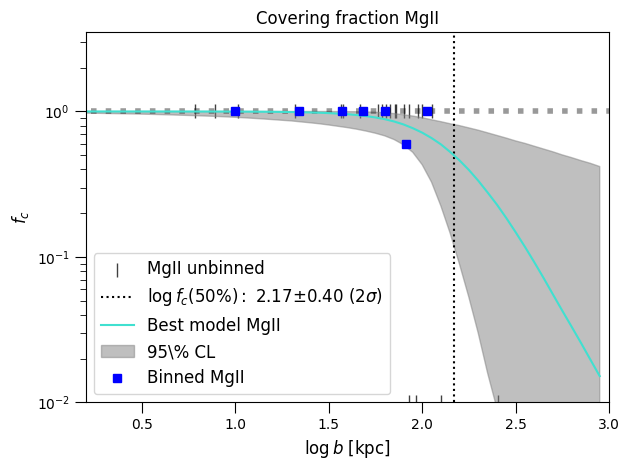

In [570]:
fc_G_03 = run_covering_2.mgii(run = True, filename = "fc_data/G_03.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:05<00:00, 1718.27draws/s]
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -6.763746 -13.673882 -9.984694 -6.484117 -3.589949 -1.725642
beta   2.115443   1.902175  1.982679  2.077566  2.237552  2.594251
alpha -6.5 [-13.67--1.73] (95\%) 
beta 2.1 [1.90-2.59] (95\%) 

WAIC 15.61 +/- 3.65 peff 0.97
WAIC deviance 13.665636948637598
LOO 15.63 +/- 3.65 peff 0.98
WBIC  23.114074538776194
Deviance Lmax 17.6434
DIC Lmax 22.0640 2.21
Deviance best 17.7144
DIC best 21.9930 2.14
|               WAIC |                LOO |               WBIC |               DIC |
| 15.611729611300865 | 15.628947231732223 | 23.114074538776194 | 21.99296536285854 |
['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -6.763746 -13.673882 -9.984694 -6.484117 -3.589949 -1.725642
beta   2.115443   1.902175  1.982679  2.077566  2.237552  2.594251


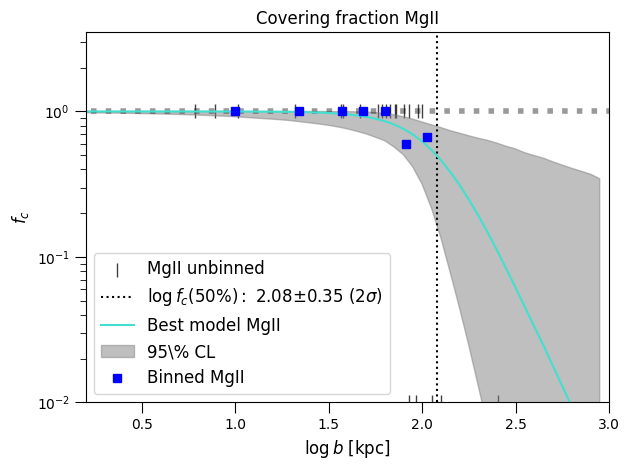

In [571]:
fc_G_05 = run_covering_2.mgii(run = True, filename = "fc_data/G_05.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:03<00:00, 2849.47draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


['alpha', 'beta']
           mean      2.5      16.0      50.0      84.0      97.5
alpha -1.295604 -4.10628 -2.507993 -1.103283 -0.165296  0.586826
beta   1.857686  0.83274  1.503802  1.853790  2.255998  2.751464
alpha -1.1 [-4.11-0.58] (95\%) 
beta 1.9 [0.83-2.75] (95\%) 

WAIC 31.75 +/- 2.72 peff 1.67
WAIC deviance 28.417381768766464
LOO 31.86 +/- 2.79 peff 1.72
WBIC  27.25456868784057
Deviance Lmax 30.7847
DIC Lmax 35.2960 2.26
Deviance best 31.0341
DIC best 35.0466 2.01
|               WAIC |               LOO |              WBIC |               DIC |
| 31.750470135520885 | 31.85908016870024 | 27.25456868784057 | 35.04659835893048 |
['alpha', 'beta']
           mean      2.5      16.0      50.0      84.0      97.5
alpha -1.295604 -4.10628 -2.507993 -1.103283 -0.165296  0.586826
beta   1.857686  0.83274  1.503802  1.853790  2.255998  2.751464


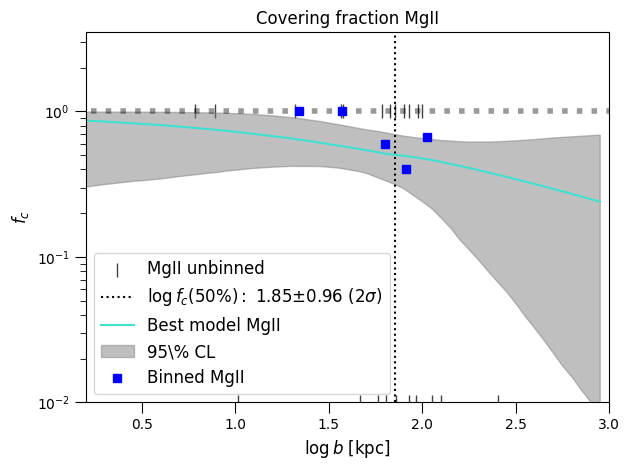

In [585]:
fc_G_08 = run_covering_2.mgii(run = True, filename = "fc_data/G_08.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:03<00:00, 2929.36draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -1.324693 -4.318687 -2.536297 -1.116708 -0.143352  0.549668
beta   1.670575  0.622623  1.288231  1.669316  2.050233  2.712621
alpha -1.1 [-4.32-0.54] (95\%) 
beta 1.7 [0.62-2.71] (95\%) 

WAIC 31.72 +/- 2.49 peff 1.66
WAIC deviance 28.40810156648097
LOO 31.86 +/- 2.57 peff 1.73
WBIC  27.25975410848338
Deviance Lmax 30.7092
DIC Lmax 35.4104 2.35
Deviance best 30.9898
DIC best 35.1298 2.07
|               WAIC |                LOO |              WBIC |              DIC |
| 31.718505946782127 | 31.860388332585796 | 27.25975410848338 | 35.1298248324734 |
['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -1.324693 -4.318687 -2.536297 -1.116708 -0.143352  0.549668
beta   1.670575  0.622623  1.288231  1.669316  2.050233  2.712621


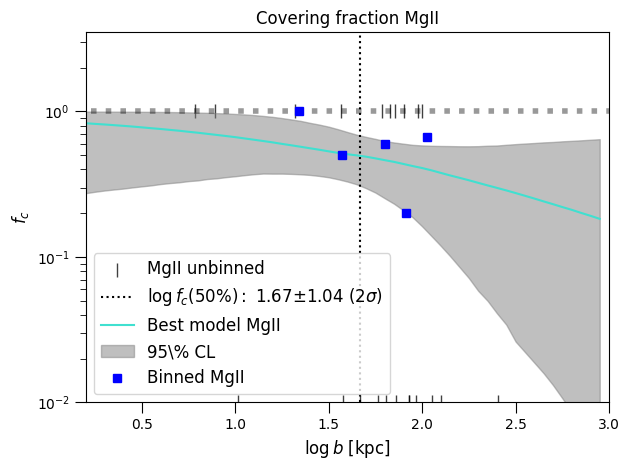

In [584]:
fc_G_1 = run_covering_2.mgii(run = True, filename = "fc_data/G_1.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:04<00:00, 2029.18draws/s]
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -3.853273 -7.617335 -5.473401 -3.648292 -2.241287 -1.111125
beta   1.261904  0.668337  1.051502  1.297440  1.476102  1.627786
alpha -3.6 [-7.62--1.11] (95\%) 
beta 1.3 [0.67-1.63] (95\%) 

WAIC 19.73 +/- 6.18 peff 1.97
WAIC deviance 15.800783348830683
LOO 20.20 +/- 6.43 peff 2.20
WBIC  23.65056232433023
Deviance Lmax 19.0794
DIC Lmax 23.5465 2.23
Deviance best 19.0962
DIC best 23.5297 2.22
|               WAIC |                LOO |              WBIC |               DIC |
| 19.731826572540943 | 20.200424357145653 | 23.65056232433023 | 23.52972446004962 |
['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -3.853273 -7.617335 -5.473401 -3.648292 -2.241287 -1.111125
beta   1.261904  0.668337  1.051502  1.297440  1.476102  1.627786


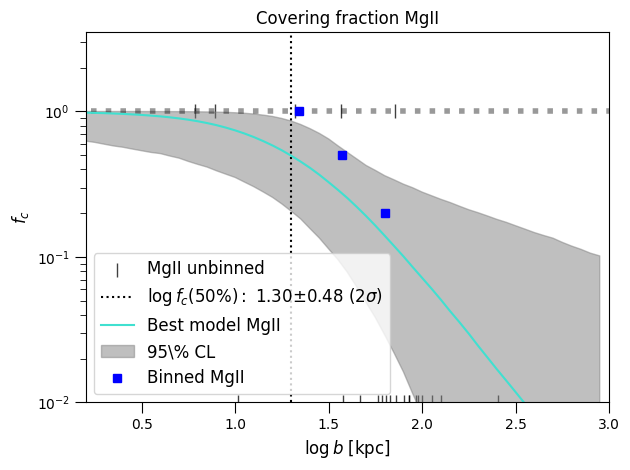

In [574]:
fc_G_15 = run_covering_2.mgii(run = True, filename = "fc_data/G_15.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

In [586]:
# The ranges for the parameters:
logb = np.linspace(0.1, 2.5, 50)
logm = np.linspace(8, 12, 20)
logsfr = np.linspace(-3, 3, 20)
z_range = np.linspace(0.4, 1.5, 20)
logz = np.log10(1+z_range)

# The fixed values to estimates the fc:
z = 1
Z = np.log10(1+z)
m = 9
sfr = 0

# The extraction of the low, middle, high values:
pbest_G_01, plow_G_01, phigh_G_01 = \
    fc_G_01.predict_2d(logb, params=fc_G_01.trace, z = 1)
pbest_G_03, plow_G_03, phigh_G_03 = \
    fc_G_03.predict_2d(logb, params=fc_G_03.trace, z = 1)
pbest_G_05, plow_G_05, phigh_G_05 = \
    fc_G_05.predict_2d(logb, params=fc_G_05.trace, z = 1)
pbest_G_08, plow_G_08, phigh_G_08 = \
    fc_G_08.predict_2d(logb, params=fc_G_08.trace, z = 1)
pbest_G_1, plow_G_1, phigh_G_1 = \
    fc_G_1.predict_2d(logb, params=fc_G_1.trace, z = 1)
pbest_G_15, plow_G_15, phigh_G_15 = \
    fc_G_15.predict_2d(logb, params=fc_G_15.trace, z = 1)

Text(0, 0.5, '$f_c$')

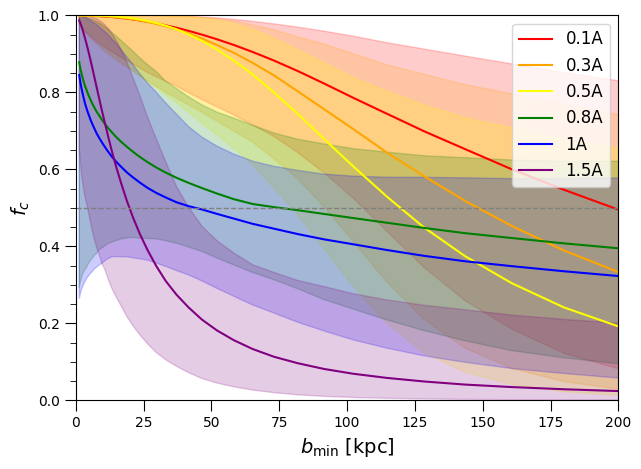

In [588]:
plt.figure(figsize = (7,5), dpi = 100)

#plt.rcParams['lines.linewidth']=1.5
#plt.axhline(0.0, color = "grey", linestyle = "--")
#plt.axhline(1, color = "grey", linestyle = "--")

plt.fill_between(10**logb, plow_G_01, phigh_G_01, color = 'red', alpha = 0.2)
plt.plot(10**logb, pbest_G_01, label= "0.1A", color = "red")

plt.fill_between(10**logb, plow_G_03, phigh_G_03, color = 'orange', alpha = 0.2)
plt.plot(10**logb, pbest_G_03, label= "0.3A", color = "orange")

plt.fill_between(10**logb, plow_G_05, phigh_G_05, color = 'yellow', alpha = 0.2)
plt.plot(10**logb, pbest_G_05, label= "0.5A", color = "yellow")

plt.fill_between(10**logb, plow_G_08, phigh_G_08, color = 'green', alpha = 0.2)
plt.plot(10**logb, pbest_G_08, label= "0.8A", color = "green")

plt.fill_between(10**logb, plow_G_1, phigh_G_1, color = 'blue', alpha = 0.2)
plt.plot(10**logb, pbest_G_1, label= "1A", color = "blue")

plt.fill_between(10**logb, plow_G_15, phigh_G_15, color = 'purple', alpha = 0.2)
plt.plot(10**logb, pbest_G_15, label= "1.5A", color = "purple")

#plt.fill_between(10**logb, plow_isol_2_z_mass_SFR, phigh_isol_2_z_mass_SFR, color = 'deeppink', alpha = 0.2)
#plt.plot(10**logb, pbest_isol_2_z_mass_SFR, label= "2A", color = "deeppink")

#plt.plot(10**logb, pp_Ilane, color = "black", linestyle = "dotted", label = "Schroetter 2021")
#plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")

#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
#plt.legend(bbox_to_anchor=(0.5, 1.25), loc = 'center', ncol = 2)
plt.legend(fontsize = 12)
plt.ylim((0.0,1.))
plt.xlim((0,200))
plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")


plt.xlabel("$b_{\mathrm{min}}$ [kpc]", size = 14)
plt.ylabel("$f_c$", size = 14)
#plt.yscale("log")
#plt.xscale("log")

### Fc as a function of bcenter/Rvir and REW:

In [617]:
G4_9_bcenter_norm_lin = G4_9[["b_center_kpc_norm2", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2", "REW_2796"]]
G4_9_bcenter_norm_lin = G4_9_bcenter_norm_lin.rename(columns = {"b_center_kpc_norm2": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G4_9_bcenter_norm_log = G4_9_bcenter_norm_lin.copy()
G4_9_bcenter_norm_log["log10(b)"] = np.log10(G4_9_bcenter_norm_lin["b"])

G4_9_bcenter_norm_lin = G4_9[["b_center_kpc_norm2", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2", "REW_2796"]]
G4_9_bcenter_norm_lin = G4_9_bcenter_norm_lin.rename(columns = {"b_center_kpc_norm2": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G4_9_bcenter_norm_lin["log10(b)"] = G4_9_bcenter_norm_lin["b"]

In [618]:
G_01 = G4_9_bcenter_norm_log.copy()
G_03 = G4_9_bcenter_norm_log.copy()
G_05 = G4_9_bcenter_norm_log.copy()
G_08 = G4_9_bcenter_norm_log.copy()
G_1 = G4_9_bcenter_norm_log.copy()
G_15 = G4_9_bcenter_norm_log.copy()



G_01["detection"] = G_01["REW_2796"]>= 0.1
G_03["detection"] = G_03["REW_2796"]>= 0.3
G_05["detection"] = G_05["REW_2796"]>= 0.5
G_08["detection"] = G_08["REW_2796"]>= 0.8
G_1["detection"] = G_1["REW_2796"]>= 1
G_15["detection"] = G_15["REW_2796"]>= 1.5

G_01["detection"] = G_01["detection"].astype(int)
G_03["detection"] = G_03["detection"].astype(int)
G_05["detection"] = G_05["detection"].astype(int)
G_08["detection"] = G_08["detection"].astype(int)
G_1["detection"] = G_1["detection"].astype(int)
G_15["detection"] = G_15["detection"].astype(int)

G_01_save = G_01[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_03_save = G_03[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_05_save = G_05[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_08_save = G_08[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_1_save = G_1[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_15_save = G_15[["group_id", "log10(b)","detection", "z_gal", "mass"]]

G_01_save.to_csv("fc_data/G_01.csv", index = False)
G_03_save.to_csv("fc_data/G_03.csv", index = False)
G_05_save.to_csv("fc_data/G_05.csv", index = False)
G_08_save.to_csv("fc_data/G_08.csv", index = False)
G_1_save.to_csv("fc_data/G_1.csv", index = False)
G_15_save.to_csv("fc_data/G_15.csv", index = False)

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:04<00:00, 2088.21draws/s]
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -3.745366 -9.846985 -6.433308 -3.147542 -1.238038 -0.661032
beta   0.802860  0.127304  0.267012  0.574653  1.476333  2.338091
alpha -3.1 [-9.85--0.66] (95\%) 
beta 0.6 [0.13-2.34] (95\%) 

WAIC 15.31 +/- 5.21 peff 1.33
WAIC deviance 12.658076853707767
LOO 15.37 +/- 5.24 peff 1.36
WBIC  23.22994923223943
Deviance Lmax 17.7717
DIC Lmax 22.5542 2.39
Deviance best 18.4670
DIC best 21.8589 1.70
|               WAIC |                LOO |              WBIC |              DIC |
| 15.310928529097884 | 15.373745411311369 | 23.22994923223943 | 21.8588939087289 |
['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -3.745366 -9.846985 -6.433308 -3.147542 -1.238038 -0.661032
beta   0.802860  0.127304  0.267012  0.574653  1.476333  2.338091


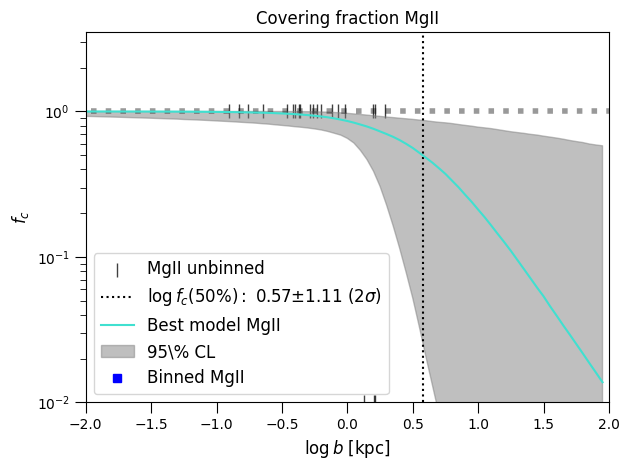

In [619]:
fc_G_01 = run_covering_2.mgii(run = True, filename = "fc_data/G_01.csv", xlim = [-2, 2],\
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:03<00:00, 2660.25draws/s]
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7137288639857601, but should be close to 0.8. Try to increase the number of tuning steps.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


['alpha', 'beta']
           mean        2.5     16.0      50.0      84.0      97.5
alpha -5.953227 -12.453836 -8.95065 -5.722880 -2.780725 -1.081866
beta   0.352801   0.046816  0.13482  0.257929  0.559157  1.277629
alpha -5.7 [-12.45--1.08] (95\%) 
beta 0.3 [0.05-1.28] (95\%) 

WAIC 13.53 +/- 3.79 peff 1.20
WAIC deviance 11.131982049663963
LOO 13.57 +/- 3.81 peff 1.22
WBIC  23.798797094479745
Deviance Lmax 19.7505
DIC Lmax 23.7066 1.98
Deviance best 19.8120
DIC best 23.6452 1.92
|               WAIC |                LOO |               WBIC |                DIC |
| 13.533800274127913 | 13.565041558584465 | 23.798797094479745 | 23.645170244673793 |
['alpha', 'beta']
           mean        2.5     16.0      50.0      84.0      97.5
alpha -5.953227 -12.453836 -8.95065 -5.722880 -2.780725 -1.081866
beta   0.352801   0.046816  0.13482  0.257929  0.559157  1.277629


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


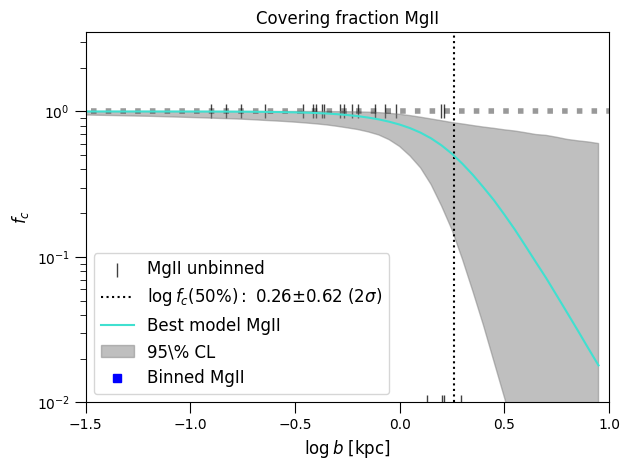

In [623]:
fc_G_03 = run_covering_2.mgii(run = True, filename = "fc_data/G_03.csv", xlim = [-1.5, 1],\
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:03<00:00, 2763.47draws/s]
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -4.988783 -10.767462 -7.624719 -4.780527 -2.188083 -0.846193
beta   0.343310   0.022175  0.095648  0.220341  0.551140  1.473654
alpha -4.8 [-10.77--0.85] (95\%) 
beta 0.2 [0.02-1.47] (95\%) 

WAIC 17.03 +/- 4.36 peff 1.27
WAIC deviance 14.482320800388068
LOO 17.05 +/- 4.37 peff 1.28
WBIC  24.9265172928727


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


Deviance Lmax 23.0625
DIC Lmax 27.0806 2.01
Deviance best 23.1649
DIC best 26.9782 1.91
|              WAIC |                LOO |             WBIC |                DIC |
| 17.02868630952866 | 17.052220748447457 | 24.9265172928727 | 26.978184102052772 |
['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -4.988783 -10.767462 -7.624719 -4.780527 -2.188083 -0.846193
beta   0.343310   0.022175  0.095648  0.220341  0.551140  1.473654


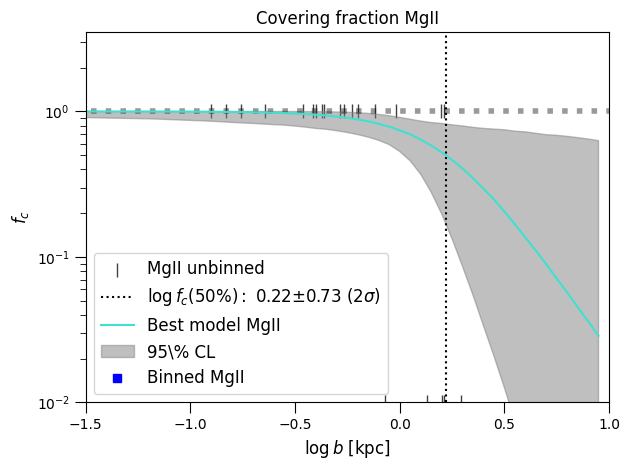

In [625]:
fc_G_05 = run_covering_2.mgii(run = True, filename = "fc_data/G_05.csv", xlim = [-1.5, 1],\
                            with_outliers= "",redshift = False, mass = False, errorbar = False, \
                              Nsample = 8000, burnin = 800)

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 17000/17000 [00:06<00:00, 2576.63draws/s]
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6796896485721617, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -1.325991 -4.865719 -2.806118 -0.813493 -0.117965  0.169077
beta   0.791543  0.008265  0.062718  0.463958  1.744087  2.667049
alpha -0.8 [-4.87-0.17] (95\%) 
beta 0.5 [0.01-2.67] (95\%) 

WAIC 30.85 +/- 4.11 peff 1.93
WAIC deviance 26.99434914571539
LOO 31.20 +/- 4.40 peff 2.10
WBIC  27.950638178847544


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


Deviance Lmax 32.2761
DIC Lmax 39.1619 3.44
Deviance best 34.2225
DIC best 37.2155 1.50
|              WAIC |               LOO |               WBIC |               DIC |
| 30.85108143199366 | 31.19622339602238 | 27.950638178847544 | 37.21546056769364 |
['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -1.325991 -4.865719 -2.806118 -0.813493 -0.117965  0.169077
beta   0.791543  0.008265  0.062718  0.463958  1.744087  2.667049


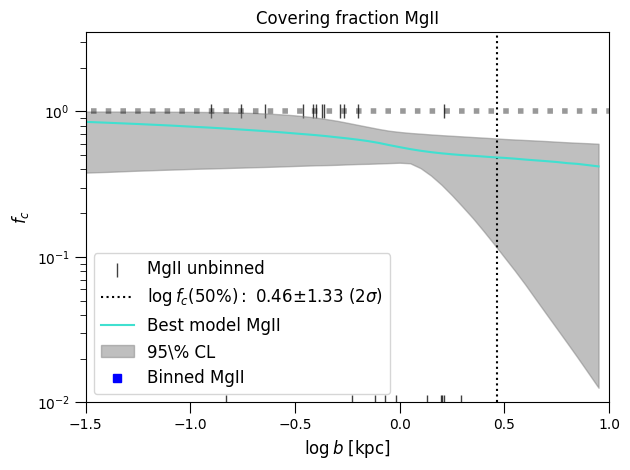

In [629]:
fc_G_08 = run_covering_2.mgii(run = True, filename = "fc_data/G_08.csv", xlim = [-1.5, 1], \
                            with_outliers= "",redshift = False, mass = False, errorbar = False, \
                              Nsample = 8000, burnin = 800)

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 17000/17000 [00:05<00:00, 3062.65draws/s]
The number of effective samples is smaller than 25% for some parameters.


['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0     97.5
alpha -0.255727 -2.277639 -0.682809 -0.069197  0.203669  0.54313
beta   1.271495  0.028500  0.268624  1.254042  2.214809  2.80523
alpha -0.1 [-2.28-0.54] (95\%) 
beta 1.3 [0.03-2.80] (95\%) 

WAIC 32.60 +/- 0.75 peff 1.32
WAIC deviance 29.955276929761336
LOO 32.66 +/- 0.80 peff 1.35
WBIC  28.060463793453778


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


Deviance Lmax 33.0339
DIC Lmax 39.2753 3.12
Deviance best 33.5503
DIC best 38.7589 2.60
|              WAIC |               LOO |               WBIC |                DIC |
| 32.59607875433892 | 32.65845312979261 | 28.060463793453778 | 38.758891773477124 |
['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0     97.5
alpha -0.255727 -2.277639 -0.682809 -0.069197  0.203669  0.54313
beta   1.271495  0.028500  0.268624  1.254042  2.214809  2.80523


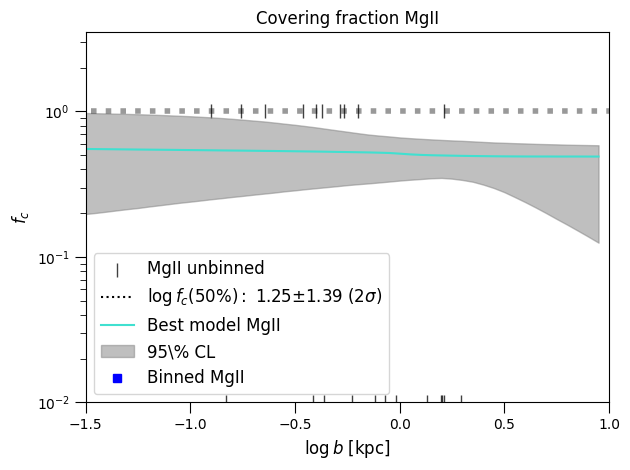

In [632]:
fc_G_1 = run_covering_2.mgii(run = True, filename = "fc_data/G_1.csv", xlim = [-1.5, 1],\
                            with_outliers= "",redshift = False, mass = False, errorbar = False,\
                            Nsample = 8000, burnin = 800)

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:02<00:00, 3147.62draws/s]


['alpha', 'beta']
          mean       2.5      16.0      50.0      84.0      97.5
alpha  0.50562  0.020227  0.240782  0.466880  0.769508  1.239991
beta   1.86648  0.545688  1.173133  1.909542  2.576769  2.927232
alpha 0.5 [0.02-1.24] (95\%) 
beta 1.9 [0.55-2.93] (95\%) 

WAIC 28.52 +/- 4.89 peff 1.42
WAIC deviance 25.668328423091808
LOO 28.54 +/- 4.89 peff 1.43
WBIC  26.611010812691394


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


Deviance Lmax 28.2513
DIC Lmax 33.1243 2.44
Deviance best 28.2624
DIC best 33.1133 2.43
|              WAIC |               LOO |               WBIC |                DIC |
| 28.51606392023789 | 28.53571421139857 | 26.611010812691394 | 33.113290276736635 |
['alpha', 'beta']
          mean       2.5      16.0      50.0      84.0      97.5
alpha  0.50562  0.020227  0.240782  0.466880  0.769508  1.239991
beta   1.86648  0.545688  1.173133  1.909542  2.576769  2.927232


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


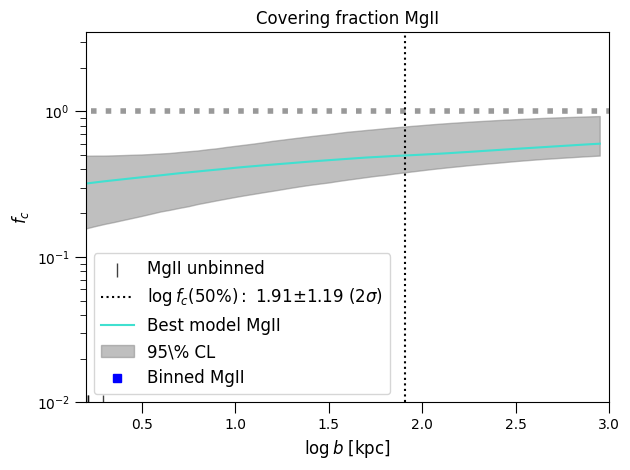

In [635]:
fc_G_15 = run_covering_2.mgii(run = True, filename = "fc_data/G_15.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

In [636]:
# The ranges for the parameters:
logb = np.linspace(-1.5, 1.5, 50)
logm = np.linspace(8, 12, 20)
logsfr = np.linspace(-3, 3, 20)
z_range = np.linspace(0.4, 1.5, 20)
logz = np.log10(1+z_range)

# The fixed values to estimates the fc:
z = 1
Z = np.log10(1+z)
m = 9
sfr = 0

# The extraction of the low, middle, high values:
pbest_G_01, plow_G_01, phigh_G_01 = \
    fc_G_01.predict_2d(logb, params=fc_G_01.trace, z = 1)
pbest_G_03, plow_G_03, phigh_G_03 = \
    fc_G_03.predict_2d(logb, params=fc_G_03.trace, z = 1)
pbest_G_05, plow_G_05, phigh_G_05 = \
    fc_G_05.predict_2d(logb, params=fc_G_05.trace, z = 1)
pbest_G_08, plow_G_08, phigh_G_08 = \
    fc_G_08.predict_2d(logb, params=fc_G_08.trace, z = 1)
pbest_G_1, plow_G_1, phigh_G_1 = \
    fc_G_1.predict_2d(logb, params=fc_G_1.trace, z = 1)
pbest_G_15, plow_G_15, phigh_G_15 = \
    fc_G_15.predict_2d(logb, params=fc_G_15.trace, z = 1)

INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


Text(0, 0.5, '$f_c$')

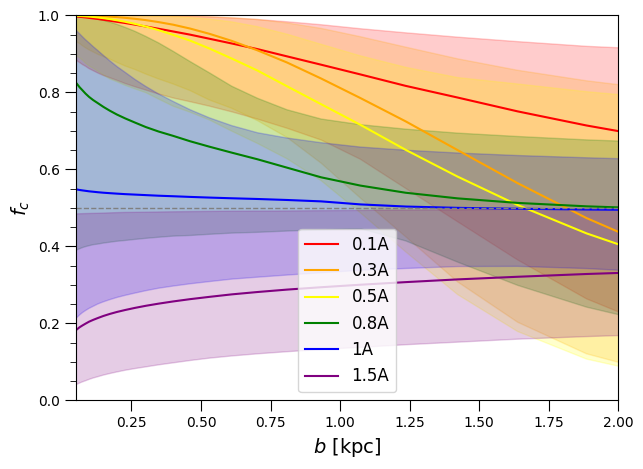

In [672]:
plt.figure(figsize = (7,5), dpi = 100)

#plt.rcParams['lines.linewidth']=1.5
#plt.axhline(0.0, color = "grey", linestyle = "--")
#plt.axhline(1, color = "grey", linestyle = "--")

plt.fill_between(10**logb, plow_G_01, phigh_G_01, color = 'red', alpha = 0.2)
plt.plot(10**logb, pbest_G_01, label= "0.1A", color = "red")

plt.fill_between(10**logb, plow_G_03, phigh_G_03, color = 'orange', alpha = 0.2)
plt.plot(10**logb, pbest_G_03, label= "0.3A", color = "orange")

plt.fill_between(10**logb, plow_G_05, phigh_G_05, color = 'yellow', alpha = 0.2)
plt.plot(10**logb, pbest_G_05, label= "0.5A", color = "yellow")

plt.fill_between(10**logb, plow_G_08, phigh_G_08, color = 'green', alpha = 0.2)
plt.plot(10**logb, pbest_G_08, label= "0.8A", color = "green")

plt.fill_between(10**logb, plow_G_1, phigh_G_1, color = 'blue', alpha = 0.2)
plt.plot(10**logb, pbest_G_1, label= "1A", color = "blue")

plt.fill_between(10**logb, plow_G_15, phigh_G_15, color = 'purple', alpha = 0.2)
plt.plot(10**logb, pbest_G_15, label= "1.5A", color = "purple")

#plt.fill_between(10**logb, plow_isol_2_z_mass_SFR, phigh_isol_2_z_mass_SFR, color = 'deeppink', alpha = 0.2)
#plt.plot(10**logb, pbest_isol_2_z_mass_SFR, label= "2A", color = "deeppink")

#plt.plot(10**logb, pp_Ilane, color = "black", linestyle = "dotted", label = "Schroetter 2021")
#plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")

#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
#plt.legend(bbox_to_anchor=(0.5, 1.25), loc = 'center', ncol = 2)
plt.legend(fontsize = 12)
plt.ylim((0.0,1.))
plt.xlim((0.05,2))
plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")


plt.xlabel("$b$ [kpc]", size = 14)
plt.ylabel("$f_c$", size = 14)
#plt.yscale("log")
#plt.xscale("log")

Text(0, 0.5, '$f_c$')

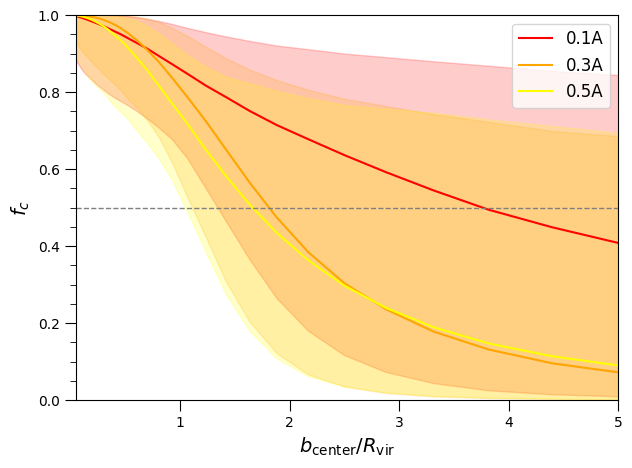

In [674]:
plt.figure(figsize = (7,5), dpi = 100)

#plt.rcParams['lines.linewidth']=1.5
#plt.axhline(0.0, color = "grey", linestyle = "--")
#plt.axhline(1, color = "grey", linestyle = "--")

plt.fill_between(10**logb, plow_G_01, phigh_G_01, color = 'red', alpha = 0.2)
plt.plot(10**logb, pbest_G_01, label= "0.1A", color = "red")

plt.fill_between(10**logb, plow_G_03, phigh_G_03, color = 'orange', alpha = 0.2)
plt.plot(10**logb, pbest_G_03, label= "0.3A", color = "orange")

plt.fill_between(10**logb, plow_G_05, phigh_G_05, color = 'yellow', alpha = 0.2)
plt.plot(10**logb, pbest_G_05, label= "0.5A", color = "yellow")

#plt.fill_between(10**logb, plow_G_08, phigh_G_08, color = 'green', alpha = 0.2)
#plt.plot(10**logb, pbest_G_08, label= "0.8A", color = "green")

#plt.fill_between(10**logb, plow_G_1, phigh_G_1, color = 'blue', alpha = 0.2)
#plt.plot(10**logb, pbest_G_1, label= "1A", color = "blue")

#plt.fill_between(10**logb, plow_G_15, phigh_G_15, color = 'purple', alpha = 0.2)
#plt.plot(10**logb, pbest_G_15, label= "1.5A", color = "purple")

#plt.fill_between(10**logb, plow_isol_2_z_mass_SFR, phigh_isol_2_z_mass_SFR, color = 'deeppink', alpha = 0.2)
#plt.plot(10**logb, pbest_isol_2_z_mass_SFR, label= "2A", color = "deeppink")

#plt.plot(10**logb, pp_Ilane, color = "black", linestyle = "dotted", label = "Schroetter 2021")
#plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")

#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
#plt.legend(bbox_to_anchor=(0.5, 1.25), loc = 'center', ncol = 2)
plt.legend(fontsize = 12)
plt.ylim((0.0,1.))
plt.xlim((0.05,5))
plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")


plt.xlabel("$b_{\mathrm{center}}/R_{\mathrm{vir}}$", size = 14)
plt.ylabel("$f_c$", size = 14)
#plt.yscale("log")
#plt.xscale("log")

Text(0, 0.5, '$f_c$')

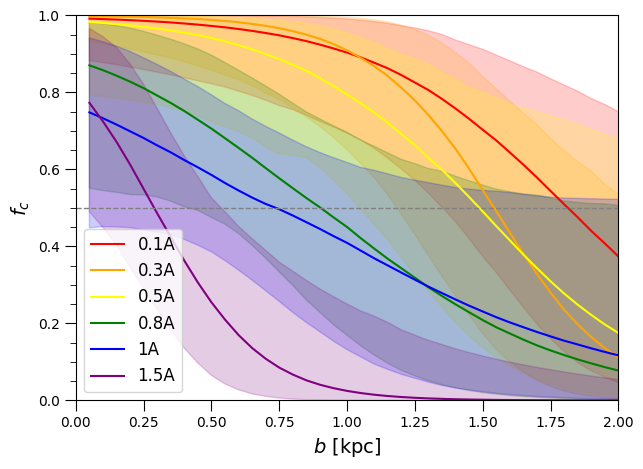

In [600]:
plt.figure(figsize = (7,5), dpi = 100)

#plt.rcParams['lines.linewidth']=1.5
#plt.axhline(0.0, color = "grey", linestyle = "--")
#plt.axhline(1, color = "grey", linestyle = "--")

plt.fill_between(logb, plow_G_01, phigh_G_01, color = 'red', alpha = 0.2)
plt.plot(logb, pbest_G_01, label= "0.1A", color = "red")

plt.fill_between(logb, plow_G_03, phigh_G_03, color = 'orange', alpha = 0.2)
plt.plot(logb, pbest_G_03, label= "0.3A", color = "orange")

plt.fill_between(logb, plow_G_05, phigh_G_05, color = 'yellow', alpha = 0.2)
plt.plot(logb, pbest_G_05, label= "0.5A", color = "yellow")

plt.fill_between(logb, plow_G_08, phigh_G_08, color = 'green', alpha = 0.2)
plt.plot(logb, pbest_G_08, label= "0.8A", color = "green")

plt.fill_between(logb, plow_G_1, phigh_G_1, color = 'blue', alpha = 0.2)
plt.plot(logb, pbest_G_1, label= "1A", color = "blue")

plt.fill_between(logb, plow_G_15, phigh_G_15, color = 'purple', alpha = 0.2)
plt.plot(logb, pbest_G_15, label= "1.5A", color = "purple")

#plt.fill_between(10**logb, plow_isol_2_z_mass_SFR, phigh_isol_2_z_mass_SFR, color = 'deeppink', alpha = 0.2)
#plt.plot(10**logb, pbest_isol_2_z_mass_SFR, label= "2A", color = "deeppink")

#plt.plot(10**logb, pp_Ilane, color = "black", linestyle = "dotted", label = "Schroetter 2021")
#plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")

#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
#plt.legend(bbox_to_anchor=(0.5, 1.25), loc = 'center', ncol = 2)
plt.legend(fontsize = 12)
plt.ylim((0.0,1.))
plt.xlim((0,2))
plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")


plt.xlabel("$b$ [kpc]", size = 14)
plt.ylabel("$f_c$", size = 14)
#plt.yscale("log")
#plt.xscale("log")

# Different estimation of Halo mass

Three different way:
- From stellar mass: We sum M* for all galaxies, and the convert with the Mh-M* relation
- From Rvisu and sigma^2 as we do in the paper and manuscript
- From sigma^3 as in Lemaux and Epinat.

So the error on Mvir is:
\begin{equation}
    \sigma = \frac{d M_{\rm vir}}{d\sigma_g} = 3 \frac{M_{\rm vir}}{\sigma_g} \times \sigma_\sigma    
\end{equation}

In [714]:
G4_9_raw["log_Mvir_sigma2"] = np.log10(G4_9_raw["Mvir_sigma2"])
G4_9_raw["log_Mvir_sigma2_err"] = G4_9_raw["Mvir_sigma2_error"]/G4_9_raw["Mvir_sigma2"]/np.log(10)

In [724]:
GG = const.G.to(u.m**3/u.Msun/(u.s**2))
HH = (1*u.km/u.s/u.Mpc).to(u.m/u.s/u.m)
G4_9_raw["Mvir_Lemaux"] = 3*(3)**0.5*(G4_9_raw["sigma_v"]*1000)**3/(11.4*GG*cosmo.Hz(G4_9_raw["mean_z"])*HH)
G4_9_raw["Mvir_Lemaux_err"] = 3*G4_9_raw["Mvir_Lemaux"]*G4_9_raw["sigma_v_error"]/G4_9_raw["sigma_v"]
G4_9_raw["log_Mvir_Lemaux"] = np.log10(G4_9_raw["Mvir_Lemaux"])
G4_9_raw["log_Mvir_Lemaux_err"] = G4_9_raw["Mvir_Lemaux_err"]/G4_9_raw["Mvir_Lemaux"]/np.log(10)

For the error in Lemaux:
We have 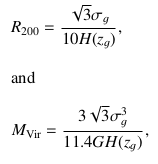

(10.5, 14.5)

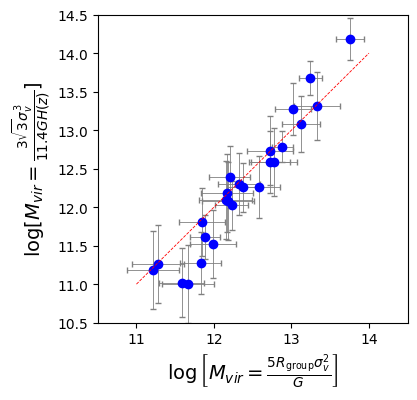

In [795]:
plt.figure(figsize = (4,4), dpi = 100)
plt.errorbar(np.array(G4_9_raw["log_Mvir_sigma2"]),np.array(G4_9_raw["log_Mvir_Lemaux"]), \
             yerr = np.array(G4_9_raw["log_Mvir_Lemaux_err"]),\
            xerr = np.array(G4_9_raw["log_Mvir_sigma2_err"]), linestyle = "none", c = 'gray', \
             linewidth = 0.6, capsize = 2)
plt.scatter(G4_9_raw["log_Mvir_sigma2"], G4_9_raw["log_Mvir_Lemaux"],  c = "blue", zorder = 2)
plt.plot([11,14], [11,14], c = "red", linewidth = 0.6, linestyle = "--")
plt.ylabel("$\log[M_{vir}=\\frac{3 \sqrt{3} \sigma_v^3}{11.4 G H(z)}]$", size = 14)
#plt.xlabel("$\\frac{3 \sqrt{3}}{11.4 G H(z)}$")
plt.xlabel("$\log \left[M_{vir} =\\frac{5 R_{\mathrm{group}} \sigma_v^2}{G} \\right]$", size = 14)
plt.xlim((10.5, 14.5))
plt.ylim((10.5,14.5))

#### From Mstars

In [789]:
Mstar_tot = []
Mhalo = []
for i, g in G4_9_raw.iterrows():
    rr = R[R["group_id"] == g["group_id"]]
    #print(len(rr))
    mm = np.log10(np.sum(10**rr["sed_logMass"]))
    Mstar_tot.append(mm)
    mh = gt.Behroozi_2019(mm, g["mean_z"])
    Mhalo.append(mh)

G4_9_raw["log_Mstar_tot"] = np.array(Mstar_tot)
G4_9_raw["log_Mhalo_from_Mstar"] = np.array(Mhalo)

(10.5, 15.0)

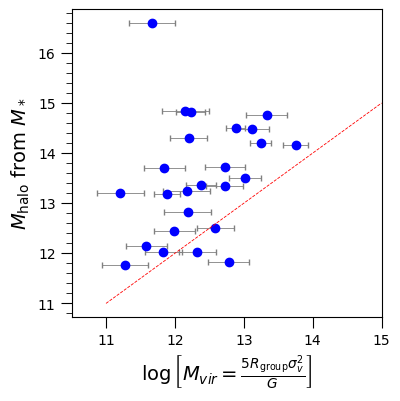

In [793]:
plt.figure(figsize = (4,4), dpi = 100)
plt.errorbar(np.array(G4_9_raw["log_Mvir_sigma2"]),np.array(G4_9_raw["log_Mhalo_from_Mstar"]), \
             #yerr = np.array(G4_9_raw["log_Mvir_Lemaux_err"]),\
            xerr = np.array(G4_9_raw["log_Mvir_sigma2_err"]), linestyle = "none", c = 'gray', \
             linewidth = 0.6, capsize = 2)
plt.scatter(G4_9_raw["log_Mvir_sigma2"], G4_9_raw["log_Mhalo_from_Mstar"],  c = "blue", zorder = 2)
plt.plot([11,15], [11,15], c = "red", linewidth = 0.6, linestyle = "--")
plt.ylabel("$M_{\mathrm{halo}}$ from $M_*$", size = 14)
#plt.xlabel("$\\frac{3 \sqrt{3}}{11.4 G H(z)}$")
plt.xlabel("$\log \left[M_{vir} =\\frac{5 R_{\mathrm{group}} \sigma_v^2}{G} \\right]$", size = 14)
plt.xlim((10.5, 15))
#plt.ylim((10.5,15))

# Table of groups

In [667]:
G4_9_raw[["ID", "field_id", "N_gal", "center_z", "zqso_sdss", "center_ra", "center_dec", "log_Mvir_sigma2",\
        "log_Mvir_sigma2_err", "Rvir_sigma2", "Rvir_sigma2_error", "REW_2796",\
    "detection_limit","m1_m2_ratio", "b_center_kpc_norm2", "b_center_kpc_norm2_err", "b_min_kpc"]]

ID    field_id  N_gal  center_z  zqso_sdss   center_ra  center_dec  \
0    1  J1039p0714     21  0.988650      1.532  159.911199    7.246590   
1    2  J0145p1056     18  0.937800      0.938   26.306264   10.938295   
2    3  J0014m0028     12  0.833650      1.927    3.714539   -0.475704   
3    4  J1107p1021     11  0.745040      1.925  166.928630   10.358552   
4    5  J0058p0111      9  0.637174      1.222   14.734009    1.191147   
5    6  J1107p1021      9  0.900740      1.925  166.919438   10.354043   
6    7  J1352p0614      8  0.606337      1.798  208.072003    6.240712   
7    8  J2152p0625      7  1.432286      2.389  328.004976    6.423658   
8    9  J2137p0012      6  1.214990      1.669  324.451050    0.210079   
9   10  J1358p1145      6  1.099945      1.484  209.532881   11.772834   
10  11  J0838p0257      6  0.940700      1.770  129.714005    2.953269   
11  12  J1236p0725      6  1.331760      1.605  189.099079    7.426897   
12  13  J1509p1506      6  0.971720      2.238  227.248608   15.113219   
13  14  J0015m0751      5  0.629700      0.875    3.900337   -7.846351   
14  15  J1107p1021      5  1.295180      1.925  166.931363   10.363500   
15  16  J2137p0012      5  1.043970      1.669  324.447723    0.201932   
16  17  J0014p0912      5  1.221390      2.308    3.717696    9.201124   
17  18  J2137p0012      5  0.807050      1.669  324.454787    0.206850   
18  19  J0800p1849      5  0.606010      1.294  120.022546   18.822366   
19  20  J1107p1757      4  1.163280      2.133  166.897623   17.958618   
20  21  J0800p1849      4  0.599690      1.294  120.015428   18.820690   
21  22  J0145p1056      4  0.797940      0.938   26.304570   10.944393   
22  23  J1314p0657      4  0.986895      1.880  198.524709    6.956464   
23  24  J0131p1303      4  1.339885      1.595   22.896327   13.062482   
24  25  J0015m0751      4  1.359830      0.875    3.897844   -7.849475   

    log_Mvir_sigma2  log_Mvir_sigma2_err  Rvir_sigma2  Rvir_sigma2_error  \
0         12.882577             0.314194   309.353476          32.399001   
1         13.242665             0.340389   417.037843          47.318340   
2         13.751604             0.421299   647.157253          90.882207   
3         11.887781             0.441297   161.229804          23.716762   
4         12.377448             0.491620   247.496930          40.558175   
5         12.228571             0.491620   194.663596          31.900194   
6         13.019407             0.524190   411.481673          71.898155   
7         13.121494             0.564175   309.768349          58.254530   
8         12.586898             0.614866   223.931821          45.896019   
9         12.202697             0.614866   174.895438          35.845751   
10        11.829953             0.614866   140.838793          28.865661   
11        12.324993             0.614866   174.758433          35.817672   
12        12.720289             0.614866   275.268249          56.417693   
13        12.779780             0.682004   338.234358          76.892439   
14        11.992817             0.682004   137.382405          31.231801   
15        13.331768             0.682004   426.260917          96.903939   
16        11.581904             0.682004   103.241080          23.470290   
17        11.844782             0.682004   151.509704          34.443428   
18        12.726315             0.682004   328.364774          74.648739   
19        12.183474             0.776715   167.808255          43.446397   
20        11.209906             0.776715   102.933507          26.650000   
21        12.169308             0.776715   195.127035          50.519366   
22        11.277111             0.776715    90.250448          23.366293   
23        11.669558             0.776715   105.308358          27.264861   
24        12.150906             0.776715   151.158951          39.135809   

    REW_2796  detection_limit  m1_m2_ratio  b_center_kpc_norm2  \
0      0.627         0.050285     3.

In [666]:
G4_9_raw[["ID", "field_id", "N_gal", "center_z", "center_ra", "center_dec", "REW_2796",\
    "detection_limit", "b_center_kpc_norm2", "b_center_kpc_norm2_err", "b_min_kpc"]]

ID    field_id  N_gal  center_z   center_ra  center_dec  REW_2796  \
0    1  J1039p0714     21  0.988650  159.911199    7.246590     0.627   
1    2  J0145p1056     18  0.937800   26.306264   10.938295     0.118   
2    3  J0014m0028     12  0.833650    3.714539   -0.475704     2.085   
3    4  J1107p1021     11  0.745040  166.928630   10.358552     2.336   
4    5  J0058p0111      9  0.637174   14.734009    1.191147     3.335   
5    6  J1107p1021      9  0.900740  166.919438   10.354043     0.000   
6    7  J1352p0614      8  0.606337  208.072003    6.240712     0.779   
7    8  J2152p0625      7  1.432286  328.004976    6.423658     1.150   
8    9  J2137p0012      6  1.214990  324.451050    0.210079     1.133   
9   10  J1358p1145      6  1.099945  209.532881   11.772834     0.000   
10  11  J0838p0257      6  0.940700  129.714005    2.953269     0.774   
11  12  J1236p0725      6  1.331760  189.099079    7.426897     0.407   
12  13  J1509p1506      6  0.971720  227.248608   15.113219     1.303   
13  14  J0015m0751      5  0.629700    3.900337   -7.846351     0.000   
14  15  J1107p1021      5  1.295180  166.931363   10.363500     0.527   
15  16  J2137p0012      5  1.043970  324.447723    0.201932     0.869   
16  17  J0014p0912      5  1.221390    3.717696    9.201124     1.427   
17  18  J2137p0012      5  0.807050  324.454787    0.206850     0.797   
18  19  J0800p1849      5  0.606010  120.022546   18.822366     1.020   
19  20  J1107p1757      4  1.163280  166.897623   17.958618     1.588   
20  21  J0800p1849      4  0.599690  120.015428   18.820690     0.082   
21  22  J0145p1056      4  0.797940   26.304570   10.944393     1.517   
22  23  J1314p0657      4  0.986895  198.524709    6.956464     0.911   
23  24  J0131p1303      4  1.339885   22.896327   13.062482     0.169   
24  25  J0015m0751      4  1.359830    3.897844   -7.849475     0.000   

    detection_limit  b_center_kpc_norm2  b_center_kpc_norm2_err  b_min_kpc  
0          0.050285            0.963220                0.100879      46.37  
1          0.051605            0.204884                0.023247      12.07  
2          0.054536            0.345321                0.048494       7.77  
3          0.057305            0.226956                0.033385      36.59  
4          0.061081            0.173869                0.035195       6.06  
5          0.052611            1.351160                0.221419      93.01  
6          0.062253            0.148747                0.033007      10.36  
7          0.041114            0.541456                0.208203      60.96  
8          0.045147            0.629321                0.128983      95.16  
9          0.047620            1.631877                0.353664     253.48  
10         0.051528            0.758720                0.155504      64.36  
11         0.042886            0.854630                0.404152     113.48  
12         0.050717            0.427690                0.087657      79.59  
13         0.061361            0.438235                0.099626     116.21  
14         0.043570            1.571653                0.357291      58.22  
15         0.048924            0.385689                0.087681      84.85  
16         0.045017            1.629254                1.184547      99.21  
17         0.055339            0.590455                0.134231      72.37  
18         0.062266            0.400024                0.090939      67.41  
19         0.046226            0.125038                0.032373      20.99  
20         0.062512            1.596631                0.413376      84.86  
21         0.055619            0.519955                0.134619      71.16  
22         0.050330            0.435078                0.232178      37.77  
23         0.042737            1.953904                0.523487     125.53  
24         0.042376            0.385141                0.099715      58.24

In [265]:
c = SkyCoord(ra=np.array(G5_raw["center_ra"])*u.degree, dec=np.array(G5_raw["center_dec"])*u.degree)

In [266]:
c.ra

<Longitude [159.9111988 ,  26.3062641 ,   3.7145385 , 166.9286303 ,
            166.919438  ,  14.73400875, 208.0720034 , 189.09907892,
            209.53288114, 209.5326117 ,   3.8936672 , 227.2486082 ,
            328.00497558, 324.4510498 , 208.0749024 , 129.7140054 ,
            216.4097862 ,  22.90146981, 324.4477234 , 198.52470937,
              3.9003369 , 120.0225457 ,   3.7208854 , 166.9313627 ,
             22.8963271 , 129.7126123 , 324.4547872 ,   3.71769631,
            120.0154275 ,   3.8998133 , 166.9319643 ,   3.9045556 ,
              3.7192408 ] deg>

In [267]:
c.dec

<Latitude [ 7.2465903 , 10.9382951 , -0.4757041 , 10.3585517 , 10.3540432 ,
            1.19114676,  6.24071199,  7.426897  , 11.77283428, 11.7600598 ,
           -7.8526961 , 15.1132189 ,  6.42365774,  0.2100789 ,  6.2394957 ,
            2.9532686 , 12.1545649 , 13.06045239,  0.2019317 ,  6.95646399,
           -7.8463508 , 18.8223664 , -0.4783053 , 10.3635004 , 13.06248167,
            2.947514  ,  0.2068502 ,  9.20112357, 18.8206901 , -7.8432772 ,
           10.3586957 , -7.8548645 , -0.4690363 ] deg>

In [32]:
from astropy import coordinates as coord

In [34]:
ra_sexagesimal = coord.Angle(G5_raw["center_ra"], unit=u.degree).to_string(unit=u.hour, sep=':', precision=2)
ra_sexagesimal

array(['10:39:38.69', '1:45:13.50', '0:14:51.49', '11:07:42.87',
       '11:07:40.67', '0:58:56.16', '13:52:17.28', '12:36:23.78',
       '13:58:07.89', '13:58:07.83', '0:15:34.48', '15:08:59.67',
       '21:52:01.19', '21:37:48.25', '13:52:17.98', '8:38:51.36',
       '14:25:38.35', '1:31:36.35', '21:37:47.45', '13:14:05.93',
       '0:15:36.08', '8:00:05.41', '0:14:53.01', '11:07:43.53',
       '1:31:35.12', '8:38:51.03', '21:37:49.15', '0:14:52.25',
       '8:00:03.70', '0:15:35.96', '11:07:43.67', '0:15:37.09',
       '0:14:52.62'], dtype='<U11')

In [35]:
G5_raw["field_id"]

0     J1039p0714
1     J0145p1056
2     J0014m0028
3     J1107p1021
4     J1107p1021
5     J0058p0111
6     J1352p0614
7     J1236p0725
8     J1358p1145
9     J1358p1145
10    J0015m0751
11    J1509p1506
12    J2152p0625
13    J2137p0012
14    J1352p0614
15    J0838p0257
16    J1425p1209
17    J0131p1303
18    J2137p0012
19    J1314p0657
20    J0015m0751
21    J0800p1849
22    J0014m0028
23    J1107p1021
24    J0131p1303
25    J0838p0257
26    J2137p0012
27    J0014p0912
28    J0800p1849
29    J0015m0751
30    J1107p1021
31    J0015m0751
32    J0014m0028
Name: field_id, dtype: object

# Additional plots

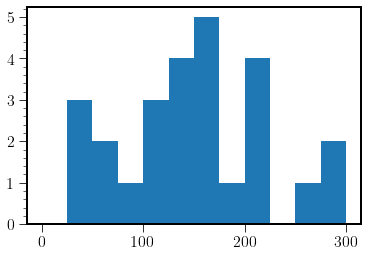

In [268]:
plt.hist(G5["b_center_kpc"], range = (0,300), bins = 12);

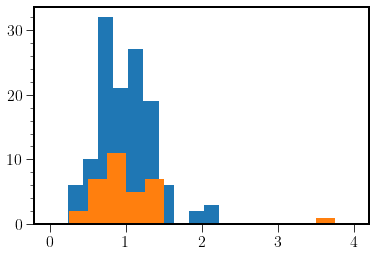

In [269]:
plt.hist(Abs["z_abs"]);
plt.hist(G5_raw["center_z"], range = (0,4), bins = 4*4);

In [326]:
field_lst = Abs["field_name"].unique()

In [472]:
Abs.columns

Index(['field_name', 'z_abs', 'REW_2796', 'sig_REW_2796'], dtype='object')

In [327]:
oii = 3737
mgii = 2796
uves_min = 3000
uves_max = 11000
muse_min = 4700
muse_max = 9350
zmin_oii = muse_min/oii - 1 
zmax_oii = muse_max/oii - 1
zmin_mgii = uves_min/mgii - 1 
zmax_mgii = uves_max/mgii - 1

In [328]:
len(G4_9_raw)

25

Text(0.5, 0, 'redshift')

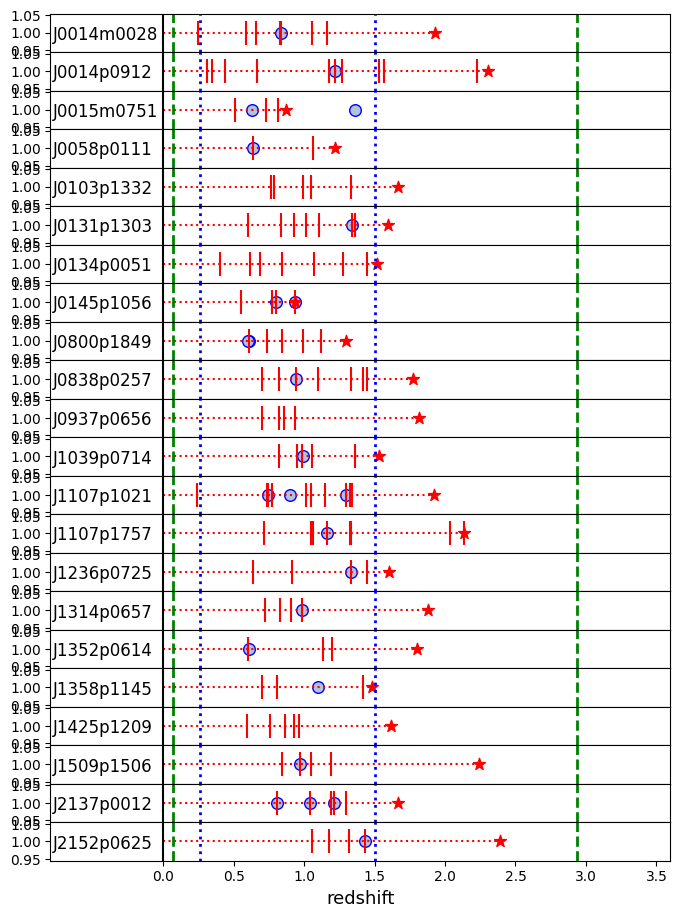

In [359]:
fig = plt.figure(figsize = (8,22*0.5), dpi =100)

i = 1
for f in field_lst:
    plt.subplot(22, 1, i)
    plt.subplots_adjust(wspace=0, hspace=0)
    ab = Abs[Abs["field_name"] == f]
    ab = ab[ab["REW_2796"]>=0.1]
    qso = fields_info[fields_info["field_id"] == f]
    grp = G4_9_raw[G4_9_raw["field_id"] == f]
    plt.scatter(grp["center_z"], grp["center_z"]/grp["center_z"], marker = "o", \
                  s = 70, color = "lightsteelblue", edgecolors = "b")
    plt.hlines(y = 1, xmin = 0, xmax = qso["zqso_sdss"], linestyle = ":", color = "r")
    plt.scatter(ab["z_abs"], ab["z_abs"]/ab["z_abs"], marker = "|", s = 300, c = "r")
    plt.scatter(qso["zqso_sdss"], qso["zqso_sdss"]/qso["zqso_sdss"], marker = "*", c = "r", s = 80)
    
    plt.xticks(ticks = [0., 0.5, 1.0, 1.5, 2, 2.5, 3, 3.5])
    plt.xlim((-0.8,3.6))
    plt.axvline(zmin_oii, linestyle = ":", c = "blue", linewidth = 2)
    plt.axvline(zmax_oii, linestyle = ":", c = "blue", linewidth = 2)
    plt.axvline(zmin_mgii, linestyle = "--", c = "green", linewidth = 2)
    plt.axvline(zmax_mgii, linestyle = "--", c = "green", linewidth = 2)
    plt.axvline(0, c = "black")
    plt.text(-0.78, 0.98, f, fontsize=12)
    #print(plt.yticks)
    
    i += 1
plt.xlabel("redshift", size = 13)

# Build catalog for OII maps

In [ ]:
len(G5)

In [ ]:
GG = G5_raw[np.abs(G5_raw["zqso_sdss"] - G5_raw["center_z"]) > 0.01]
GG = GG[["ID", "group_id", "field_id", "center_z", "mean_z", "vlos_spread", "z_min", "z_max", "lambda_oii_a"]]
GG["min_oii"] = 3727*(1+GG["z_min"])
GG["max_oii"] = 3727*(1+GG["z_max"])
GG

In [ ]:
len(GG)

In [ ]:
GG.to_csv("G5_for_oii_maps4_no_qso.csv", index = False)

Now for groups at z = zqso:

In [ ]:
GG = G5_raw[np.abs(G5_raw["zqso_sdss"] - G5_raw["center_z"]) < 0.01]
GG = GG[["ID", "group_id", "field_id", "center_z", "mean_z", "vlos_spread", "z_min", "z_max", "lambda_oii_a"]]
GG["min_oii"] = 3727*(1+GG["z_min"])
GG["max_oii"] = 3727*(1+GG["z_max"])
GG

In [ ]:
GG.to_csv("G5_for_oii_maps4_at_qso.csv", index = False)

In [ ]:
G5_raw[np.abs(G5_raw["zqso_sdss"] - G5_raw["center_z"]) < 0.01]

In [ ]:
G5_raw.columns

In [ ]:
G5_raw_reduc = G5_raw[["group_id", "ID"]]

In [ ]:
R["group_ID"] = -1
for i, g in G5_raw.iterrows():
    g_id = g["group_id"]
    idx = R.index[R["group_id"] == g_id]
    #print(idx)
    R.loc[idx, "group_ID"] = g["ID"]

In [ ]:
len(R[R["group_ID"] !=-1])

In [ ]:
R_reduc = R[["ID", "group_ID"]]
R_reduc.to_csv("R_reduc.csv", index = False)

In [ ]:
alpha -4.8 [-11.74--0.53] (95\%) 
beta 2.1 [1.54-2.85] (95\%) 
f_out 0.2 [0.01-0.48] (95\%) 
p_out 0.6 [0.04-0.98] (95\%)

In [ ]:
print(11.7 - 4.8)
print(0.53-4.8)

In [ ]:
print(2.1 - 1.54)
print(2.85-2.1)

In [ ]:
print(0.2 - 0.01)
print(0.48 - 0.2)

In [ ]:
print(0.6 - 0.04)
print(0.6 - 0.98)

In [ ]:
alpha -4.6 [-11.38--0.45] (95\%) 
beta 1.1 [0.63-2.43] (95\%) 
f_out 0.2 [0.01-0.48] (95\%) 
p_out 0.6 [0.04-0.98] (95\%)

In [ ]:
print(11.38 - 4.6)
print(0.45 - 4.6)

In [ ]:
print(1.1 - 0.63)
print(2.43-1.1)

In [ ]:
print(0.2 - 0.01)
print(0.48 - 0.2)

In [ ]:
gid.plot_groups_2(R, G5)

In [ ]:
len(G5)

In [ ]:
G5

In [ ]:
Abs = gid.get_N100_abs(Abs, R, dv = 0.5e6)
G5_1 = G5[["field_id", "group_id", "N_gal", "center_z", "b_center_kpc"]]
G5_2 = G5_1.copy()
G5_3 = G5_1.copy()

In [ ]:
G5_1 = gid.match_absorptions(G5_1, Abs, dv = 0.01e6)
G5_2 = gid.match_absorptions(G5_2, Abs, dv = 0.4e6)
G5_3 = gid.match_absorptions(G5_3, Abs, dv = 5e6)

print(len(G5_1[G5_1["bool_absorption"] == 1]))
print(len(G5_2[G5_2["bool_absorption"] == 1]))
print(len(G5_3[G5_3["bool_absorption"] == 1]))

In [ ]:
G5_1.columns

In [ ]:
G5_1[["group_id", "bool_absorption"]]

In [ ]:
for c in R.columns:
    print(c)

# uncertainties on velocities

In [ ]:
dlambda = 1.25 #Angstrom, the spectral pixel in MUSE is 1.25A
z = 1
dz = (4700*(1+z)+dlambda)/4700 - 1-z
print(dz)
dv = const.c*dz/(1+z)
print(dv)

In [ ]:
R[[]]

In [ ]:
G5[["field_id", "center_z", "bool_absorption"]]

In [ ]:
len(R)

In [ ]:
for c in R.columns:
    print(c)

In [253]:
126-79

47

## Erreur sur dispersion des vitesses en fonction de N

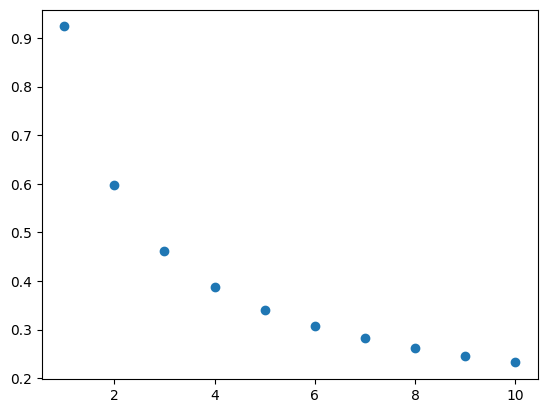

In [322]:
NNN = np.arange(10)+1
errr = gt.sigma_error(1, NNN)
plt.scatter(NNN, errr)

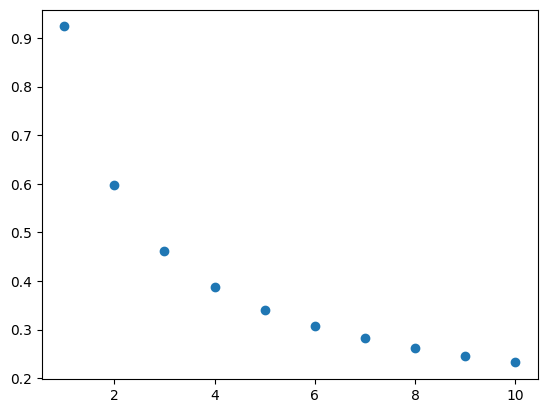

In [323]:
NNN = np.arange(10)+1
errr = gt.sigma_error(100, NNN)
plt.scatter(NNN, errr/100)

As Mvir is a function of 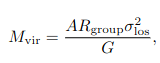

In [ ]:
sig_Mvir = A*3*sig*err/G
sig_Mvir/Mvir = 3*err/sig
mais comme err/sig = 0.4, on a:
sig_Mvir/Mvir = 3*err/sig = 1.2

donc en log10(Mvir):
sig_logMvir = sig_Mvir/Mvir/log(10) = 1.2/log(10)

In [802]:
1.2/np.log(10)

0.5211533782839022

In [ ]:
0.5